# LLMs for Mental Health Early Detection

## 1. Data Cleaning & Structuring Pipeline

### 1.1 Loading data

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./beyond_blue_scraping/data/beyondblue.csv')
df.columns

Index(['post_id', 'title', 'author', 'date', 'category', 'preview',
       'post_text', 'num_comments', 'comments_combined', 'url'],
      dtype='object')

In [3]:
df.head()

post_id                                        title          author  \
0        1                     Struggling at the moment            Toby   
1        2                                      Anxiety          Shell1   
2        3                                  overwhelmed  Guest_87295139   
3        4                                      Stalker         G-i-g-i   
4        5  Generalised Anxiety disorder not going good          Lil123   

         date category                                            preview  \
0  2025-07-16  Anxiety  Hello everyone, this is my first post, so I ho...   
1  2025-05-23  Anxiety  Hi my name is Michelle and I have had Anxiety ...   
2  2025-07-14  Anxiety  sorry if this is alot i just rlly need to get ...   
3  2025-07-14  Anxiety  I feel no one is supporting me. I have a stalk...   
4  2025-07-14  Anxiety  Hi, my name is lily. I have no idea what else ...   

                                           post_text  num_comments  \
0  Hello everyone, this is my first post, so I ho...             4   
1  Hi my name is Michelle and I have had Anxiety ...             2   
2  sorry if this is alot i just rlly need to get ...             2   
3  I feel no one is supporting me. I have a stalk...             3   
4  Hi, my name is lily. I have no idea what else ...             2   

                                   comments_combined  \
0  [{"comment_id": "1", "author": "Morph", "times...   
1  [{"comment_id": "1", "author": "Croix", "times...   
2  [{"comment_id": "1", "author": "TrueSeeker", "...   
3  [{"comment_id": "1", "author": "TrueSeeker", "...   
4  [{"comment_id": "1", "author": "TrueSeeker", "...   

                                                 url  
0  https://forums.beyondblue.org.au/t5/anxiety/st...  
1  https://forums.beyondblue.org.au/t5/anxiety/an...  
2  https://forums.beyondblue.org.au/t5/anxiety/ov...  
3  https://forums.beyondblue.org.au/t5/anxiety/st...  
4  https://forums.beyondblue.org.au/t5/anxiety/ge...

In [4]:
df.shape

(6753, 10)

In [5]:
print(df.isna().sum())

post_id              0
title                0
author               0
date                 0
category             0
preview              0
post_text            0
num_comments         0
comments_combined    0
url                  0
dtype: int64


In [6]:
df.shape

(6753, 10)

In [7]:
print((df['comments_combined'].astype(str).str.strip() == "[]").sum())

29


Although there are 29 comments are empty, but we still need the posts. We will remove it after flatten the dataset.

In [8]:
df[['title', 'post_text']].duplicated().sum()

137

In [9]:
# Remove duplicate rows based only on 'title' and 'post_text'
df = df.drop_duplicates(subset=['title', 'post_text'])

print(df.shape)

(6616, 10)


Here we found out there are 137 rows show up multiple times, maybe this problem happens from web scraping, let's drop duplicate here. And there are 6616 rows remain.

In [ ]:
# Convert 'created_utc' to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Check date range in a DataFrame
df['date'].min()
df['date'].max()

print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Total days: {(df['date'].max() - df['date'].min()).days}")

Date range: 2019-01-06 00:00:00 to 2025-07-18 00:00:00
Total days: 2385


Our data is from 2019 to 2025 and there are total 6752 of posts. 

In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 6616 entries, 0 to 6616
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   post_id            6616 non-null   int64         
 1   title              6616 non-null   object        
 2   author             6616 non-null   object        
 3   date               6616 non-null   datetime64[ns]
 4   category           6616 non-null   object        
 5   preview            6616 non-null   object        
 6   post_text          6616 non-null   object        
 7   num_comments       6616 non-null   int64         
 8   comments_combined  6616 non-null   object        
 9   url                6616 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 568.6+ KB


post_id                           date  num_comments
count  6616.000000                           6616   6616.000000
mean   3309.215840  2022-08-26 00:10:00.725513984      5.410822
min       1.000000            2019-01-06 00:00:00      0.000000
25%    1654.750000            2021-07-26 00:00:00      2.000000
50%    3309.500000            2022-08-29 00:00:00      3.000000
75%    4963.250000            2023-11-04 00:00:00      6.000000
max    6617.000000            2025-07-18 00:00:00     40.000000
std    1910.371392                            NaN      6.924050

In [12]:
df = df[df['author'] != 'BeyondBlue']

In case we lose the guidelines from the website, we drop it here.

### 1.2 Flatten Comments While Retaining Posts

In [ ]:
flatten_rows = []

for idx, row in df.iterrows():
    post_id = row['post_id']
    author = row['author']
    category = row['category']
    title = row['title']
    
    # Add the original post
    flatten_rows.append({
        "author": author,
        "post_id": post_id,
        "comment_id": "0",
        "timestamp": row['date'],
        "category": category,
        "title": title,
        "text": row['post_text'],
        "is_post": True,
        "thread_owner": author
    })
    
    # Flatten comments
    try:
        comments = json.loads(row['comments_combined'])
        for comment in comments:
            flatten_rows.append({
                "author": comment.get('author'),
                "post_id": post_id,
                "comment_id": comment.get('comment_id'),
                "timestamp": comment.get('timestamp'),
                "category": category,
                "title": None,
                "text": comment.get('comment'),
                "is_post": False,
                "thread_owner": author                
            })
    except json.JSONDecodeError:
        continue

In [14]:
flatten_rows

[{'author': 'Toby',
  'post_id': 1,
  'comment_id': '0',
  'timestamp': Timestamp('2025-07-16 00:00:00'),
  'category': 'Anxiety',
  'title': 'Struggling at the moment',
  'text': "Hello everyone, this is my first post, so I hope it's ok. I've suffered depression for many years, but it's now developed into, and been diagnosed as, General Anxiety Disorder, which is in my case, is having a much greater detrimental affect on me. I have a loving, very supportive wife, a nice home, and so I know there are many many people worse of than me, & I'm grateful for what I have. Nevertheless, I just cannot shake the anxiety that I have, it's with me all the time, it's affecting my life, what I do, I feel frightened, afraid, have no self confidence, & I just can't get myself going. So, I'm hoping to find support & discussion on Beyond Blue, where I can discuss my issues with other people who may have the same issues.",
  'is_post': True,
  'thread_owner': 'Toby'},
 {'author': 'Morph',
  'post_id': 1

In [15]:
flat_df = pd.DataFrame(flatten_rows)

flat_df['timestamp'] = pd.to_datetime(flat_df['timestamp'], errors='coerce')

In [16]:
flat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42412 entries, 0 to 42411
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   author        42412 non-null  object        
 1   post_id       42412 non-null  int64         
 2   comment_id    42412 non-null  object        
 3   timestamp     42412 non-null  datetime64[ns]
 4   category      42412 non-null  object        
 5   title         6614 non-null   object        
 6   text          42412 non-null  object        
 7   is_post       42412 non-null  bool          
 8   thread_owner  42412 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 2.6+ MB


In [17]:
flat_df.isna().sum()

author              0
post_id             0
comment_id          0
timestamp           0
category            0
title           35798
text                0
is_post             0
thread_owner        0
dtype: int64

In [18]:
unique_authors = flat_df['author'].dropna().unique()
author_to_id = {name: idx for idx, name in enumerate(unique_authors, start=1001)}
flat_df['user_id'] = flat_df['author'].map(author_to_id)

In [19]:
all_thread_owners = flat_df['thread_owner'].dropna().unique()
for name in all_thread_owners:
    if name not in author_to_id:
        author_to_id[name] = max(author_to_id.values()) + 1
flat_df['thread_owner_id'] = flat_df['thread_owner'].map(author_to_id)

In [20]:
flat_df.head(5)

author  post_id comment_id  timestamp category  \
0             Toby        1          0 2025-07-16  Anxiety   
1            Morph        1          1 2025-07-17  Anxiety   
2  AudaciousPoodle        1          2 2025-07-17  Anxiety   
3           _Gigi_        1          3 2025-07-18  Anxiety   
4             Toby        1          4 2025-07-18  Anxiety   

                      title  \
0  Struggling at the moment   
1                      None   
2                      None   
3                      None   
4                      None   

                                                text  is_post thread_owner  \
0  Hello everyone, this is my first post, so I ho...     True         Toby   
1  Hi Toby, welcome and congratulations on your f...    False         Toby   
2  Hi Toby, Reading your post sounds just like wh...    False         Toby   
3  Hello Toby,I'm glad you've decided to reach ou...    False         Toby   
4  My anxiety is affecting my whole life. When I ...    False         Toby   

   user_id  thread_owner_id  
0     1001             1001  
1     1002             1001  
2     1003             1001  
3     1004             1001  
4     1001             1001

Here we make the structure of dataset more simple to read.

In [21]:
flat_df.sort_values(by=['user_id', 'timestamp', 'post_id'], inplace=True)
flat_df.reset_index(drop=True, inplace=True)

In [22]:
flat_df.head(5)

author  post_id comment_id  timestamp         category  \
0   Toby        1          0 2025-07-16          Anxiety   
1   Toby        5          2 2025-07-16          Anxiety   
2   Toby        1          4 2025-07-18          Anxiety   
3  Morph     3922          5 2025-07-13  PTSD and trauma   
4  Morph        1          1 2025-07-17          Anxiety   

                      title  \
0  Struggling at the moment   
1                      None   
2                      None   
3                      None   
4                      None   

                                                text  is_post  thread_owner  \
0  Hello everyone, this is my first post, so I ho...     True          Toby   
1  Hello Lily, I'm new to the Forum, but I read y...    False        Lil123   
2  My anxiety is affecting my whole life. When I ...    False          Toby   
3  Hi.  Rather than post on a forum here, maybe g...    False  starsandmoon   
4  Hi Toby, welcome and congratulations on your f...    False          Toby   

   user_id  thread_owner_id  
0     1001             1001  
1     1001             1012  
2     1001             1001  
3     1002             5027  
4     1002             1001

In [23]:
flat_df.tail(5)

author  post_id comment_id  timestamp  \
42407    Teegs_     6615          2 2020-06-15   
42408    Teegs_     6615          5 2020-07-15   
42409    Dearcy     6615          4 2020-06-25   
42410    Lost__     6616          0 2020-07-12   
42411  Cookie64     6617          0 2019-07-17   

                              category  \
42407  Suicidal thoughts and self-harm   
42408  Suicidal thoughts and self-harm   
42409  Suicidal thoughts and self-harm   
42410  Suicidal thoughts and self-harm   
42411  Suicidal thoughts and self-harm   

                                         title  \
42407                                     None   
42408                                     None   
42409                                     None   
42410  Everyone would be better off without me   
42411       Feeling used, abused and discarded   

                                                    text  is_post  \
42407  I've tried to talk to a couple of local GPs bu...    False   
42408  Thank you for your replies, I really appreciat...    False   
42409  Hi Teegs,  Of course the doctors are giving so...    False   
42410  Never made a post like this so I don't really ...     True   
42411  Been good friends with my brother in law and a...     True   

      thread_owner  user_id  thread_owner_id  
42407       Teegs_     7317             7317  
42408       Teegs_     7317             7317  
42409       Teegs_     7318             7317  
42410       Lost__     7319             7319  
42411     Cookie64     7320             7320

In [24]:
flat_df.shape

(42412, 11)

After flatten the data to combine posts and comments together, we got 42960 rows of dataset. 

In [25]:
df = flat_df.copy()
df = df.sort_values('timestamp')

In [26]:
print(f"Overall Dataset Distribution:")
overall_counts = df['category'].value_counts()
total_posts = len(df)

for category, count in overall_counts.items():
    percentage = count / total_posts * 100
    print(f"  {category:<30}: {count:>6} threads ({percentage:>5.1f}%)")

# Calculate percentage of is_post True/False per category
post_comment_dist = flat_df.groupby('category')['is_post'].value_counts(normalize=True).unstack(fill_value=0) * 100

print("\nPercentage of posts/comments per category:")
for cat in post_comment_dist.index:
    true_pct = post_comment_dist.loc[cat, True]
    false_pct = post_comment_dist.loc[cat, False]
    print(f"  {cat:<30}: {true_pct:5.1f}% posts, {false_pct:5.1f}% comments")

Overall Dataset Distribution:
  Depression                    :  11845 threads ( 27.9%)
  Anxiety                       :  11617 threads ( 27.4%)
  Suicidal thoughts and self-harm:   9748 threads ( 23.0%)
  PTSD and trauma               :   9202 threads ( 21.7%)

Percentage of posts/comments per category:
  Anxiety                       :  16.8% posts,  83.2% comments
  Depression                    :  16.6% posts,  83.4% comments
  PTSD and trauma               :  15.1% posts,  84.9% comments
  Suicidal thoughts and self-harm:  13.4% posts,  86.6% comments


In [27]:
df.head()

author  post_id comment_id  timestamp         category  \
39118  CatLadyInTraining     4921          0 2019-01-06  PTSD and trauma   
24                 Croix     4921          1 2019-01-06  PTSD and trauma   
19537         White_Rose     4921          2 2019-01-07  PTSD and trauma   
28533            PamelaR     4921          3 2019-01-07  PTSD and trauma   
40030             RM2926     5307          0 2019-01-08  PTSD and trauma   

                                                   title  \
39118  Emotional deprivation/ childhood emotional neg...   
24                                                  None   
19537                                               None   
28533                                               None   
40030         Worried about the happiness of my children   

                                                    text  is_post  \
39118  Hello, this is my first post but I’ve been rea...     True   
24     Dear CatLadyInTraining~ Welcome here. I'd imag...    False   
19537  Dear CatladyInTraining First I want to welcome...    False   
28533  Hi CatLadyInTraining and welcome to our forums...    False   
40030  During my last pregnancy I had to deal with a ...     True   

            thread_owner  user_id  thread_owner_id  
39118  CatLadyInTraining     5925             5925  
24     CatLadyInTraining     1006             5925  
19537  CatLadyInTraining     1442             5925  
28533  CatLadyInTraining     2863             5925  
40030             RM2926     6342             6342

## 2. NLP preprocessing & feature extraction
In this part we will experiment the NLP preprocessing and feature extraction by LIWC. We will apply WorldPiece tokenization to match our LLM vocabularies. Due to LIWC is not open sources so we choose to use Empath as a alternative method.

In [28]:
#! pip install nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

# custom_stopwords = set(stopwords.words('english')) | {
#     'one', 'way', 'something', 'someone', 'thing', 'make', 'might', 'also',
#     'still', 'dont', 'use', 'even', 'get', 'know', 'really', 'lot', 'feel',
#     'im', 'ive', 'youre', 'theyre', 'theres', 'its', 'thats', 'like', 'just',
#     'think', 'much', 'want', 'need', 'see', 'take', 'find', 'say', 'come',
#     'get', 'could', 'back', 'talk', 'thought', 'try', 'time', 'day', 'year',
#     'work', 'person', 'always', 'never', 'many', 'please', 'sorry', 'thank', 
#     'people', 'feeling', 'would', 'going', 'may', 'cant', 'things', 'years',
#     'thought', 'thoughts', 'hear', 'heard', 'saw', 'seen', 'look', 'looking',
#     'looked', 'feelings', 'felt', 'says', 'understand', 'understood',
#     'understanding', 'believe', 'believes', 'believed', 'keep', 'keeps',
#     'time', 'times', 'days', 'week', 'weeks', 'month', 'months', 'sometime'
#     'trying', 'forum', 'forums', 'post', 'posts', 'comment', 'comments',
#     'thread', 'threads', 'topic', 'topics', 'reply', 'replies', 'able',
#     'sound', 'sounds', 'sounded', 'soundly', 'soundness', 'sounded',
#     'give', 'gives', 'gave', 'giving', 'feelings', 'around', 'arounds',
#     'anything', 'got', 'new', 'experience', 'others', 'loves', 'love',
#     'first', 'self', 'sometimes', 'said', 'getting', 'though', 'job',
#     'everything', 'sense', 'let', 'anyone', 'another', 'place', 'maybe',
#     'youve', 'start', 'bit', 'didnt', 'doesnt', 'does', 'do', 'doing',
#     'welcome', 'part', 'moment', 'moments', 'call', 'tell', 'told',
#     'tells', 'talking', 'talked', 'talks', 'asked'
# }
# stop_words = custom_stopwords
stop_words = set(stopwords.words('english'))


### 2.1 Text cleaning

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove non-alphabetic characters (preserve space)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = re.findall(r'\b[a-z]+\b', text)
    # Remove stopwords and apply simple stemming
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(cleaned)

In [30]:
df['clean_text'] = df['text'].apply(clean_text)

In [31]:
print(df['clean_text'].head())

39118    hello first post ive reading forum background ...
24       dear catladyintraining welcome imagine number ...
19537    dear catladyintraining first want welcome foru...
28533    catladyintraining welcome forum croix mary giv...
40030    last pregnancy deal series traumatic event rea...
Name: clean_text, dtype: object


In [32]:
df.head(5)

author  post_id comment_id  timestamp         category  \
39118  CatLadyInTraining     4921          0 2019-01-06  PTSD and trauma   
24                 Croix     4921          1 2019-01-06  PTSD and trauma   
19537         White_Rose     4921          2 2019-01-07  PTSD and trauma   
28533            PamelaR     4921          3 2019-01-07  PTSD and trauma   
40030             RM2926     5307          0 2019-01-08  PTSD and trauma   

                                                   title  \
39118  Emotional deprivation/ childhood emotional neg...   
24                                                  None   
19537                                               None   
28533                                               None   
40030         Worried about the happiness of my children   

                                                    text  is_post  \
39118  Hello, this is my first post but I’ve been rea...     True   
24     Dear CatLadyInTraining~ Welcome here. I'd imag...    False   
19537  Dear CatladyInTraining First I want to welcome...    False   
28533  Hi CatLadyInTraining and welcome to our forums...    False   
40030  During my last pregnancy I had to deal with a ...     True   

            thread_owner  user_id  thread_owner_id  \
39118  CatLadyInTraining     5925             5925   
24     CatLadyInTraining     1006             5925   
19537  CatLadyInTraining     1442             5925   
28533  CatLadyInTraining     2863             5925   
40030             RM2926     6342             6342   

                                              clean_text  
39118  hello first post ive reading forum background ...  
24     dear catladyintraining welcome imagine number ...  
19537  dear catladyintraining first want welcome foru...  
28533  catladyintraining welcome forum croix mary giv...  
40030  last pregnancy deal series traumatic event rea...

By the steps of above, we did remove emojis, links, and special characters, tokenization, lowercasing, stopword removal, and lemmatization. These steps reduce noise and standardize the data, ensuring that both LLMs and traditional feature extractors(LIWC) can process the input effectively.

#### 2.1.1 Blank text after cleaning

In [33]:
print(df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())

28


In [34]:
df['clean_text'] = df['clean_text'].fillna("").astype(str)
df = df[df['clean_text'].str.strip() != ""]

In [35]:
print(df['clean_text'].apply(lambda x: len(x.strip()) == 0).sum())

0


In [36]:
print(df.shape)

(42384, 12)


In [37]:
from collections import Counter
all_words = ' '.join(df['clean_text']).split()
print(Counter(all_words).most_common(50))

[('feel', 44042), ('like', 38293), ('time', 31655), ('know', 29333), ('thing', 29202), ('help', 26039), ('dont', 25995), ('get', 24915), ('people', 23872), ('feeling', 22764), ('really', 22498), ('life', 22295), ('one', 22203), ('would', 20734), ('way', 19884), ('think', 19391), ('also', 18791), ('much', 17586), ('want', 16883), ('ive', 16867), ('need', 16842), ('work', 16345), ('year', 16331), ('support', 15821), ('thought', 15535), ('going', 15438), ('even', 14885), ('make', 14669), ('good', 14532), ('day', 14432), ('could', 13535), ('anxiety', 13359), ('take', 12838), ('see', 12836), ('find', 12614), ('back', 12446), ('something', 12312), ('hope', 11982), ('may', 11911), ('youre', 11641), ('say', 11290), ('friend', 11133), ('cant', 11122), ('come', 10808), ('hard', 10718), ('lot', 10661), ('well', 10562), ('talk', 10369), ('someone', 10304), ('sorry', 9610)]


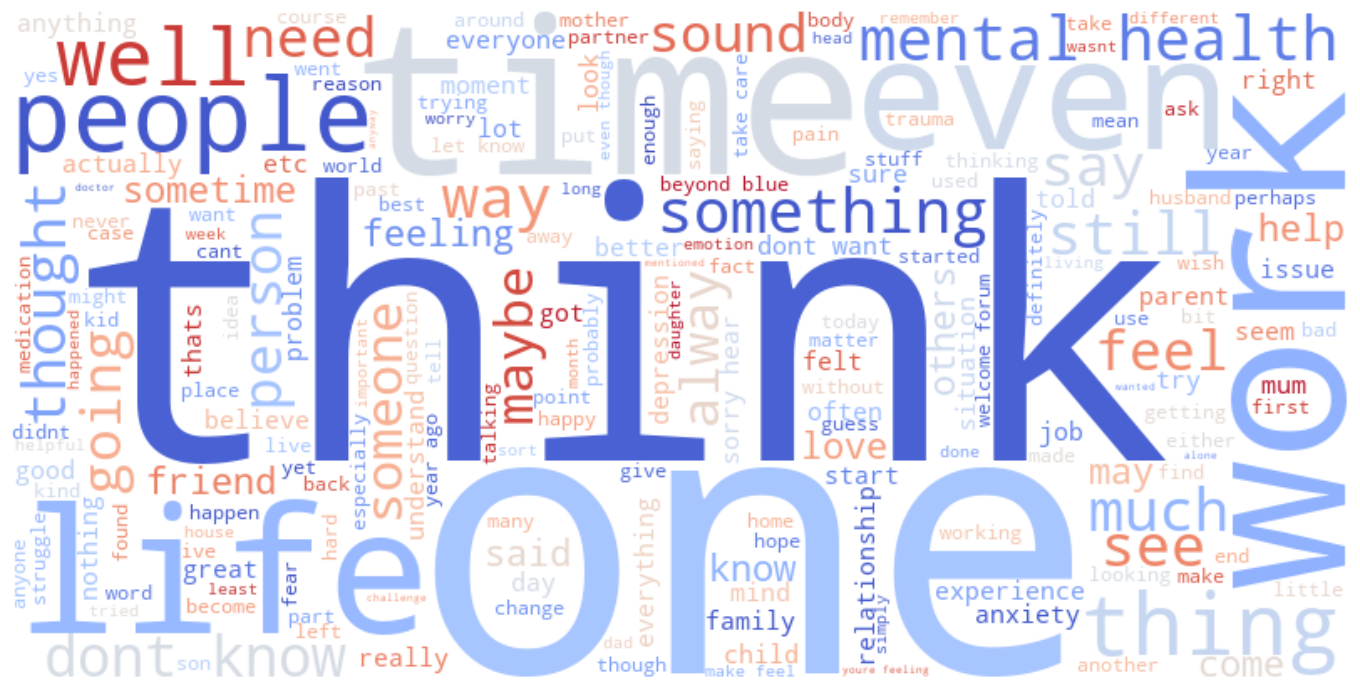

In [38]:
from wordcloud import WordCloud

# Combine all clean_text from df into a single string
all_text = " ".join(df['clean_text'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, colormap='coolwarm').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_56499/1077724871.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(array([17532., 17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

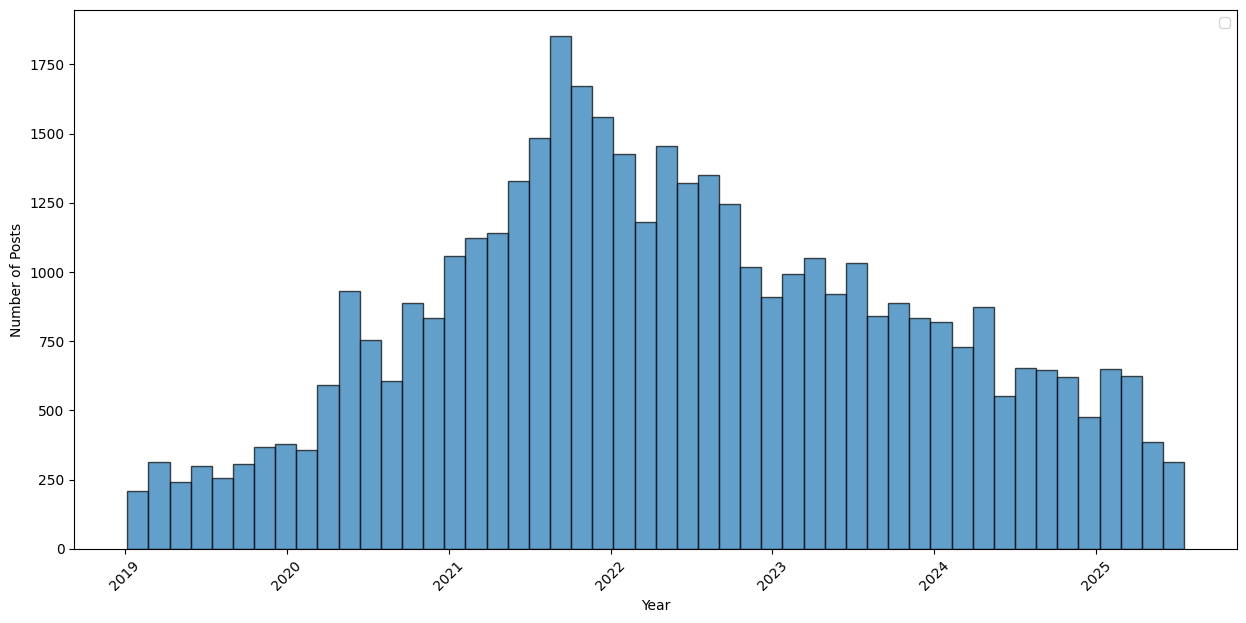

In [39]:
plt.figure(figsize=(15, 7))
plt.hist([df['timestamp']], 
                bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.legend()
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78],
 [Text(0, 0, '2019-01'),
  Text(1, 0, '2019-02'),
  Text(2, 0, '2019-03'),
  Text(3, 0, '2019-04'),
  Text(4, 0, '2019-05'),
  Text(5, 0, '2019-06'),
  Text(6, 0, '2019-07'),
  Text(7, 0, '2019-08'),
  Text(8, 0, '2019-09'),
  Text(9, 0, '2019-10'),
  Text(10, 0, '2019-11'),
  Text(11, 0, '2019-12'),
  Text(12, 0, '2020-01'),
  Text(13, 0, '2020-02'),
  Text(14, 0, '2020-03'),
  Text(15, 0, '2020-04'),
  Text(16, 0, '2020-05'),
  Text(17, 0, '2020-06'),
  Text(18, 0, '2020-07'),
  Text(19, 0, '2020-08'),
  Text(20, 0, '2020-09'),

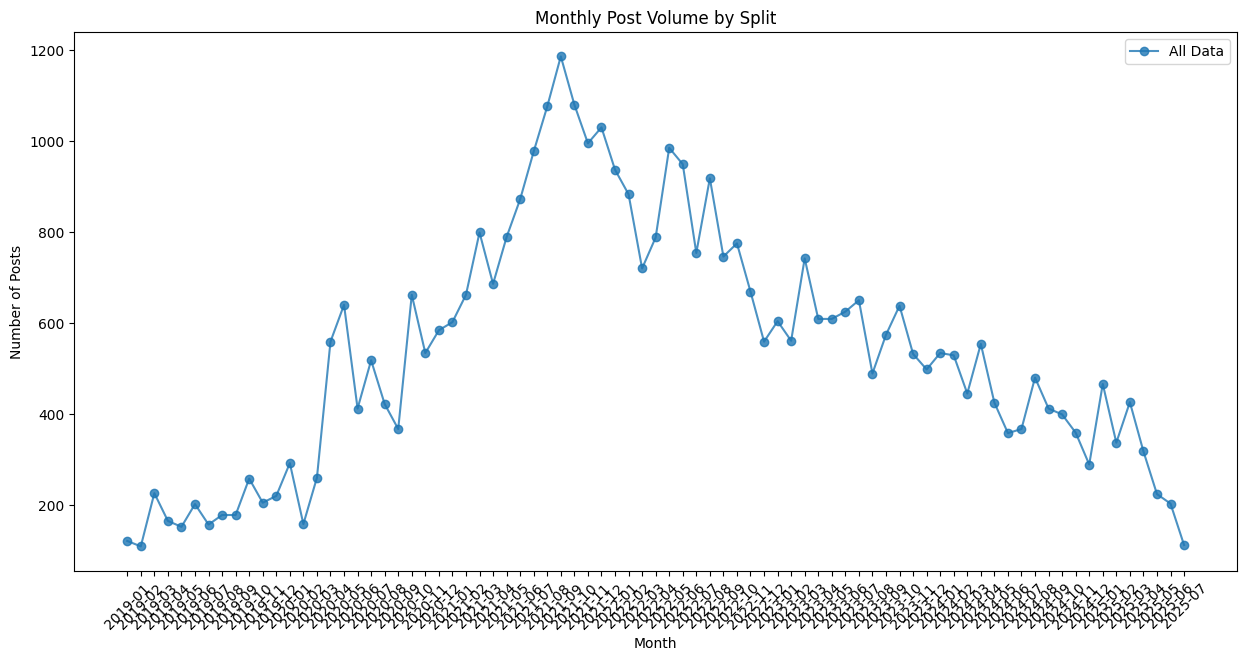

In [40]:
plt.figure(figsize=(15, 7))
df['month'] = df['timestamp'].dt.to_period('M')

monthly_df = df.groupby('month').size()

plt.plot(monthly_df.index.astype(str), monthly_df.values, 'o-', label='All Data', alpha=0.8)
plt.title('Monthly Post Volume by Split')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend()
plt.xticks(rotation=45)

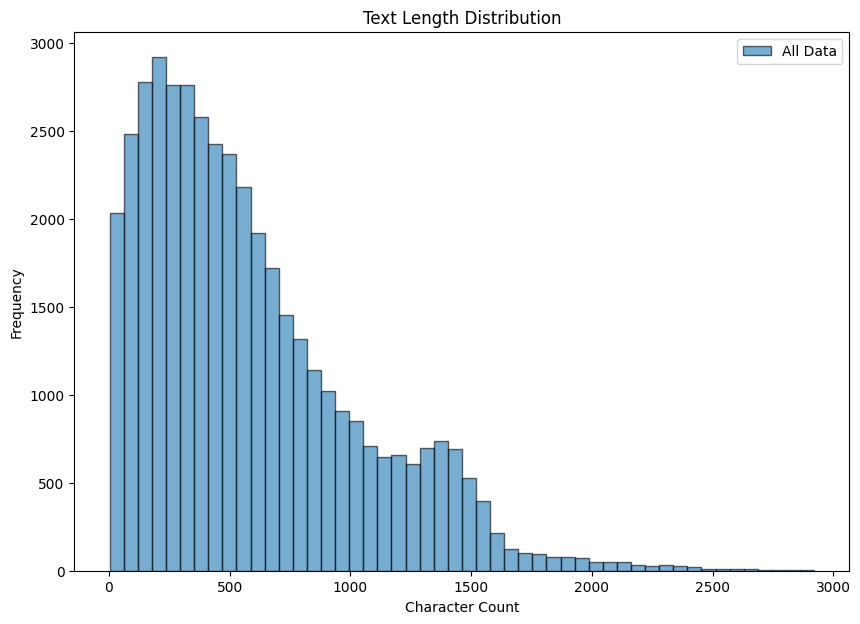

In [41]:
df['text_length'] = df['clean_text'].str.len()

plt.figure(figsize=(10, 7))
plt.hist([df['text_length']], 
         bins=50, alpha=0.6, label=['All Data'], edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_56499/309633633.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(text_data, labels=['All Data'])


Text(0, 0.5, 'Character Count')

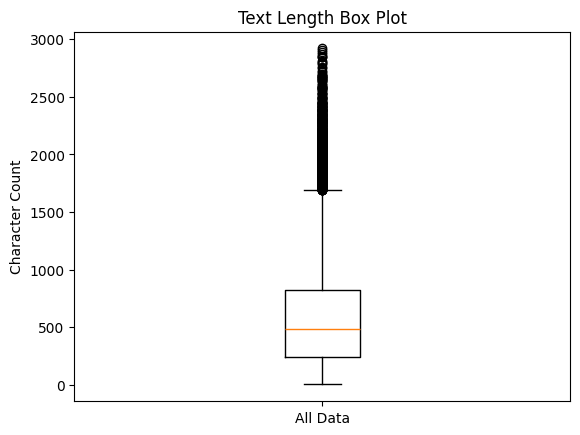

In [42]:
text_data = [df['text_length']]
plt.boxplot(text_data, labels=['All Data'])
plt.title('Text Length Box Plot')
plt.ylabel('Character Count')

In [43]:
summary_stats = []
for split_name, split_df in [( "All Data", df)]:
    stats = {
        'Split': split_name,
        'Total Posts': len(split_df),
        'Unique Users': split_df['user_id'].nunique(),
        'Date Range (Days)': (split_df['timestamp'].max() - split_df['timestamp'].min()).days,
        'Avg Posts/User': round(len(split_df) / split_df['user_id'].nunique(), 2),
        'Avg Text Length': round(split_df['text_length'].mean(), 1),
        'Posts (%)': round(split_df['is_post'].sum() / len(split_df) * 100, 1),
        'Comments (%)': round((~split_df['is_post']).sum() / len(split_df) * 100, 1)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

   Split  Total Posts  Unique Users  Date Range (Days)  Avg Posts/User  Avg Text Length  Posts (%)  Comments (%)
All Data        42384          6318               2385            6.71            588.6       15.6          84.4


In [44]:
df.head()

author  post_id comment_id  timestamp         category  \
39118  CatLadyInTraining     4921          0 2019-01-06  PTSD and trauma   
24                 Croix     4921          1 2019-01-06  PTSD and trauma   
19537         White_Rose     4921          2 2019-01-07  PTSD and trauma   
28533            PamelaR     4921          3 2019-01-07  PTSD and trauma   
40030             RM2926     5307          0 2019-01-08  PTSD and trauma   

                                                   title  \
39118  Emotional deprivation/ childhood emotional neg...   
24                                                  None   
19537                                               None   
28533                                               None   
40030         Worried about the happiness of my children   

                                                    text  is_post  \
39118  Hello, this is my first post but I’ve been rea...     True   
24     Dear CatLadyInTraining~ Welcome here. I'd imag...    False   
19537  Dear CatladyInTraining First I want to welcome...    False   
28533  Hi CatLadyInTraining and welcome to our forums...    False   
40030  During my last pregnancy I had to deal with a ...     True   

            thread_owner  user_id  thread_owner_id  \
39118  CatLadyInTraining     5925             5925   
24     CatLadyInTraining     1006             5925   
19537  CatLadyInTraining     1442             5925   
28533  CatLadyInTraining     2863             5925   
40030             RM2926     6342             6342   

                                              clean_text    month  text_length  
39118  hello first post ive reading forum background ...  2019-01          917  
24     dear catladyintraining welcome imagine number ...  2019-01         1309  
19537  dear catladyintraining first want welcome foru...  2019-01         1311  
28533  catladyintraining welcome forum croix mary giv...  2019-01          937  
40030  last pregnancy deal series traumatic event rea...  2019-01         1320

### 2.2 Extract LIWC-style features (via Empath)
Interpretable, lexicon-based emotional dimensions. We will apply to the training dataset to compare which feature extraction has the higher impact. Due to the limitation of Empath, we will add custom categories to Empath.

In [45]:
# ! pip install empath
from empath import Empath
lexicon = Empath()

# Apply Empath to each cleaned post
empath_out = df[["user_id", "thread_owner_id", "post_id", "comment_id", "is_post", "timestamp", "category", "clean_text"]].copy()
empath_out['liwc_empath'] = empath_out['clean_text'].apply(lambda x: lexicon.analyze(x, normalize=True))

# Convert timestamp to datetime format
empath_out['date'] = pd.to_datetime(empath_out['timestamp'])
empath_out['week'] = empath_out['date'].dt.to_period('W').apply(lambda r: r.start_time)

print(empath_out['liwc_empath'].head())

39118    {'help': 0.04838709677419355, 'office': 0.0161...
24       {'help': 0.022099447513812154, 'office': 0.016...
19537    {'help': 0.021052631578947368, 'office': 0.0, ...
28533    {'help': 0.015625, 'office': 0.0, 'dance': 0.0...
40030    {'help': 0.01951219512195122, 'office': 0.0097...
Name: liwc_empath, dtype: object


In [46]:
empath_out['liwc_empath'].iloc[2]

{'help': 0.021052631578947368,
 'office': 0.0,
 'dance': 0.0,
 'money': 0.005263157894736842,
 'wedding': 0.010526315789473684,
 'domestic_work': 0.010526315789473684,
 'sleep': 0.0,
 'medical_emergency': 0.0,
 'cold': 0.005263157894736842,
 'hate': 0.015789473684210527,
 'cheerfulness': 0.005263157894736842,
 'aggression': 0.005263157894736842,
 'occupation': 0.005263157894736842,
 'envy': 0.0,
 'anticipation': 0.0,
 'family': 0.02631578947368421,
 'vacation': 0.0,
 'crime': 0.005263157894736842,
 'attractive': 0.0,
 'masculine': 0.0,
 'prison': 0.005263157894736842,
 'health': 0.005263157894736842,
 'pride': 0.0,
 'dispute': 0.005263157894736842,
 'nervousness': 0.015789473684210527,
 'government': 0.0,
 'weakness': 0.005263157894736842,
 'horror': 0.005263157894736842,
 'swearing_terms': 0.0,
 'leisure': 0.0,
 'suffering': 0.015789473684210527,
 'royalty': 0.0,
 'wealthy': 0.0,
 'tourism': 0.0,
 'furniture': 0.0,
 'school': 0.005263157894736842,
 'magic': 0.0,
 'beach': 0.0,
 'journ

In [47]:
empath_out['liwc_empath'].apply(type).value_counts()

liwc_empath
<class 'dict'>    42384
Name: count, dtype: int64

In [48]:
empath_out['liwc_empath'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

0

In [49]:
empath_out.head()

user_id  thread_owner_id  post_id comment_id  is_post  timestamp  \
39118     5925             5925     4921          0     True 2019-01-06   
24        1006             5925     4921          1    False 2019-01-06   
19537     1442             5925     4921          2    False 2019-01-07   
28533     2863             5925     4921          3    False 2019-01-07   
40030     6342             6342     5307          0     True 2019-01-08   

              category                                         clean_text  \
39118  PTSD and trauma  hello first post ive reading forum background ...   
24     PTSD and trauma  dear catladyintraining welcome imagine number ...   
19537  PTSD and trauma  dear catladyintraining first want welcome foru...   
28533  PTSD and trauma  catladyintraining welcome forum croix mary giv...   
40030  PTSD and trauma  last pregnancy deal series traumatic event rea...   

                                             liwc_empath       date       week  
39118  {'help': 0.04838709677419355, 'office': 0.0161... 2019-01-06 2018-12-31  
24     {'help': 0.022099447513812154, 'office': 0.016... 2019-01-06 2018-12-31  
19537  {'help': 0.021052631578947368, 'office': 0.0, ... 2019-01-07 2019-01-07  
28533  {'help': 0.015625, 'office': 0.0, 'dance': 0.0... 2019-01-07 2019-01-07  
40030  {'help': 0.01951219512195122, 'office': 0.0097... 2019-01-08 2019-01-07

In [50]:
empath_out.isna().sum()

user_id            0
thread_owner_id    0
post_id            0
comment_id         0
is_post            0
timestamp          0
category           0
clean_text         0
liwc_empath        0
date               0
week               0
dtype: int64

In [51]:
empath_out.shape

(42384, 11)

In [52]:
from pandas import json_normalize

empath_norm = json_normalize(empath_out['liwc_empath']).reset_index(drop=True)
empath_norm.columns = [f"empath_{col}" for col in empath_norm.columns]

empath_out = empath_out.drop(columns=['liwc_empath']).reset_index(drop=True)

empath_out = pd.concat([empath_out, empath_norm], axis=1)


In [53]:
empath_out.head()

user_id  thread_owner_id  post_id comment_id  is_post  timestamp  \
0     5925             5925     4921          0     True 2019-01-06   
1     1006             5925     4921          1    False 2019-01-06   
2     1442             5925     4921          2    False 2019-01-07   
3     2863             5925     4921          3    False 2019-01-07   
4     6342             6342     5307          0     True 2019-01-08   

          category                                         clean_text  \
0  PTSD and trauma  hello first post ive reading forum background ...   
1  PTSD and trauma  dear catladyintraining welcome imagine number ...   
2  PTSD and trauma  dear catladyintraining first want welcome foru...   
3  PTSD and trauma  catladyintraining welcome forum croix mary giv...   
4  PTSD and trauma  last pregnancy deal series traumatic event rea...   

        date       week  ...  empath_giving  empath_contentment  \
0 2019-01-06 2018-12-31  ...       0.032258            0.024194   
1 2019-01-06 2018-12-31  ...       0.005525            0.016575   
2 2019-01-07 2019-01-07  ...       0.026316            0.010526   
3 2019-01-07 2019-01-07  ...       0.007812            0.039062   
4 2019-01-08 2019-01-07  ...       0.004878            0.014634   

   empath_writing  empath_rural  empath_positive_emotion  empath_musical  \
0        0.008065      0.000000                 0.048387        0.000000   
1        0.000000      0.000000                 0.055249        0.005525   
2        0.005263      0.005263                 0.042105        0.000000   
3        0.007812      0.000000                 0.117188        0.000000   
4        0.000000      0.000000                 0.014634        0.004878   

   empath_crisis  empath_depression  empath_anxiety  empath_therapy  
0       0.040323           0.040323        0.008065        0.032258  
1       0.044199           0.016575        0.000000        0.044199  
2       0.005263           0.021053        0.010526        0.005263  
3       0.000000           0.054688        0.007812        0.007812  
4       0.004878           0.039024        0.009756        0.004878  

[5 rows x 208 columns]

In [54]:
empath_out.isna().sum()

user_id              0
thread_owner_id      0
post_id              0
comment_id           0
is_post              0
                    ..
empath_musical       0
empath_crisis        0
empath_depression    0
empath_anxiety       0
empath_therapy       0
Length: 208, dtype: int64

In [ ]:
empath_cols = [col for col in empath_out.columns if col.startswith('empath_')]
print(f"Starting with {len(empath_cols)} Empath features")

# Check if emotional patterns are consistent over time
monthly_emotions = empath_out.groupby(empath_out['timestamp'].dt.to_period('M'))[empath_cols].mean()
temporal_stability = monthly_emotions.std() / monthly_emotions.mean() 
stable_features = temporal_stability[temporal_stability < 0.5].index
print(f"Temporally stable features: {len(stable_features)}/{len(empath_cols)}")

Starting with 198 Empath features
Temporally stable features: 186/198


In [56]:
empath_variance = empath_out[empath_cols].var()
low_variance_features = empath_variance[empath_variance < 0.005].index
useful_empath_cols = empath_variance[empath_variance >= 0.0005].index.tolist()

print(f"Removed {len(low_variance_features)} low-variance features")
print(f"Keeping {len(useful_empath_cols)} features with meaningful variance")

core_mental_health_features = [
    # Your custom categories (these should definitely be kept)
    'empath_anxiety', 'empath_depression', 'empath_therapy', 'empath_crisis',
    
    # Core emotional categories
    'empath_positive_emotion', 'empath_negative_emotion',
    'empath_sadness', 'empath_fear', 'empath_anger', 'empath_joy',
    
    # Mental health indicators
    'empath_pain', 'empath_suffering', 'empath_healing', 'empath_help',
    'empath_medical_emergency', 'empath_suicide',
    
    # Social/behavioral indicators  
    'empath_family', 'empath_friends', 'empath_communication',
    
    # Cognitive/emotional processes
    'empath_confusion', 'empath_optimism', 'empath_emotional'
]

core_features = [f for f in core_mental_health_features if f in useful_empath_cols]
print(f"Identified {len(core_features)} core mental health features")

Removed 198 low-variance features
Keeping 32 features with meaningful variance
Identified 14 core mental health features


In [57]:
useful_empath_cols

['empath_help',
 'empath_medical_emergency',
 'empath_hate',
 'empath_family',
 'empath_health',
 'empath_nervousness',
 'empath_suffering',
 'empath_optimism',
 'empath_fear',
 'empath_business',
 'empath_internet',
 'empath_body',
 'empath_violence',
 'empath_love',
 'empath_communication',
 'empath_hearing',
 'empath_speaking',
 'empath_listen',
 'empath_phone',
 'empath_work',
 'empath_sadness',
 'empath_shame',
 'empath_pain',
 'empath_negative_emotion',
 'empath_messaging',
 'empath_friends',
 'empath_children',
 'empath_giving',
 'empath_contentment',
 'empath_positive_emotion',
 'empath_depression',
 'empath_therapy']

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Create category labels for feature selection
category_mapping = {'Anxiety': 0, 'Depression': 1, 'PTSD and trauma': 2, 'Suicidal thoughts and self-harm': 3}
empath_out['temp_category_label'] = empath_out['category'].map(category_mapping)

X_empath = empath_out[useful_empath_cols].fillna(0)
y = empath_out['temp_category_label']

# Select top discriminative features if we have more than 15
if len(useful_empath_cols) > 15:
    selector_f = SelectKBest(score_func=f_classif, k=15)
    X_selected_f = selector_f.fit_transform(X_empath, y)
    selected_features_f = selector_f.get_feature_names_out(useful_empath_cols)
    
    # Combine core + discriminative features
    final_empath_features = list(set(core_features) | set(selected_features_f))
else:
    final_empath_features = useful_empath_cols

print(f"Final optimized feature set: {len(final_empath_features)} features")

# Update empath_out to use only optimized features
metadata_cols = ['user_id', 'post_id', 'comment_id', 'is_post', 'timestamp', 'category', 'clean_text', 'date', 'week']
empath_out = empath_out[metadata_cols + final_empath_features].copy()
empath_cols = final_empath_features

print(f"Empath optimization complete: {len(empath_cols)} features")

empath_out = empath_out.drop(columns=['temp_category_label'], errors='ignore')

Final optimized feature set: 23 features
Empath optimization complete: 23 features


In [59]:
# Check custom categories specifically
new_categories = ['empath_anxiety', 'empath_depression', 'empath_therapy', 'empath_crisis']
found_new = [col for col in new_categories if col in empath_out.columns]

if found_new:
    print(f"Custom Category Activity:")
    for cat in found_new:
        activity = (empath_out[cat] > 0).sum()
        avg_score = empath_out[cat].mean()
        print(f"  {cat.replace('empath_', ''):<12} Active in {activity} threads (avg: {avg_score:.4f})")

Custom Category Activity:
  depression   Active in 28716 threads (avg: 0.0247)
  therapy      Active in 20425 threads (avg: 0.0149)


In [60]:
print(empath_out[empath_cols].head())

   empath_love  empath_suffering  empath_phone  empath_help  empath_pain  \
0     0.040323          0.056452      0.008065     0.048387     0.032258   
1     0.016575          0.027624      0.011050     0.022099     0.027624   
2     0.026316          0.015789      0.010526     0.021053     0.031579   
3     0.039062          0.054688      0.000000     0.015625     0.039062   
4     0.014634          0.004878      0.000000     0.019512     0.034146   

   empath_sadness  empath_therapy  empath_fear  empath_negative_emotion  \
0        0.080645        0.032258     0.032258                 0.016129   
1        0.022099        0.044199     0.016575                 0.027624   
2        0.021053        0.005263     0.010526                 0.047368   
3        0.085938        0.007812     0.062500                 0.007812   
4        0.000000        0.004878     0.000000                 0.053659   

   empath_optimism  ...  empath_friends  empath_children  \
0         0.024194  ...        0

In [61]:
# Group by user and week to create LSTM-ready input
empath_cols = [col for col in empath_out.columns if col.startswith('empath_')]

empath_weekly = (
    empath_out.groupby(['user_id', 'week'])[empath_cols]
    .mean()
    .reset_index()
)

In [62]:
empath_weekly.head()

user_id       week  empath_love  empath_suffering  empath_phone  \
0     1001 2025-07-14     0.022565          0.049998      0.021376   
1     1002 2025-07-07     0.000000          0.000000      0.071429   
2     1002 2025-07-14     0.039542          0.005882      0.011765   
3     1003 2025-07-14     0.020833          0.020833      0.000000   
4     1004 2023-10-16     0.021573          0.007937      0.017605   

   empath_help  empath_pain  empath_sadness  empath_therapy  empath_fear  ...  \
0     0.033072     0.045340        0.071374        0.039129     0.073599  ...   
1     0.071429     0.000000        0.000000        0.000000     0.000000  ...   
2     0.000000     0.027778        0.000000        0.017647     0.005882  ...   
3     0.020833     0.062500        0.062500        0.000000     0.041667  ...   
4     0.017605     0.037446        0.011905        0.010029     0.011905  ...   

   empath_friends  empath_children  empath_communication  empath_violence  \
0        0.015319         0.009471              0.024999         0.026189   
1        0.000000         0.071429              0.071429         0.000000   
2        0.011765         0.023529              0.005882         0.033660   
3        0.020833         0.000000              0.000000         0.020833   
4        0.006061         0.003968              0.068543         0.041053   

   empath_positive_emotion  empath_listen  empath_contentment  \
0                 0.034470       0.003623            0.035869   
1                 0.071429       0.071429            0.000000   
2                 0.005882       0.000000            0.027778   
3                 0.020833       0.020833            0.041667   
4                 0.033694       0.010029            0.025541   

   empath_nervousness  empath_depression  empath_health  
0            0.072564           0.028413       0.058071  
1            0.000000           0.000000       0.000000  
2            0.027778           0.033660       0.029412  
3            0.083333           0.062500       0.020833  
4            0.063564           0.003968       0.016089  

[5 rows x 25 columns]

In [63]:
empath_out = pd.concat([empath_out], axis=1)
empath_out.to_csv("empath_data.csv", index=False)
empath_weekly.to_csv("empath_weekly.csv", index=False)

Here we save empath features to csv, we will use it for the future work.

In [64]:
empath_df = pd.read_csv("empath_data.csv")
empath_weekly = pd.read_csv("empath_weekly.csv")
empath_df.head()

user_id  post_id  comment_id  is_post   timestamp         category  \
0     5925     4921           0     True  2019-01-06  PTSD and trauma   
1     1006     4921           1    False  2019-01-06  PTSD and trauma   
2     1442     4921           2    False  2019-01-07  PTSD and trauma   
3     2863     4921           3    False  2019-01-07  PTSD and trauma   
4     6342     5307           0     True  2019-01-08  PTSD and trauma   

                                          clean_text        date        week  \
0  hello first post ive reading forum background ...  2019-01-06  2018-12-31   
1  dear catladyintraining welcome imagine number ...  2019-01-06  2018-12-31   
2  dear catladyintraining first want welcome foru...  2019-01-07  2019-01-07   
3  catladyintraining welcome forum croix mary giv...  2019-01-07  2019-01-07   
4  last pregnancy deal series traumatic event rea...  2019-01-08  2019-01-07   

   empath_love  ...  empath_friends  empath_children  empath_communication  \
0     0.040323  ...        0.024194         0.040323              0.000000   
1     0.016575  ...        0.005525         0.005525              0.016575   
2     0.026316  ...        0.015789         0.036842              0.026316   
3     0.039062  ...        0.023438         0.023438              0.023438   
4     0.014634  ...        0.000000         0.156098              0.000000   

   empath_violence  empath_positive_emotion  empath_listen  \
0         0.016129                 0.048387       0.000000   
1         0.022099                 0.055249       0.016575   
2         0.021053                 0.042105       0.010526   
3         0.023438                 0.117188       0.015625   
4         0.019512                 0.014634       0.009756   

   empath_contentment  empath_nervousness  empath_depression  empath_health  
0            0.024194            0.040323           0.040323       0.048387  
1            0.016575            0.016575           0.016575       0.049724  
2            0.010526            0.015789           0.021053       0.005263  
3            0.039062            0.062500           0.054688       0.007812  
4            0.014634            0.024390           0.039024       0.014634  

[5 rows x 32 columns]

In [65]:
empath_weekly.head()

user_id        week  empath_love  empath_suffering  empath_phone  \
0     1001  2025-07-14     0.022565          0.049998      0.021376   
1     1002  2025-07-07     0.000000          0.000000      0.071429   
2     1002  2025-07-14     0.039542          0.005882      0.011765   
3     1003  2025-07-14     0.020833          0.020833      0.000000   
4     1004  2023-10-16     0.021573          0.007937      0.017605   

   empath_help  empath_pain  empath_sadness  empath_therapy  empath_fear  ...  \
0     0.033072     0.045340        0.071374        0.039129     0.073599  ...   
1     0.071429     0.000000        0.000000        0.000000     0.000000  ...   
2     0.000000     0.027778        0.000000        0.017647     0.005882  ...   
3     0.020833     0.062500        0.062500        0.000000     0.041667  ...   
4     0.017605     0.037446        0.011905        0.010029     0.011905  ...   

   empath_friends  empath_children  empath_communication  empath_violence  \
0        0.015319         0.009471              0.024999         0.026189   
1        0.000000         0.071429              0.071429         0.000000   
2        0.011765         0.023529              0.005882         0.033660   
3        0.020833         0.000000              0.000000         0.020833   
4        0.006061         0.003968              0.068543         0.041053   

   empath_positive_emotion  empath_listen  empath_contentment  \
0                 0.034470       0.003623            0.035869   
1                 0.071429       0.071429            0.000000   
2                 0.005882       0.000000            0.027778   
3                 0.020833       0.020833            0.041667   
4                 0.033694       0.010029            0.025541   

   empath_nervousness  empath_depression  empath_health  
0            0.072564           0.028413       0.058071  
1            0.000000           0.000000       0.000000  
2            0.027778           0.033660       0.029412  
3            0.083333           0.062500       0.020833  
4            0.063564           0.003968       0.016089  

[5 rows x 25 columns]

In [66]:
# Select only empath columns
empath_cols = [col for col in empath_df.columns if col.startswith('empath_')]
top_empath = empath_df[empath_cols].mean().sort_values(ascending=False).head(10)
print(top_empath)

empath_positive_emotion    0.039583
empath_negative_emotion    0.032519
empath_nervousness         0.030004
empath_health              0.029511
empath_pain                0.029039
empath_communication       0.029029
empath_optimism            0.026412
empath_sadness             0.024785
empath_depression          0.024675
empath_violence            0.023404
dtype: float64


In [67]:
empath_df.shape

(42384, 32)

<Axes: title={'center': 'Top 10 Empath Categories'}>

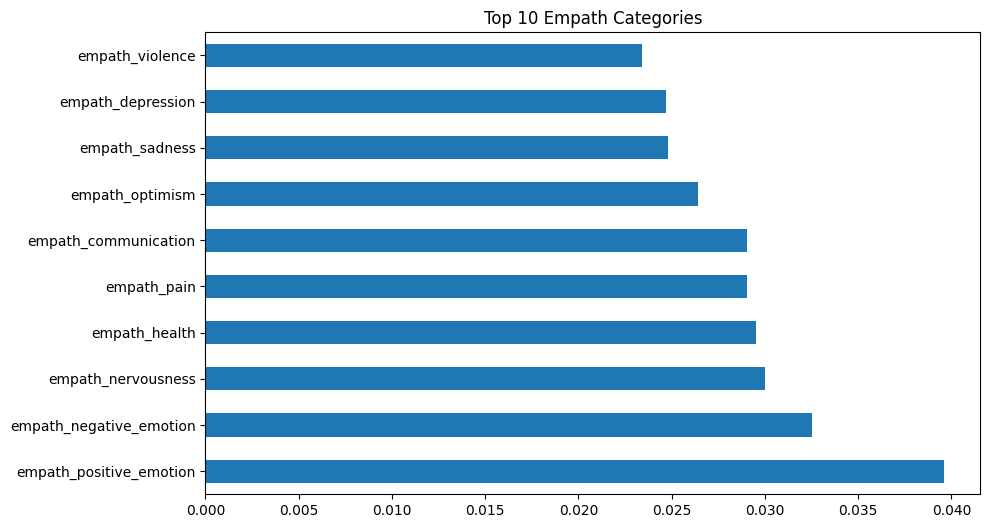

In [68]:
top_empath.plot(kind='barh', figsize=(10,6), title="Top 10 Empath Categories")

<Axes: title={'center': 'Top Empath Emotions Over Time'}, xlabel='date'>

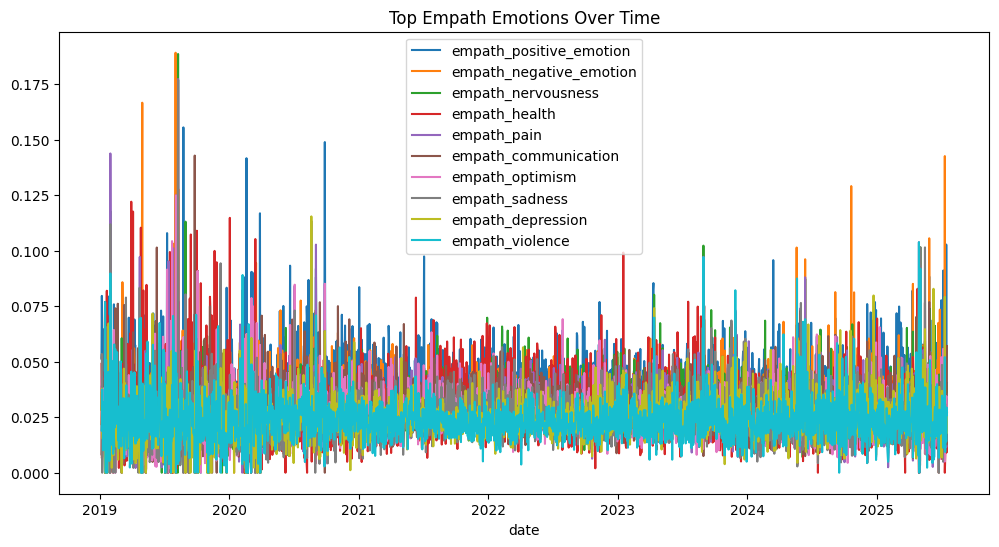

In [69]:
empath_df['date'] = pd.to_datetime(empath_df['timestamp']).dt.date
daily_emotions = empath_df.groupby('date')[top_empath.index].mean()

daily_emotions.plot(figsize=(12,6), title="Top Empath Emotions Over Time")

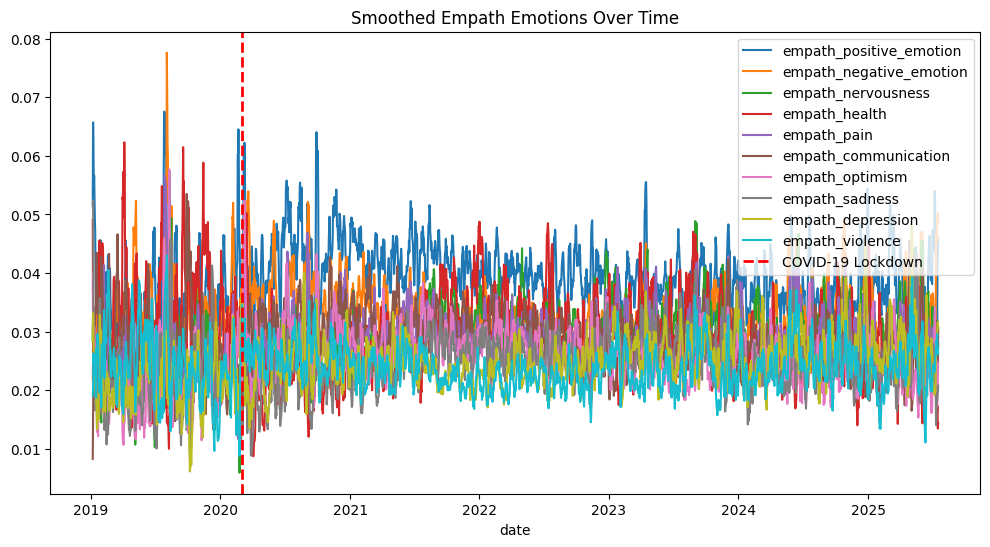

In [70]:
smoothed = daily_emotions.rolling(window=7, min_periods=1).mean()
smoothed.plot(figsize=(12,6), title="Smoothed Empath Emotions Over Time")

plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', linewidth=2, label='COVID-19 Lockdown')
plt.legend()

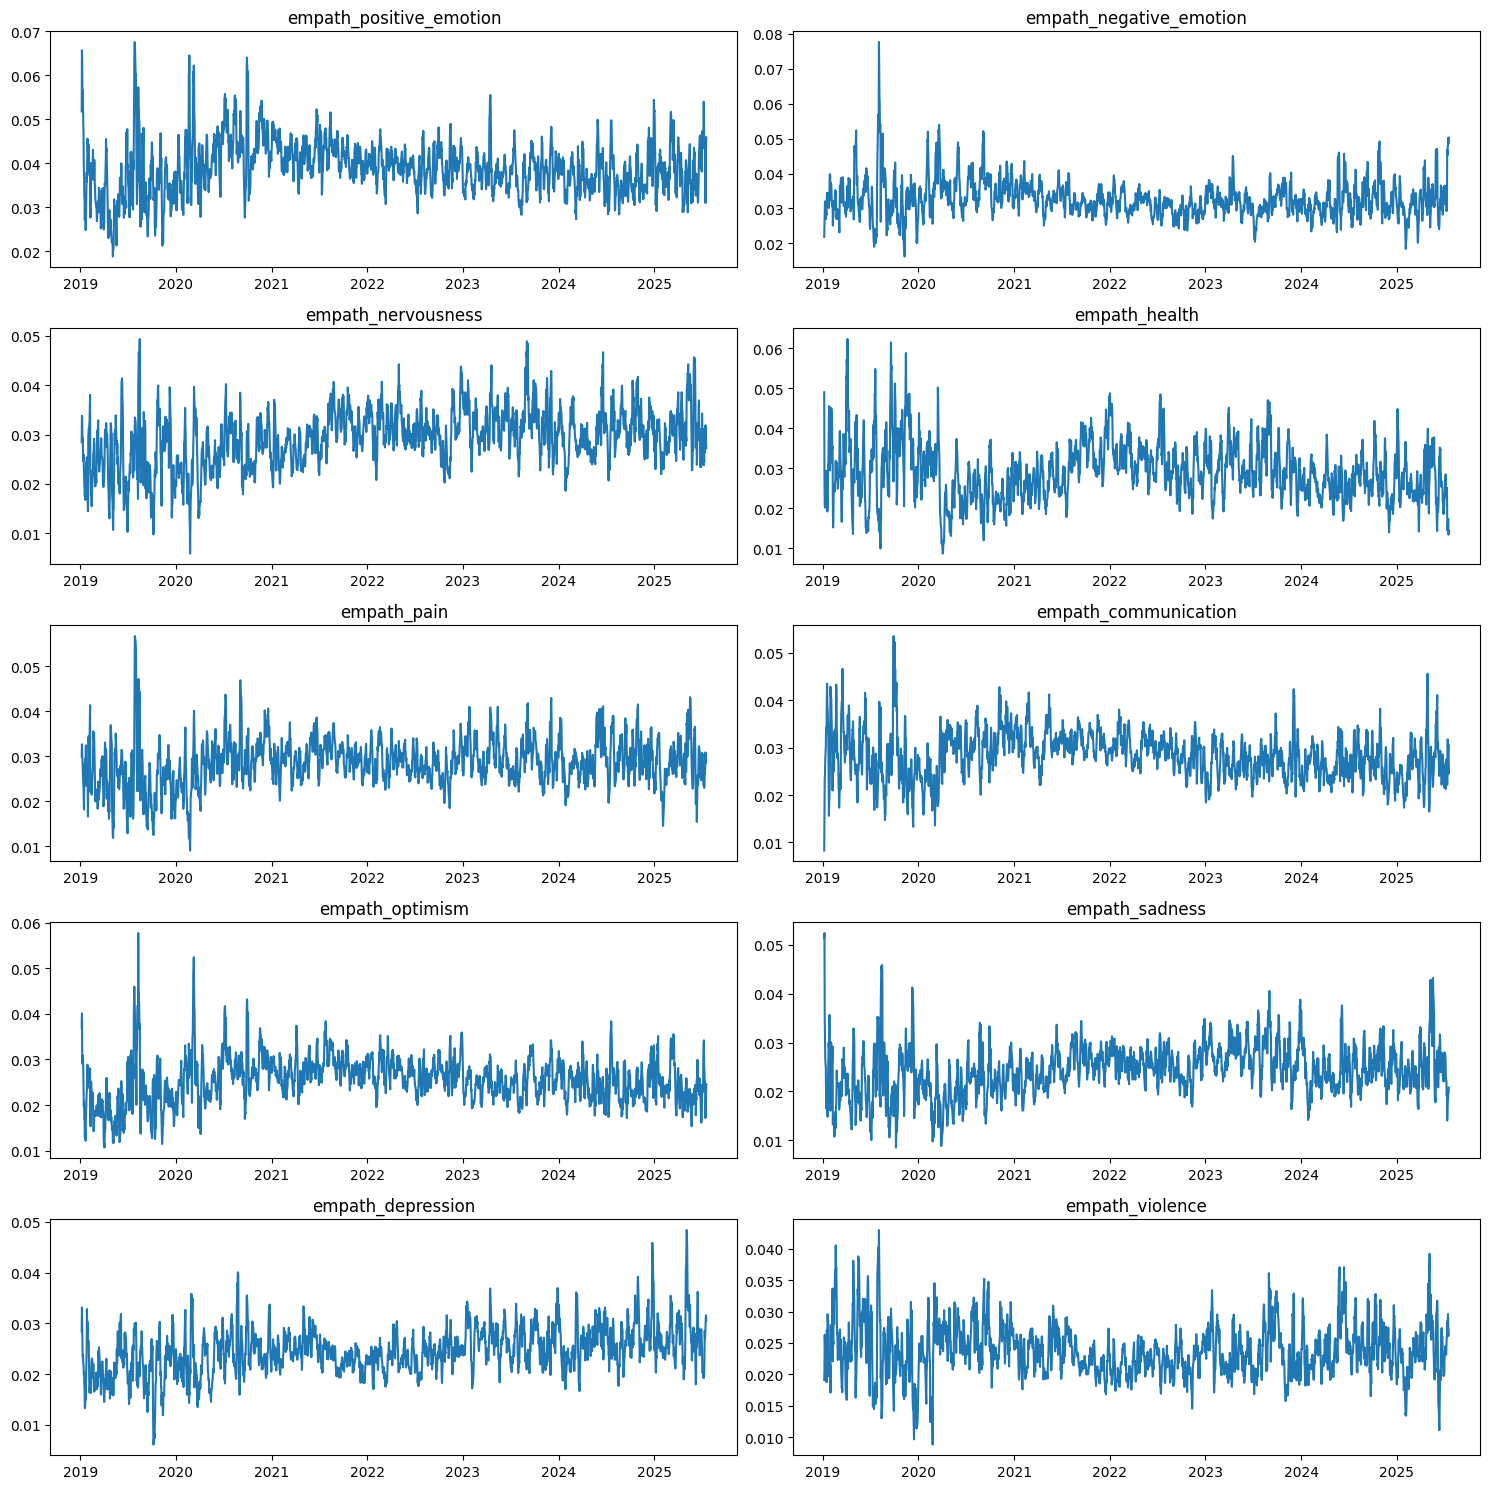

In [71]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(top_empath.index):
    axs[i].plot(smoothed[col])
    axs[i].set_title(col)

plt.tight_layout()

#### 2.2.1 Weekly analysis for Empath

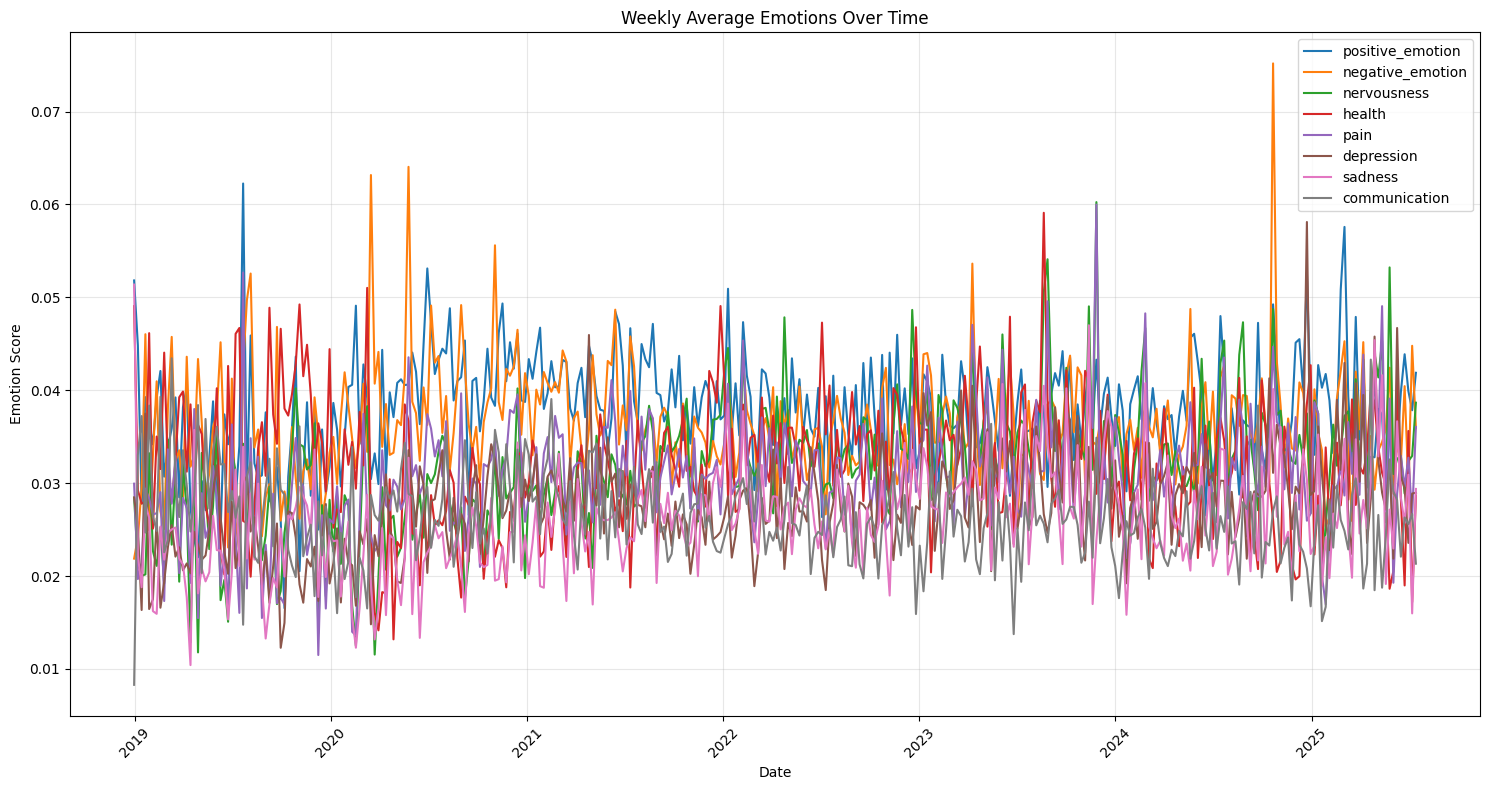

In [72]:
# Get top emotion categories
empath_cols = [col for col in empath_weekly.columns if col.startswith('empath_')]
top_emotions = empath_weekly[empath_cols].mean().sort_values(ascending=False).head(8)

# Convert week to datetime for plotting
empath_weekly['week'] = pd.to_datetime(empath_weekly['week'])
weekly_avg = empath_weekly.groupby('week')[top_emotions.index].mean()

# Plot top emotions over time
plt.figure(figsize=(15, 8))
plt.plot(weekly_avg.index, weekly_avg.values)
plt.title('Weekly Average Emotions Over Time')
plt.xlabel('Date')
plt.ylabel('Emotion Score')
plt.legend([e.replace('empath_', '') for e in top_emotions.index], loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

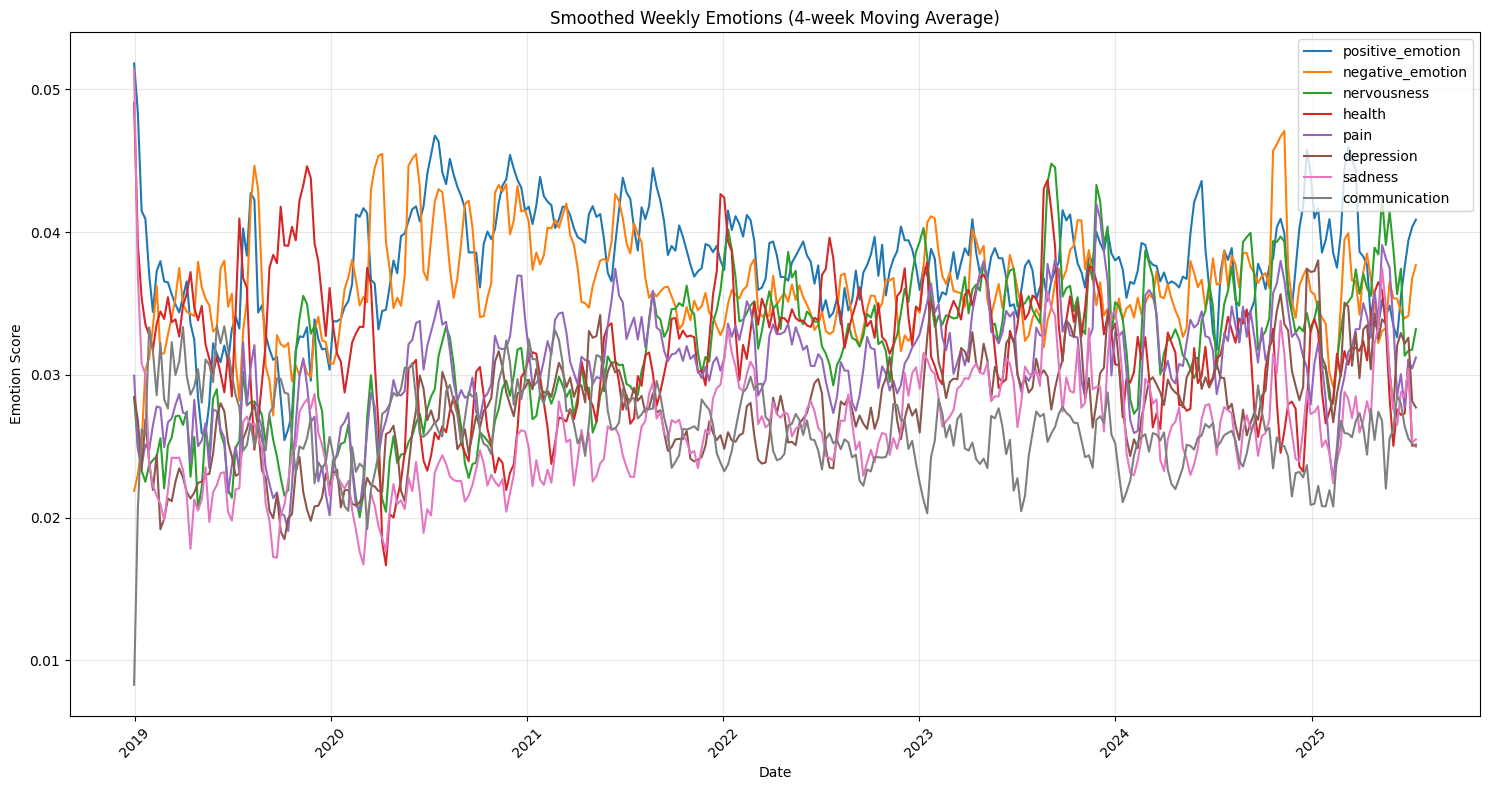

In [73]:
smoothed = weekly_avg.rolling(window=4, min_periods=1).mean()

plt.figure(figsize=(15, 8))
plt.plot(smoothed.index, smoothed.values)
plt.title('Smoothed Weekly Emotions (4-week Moving Average)')
plt.xlabel('Date')
plt.ylabel('Emotion Score')
plt.legend([e.replace('empath_', '') for e in top_emotions.index], loc='upper right', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

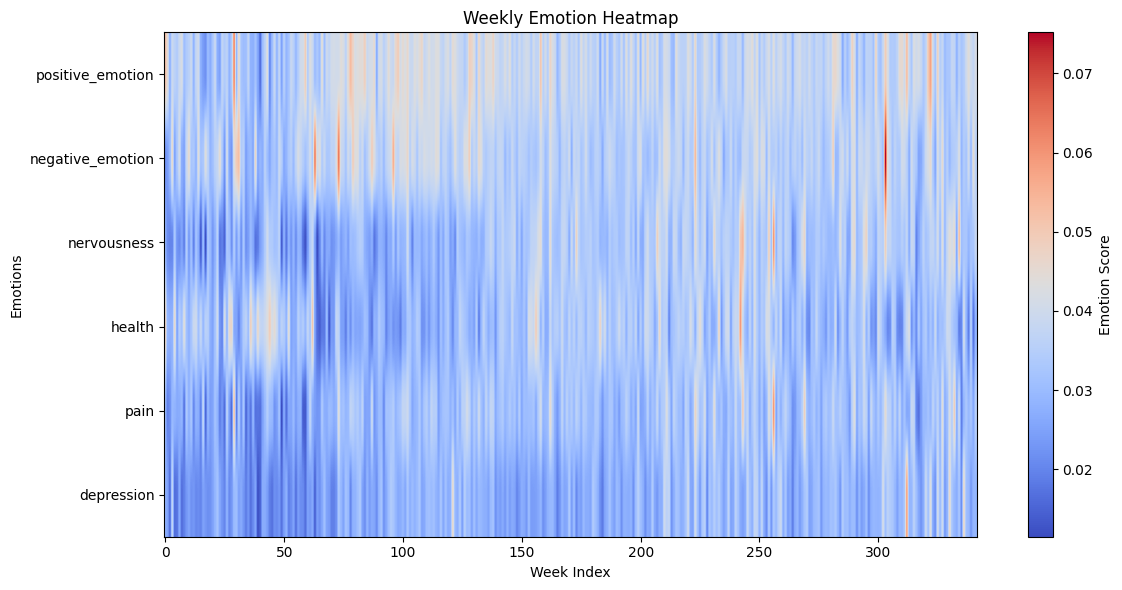

In [74]:
weekly_pivot = empath_weekly.groupby('week')[top_emotions.index[:6]].mean()

plt.figure(figsize=(12, 6))
plt.imshow(weekly_pivot.T, cmap='coolwarm', aspect='auto')
plt.title('Weekly Emotion Heatmap')
plt.xlabel('Week Index')
plt.ylabel('Emotions')
plt.yticks(range(len(top_emotions.index[:6])), [e.replace('empath_', '') for e in top_emotions.index[:6]])
plt.colorbar(label='Emotion Score')
plt.tight_layout()
plt.show()

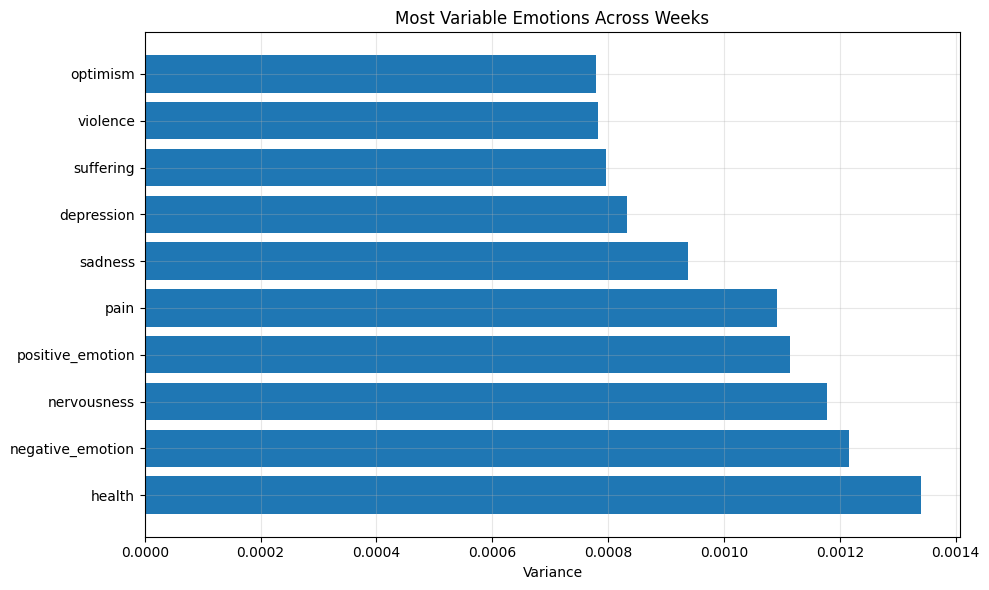

In [75]:
# Weekly emotion variance
emotion_variance = empath_weekly.groupby('week')[empath_cols].var().mean()
top_varying = emotion_variance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_varying)), top_varying.values)
plt.yticks(range(len(top_varying)), [e.replace('empath_', '') for e in top_varying.index])
plt.title('Most Variable Emotions Across Weeks')
plt.xlabel('Variance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

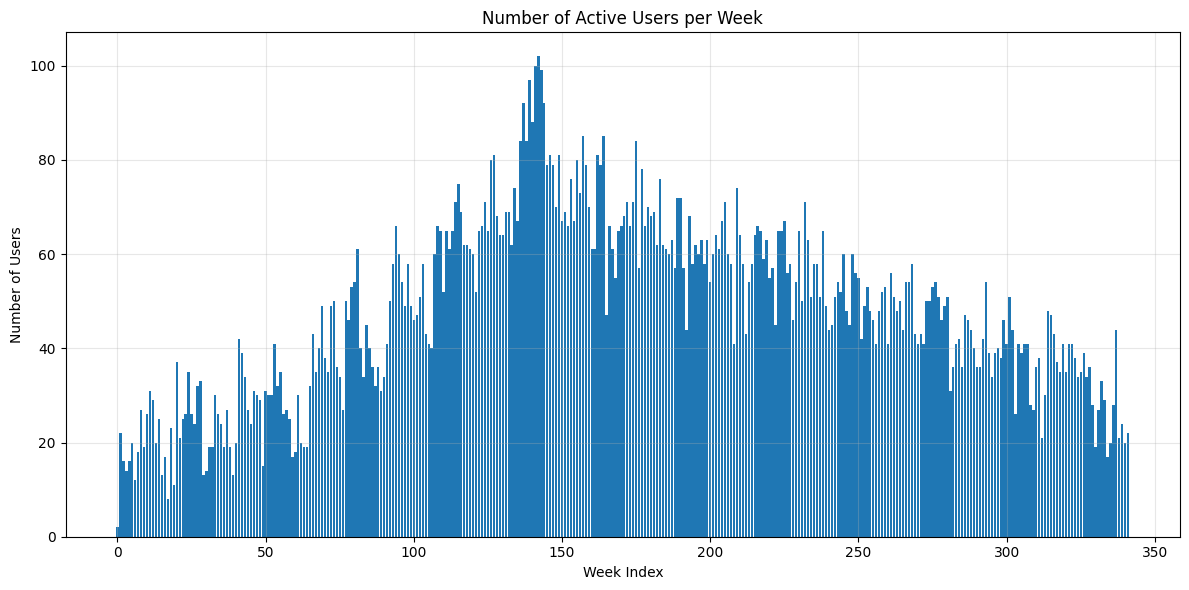

In [76]:
# User posting frequency by week
user_counts = empath_weekly.groupby('week')['user_id'].nunique()

plt.figure(figsize=(12, 6))
plt.bar(range(len(user_counts)), user_counts.values)
plt.title('Number of Active Users per Week')
plt.xlabel('Week Index')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

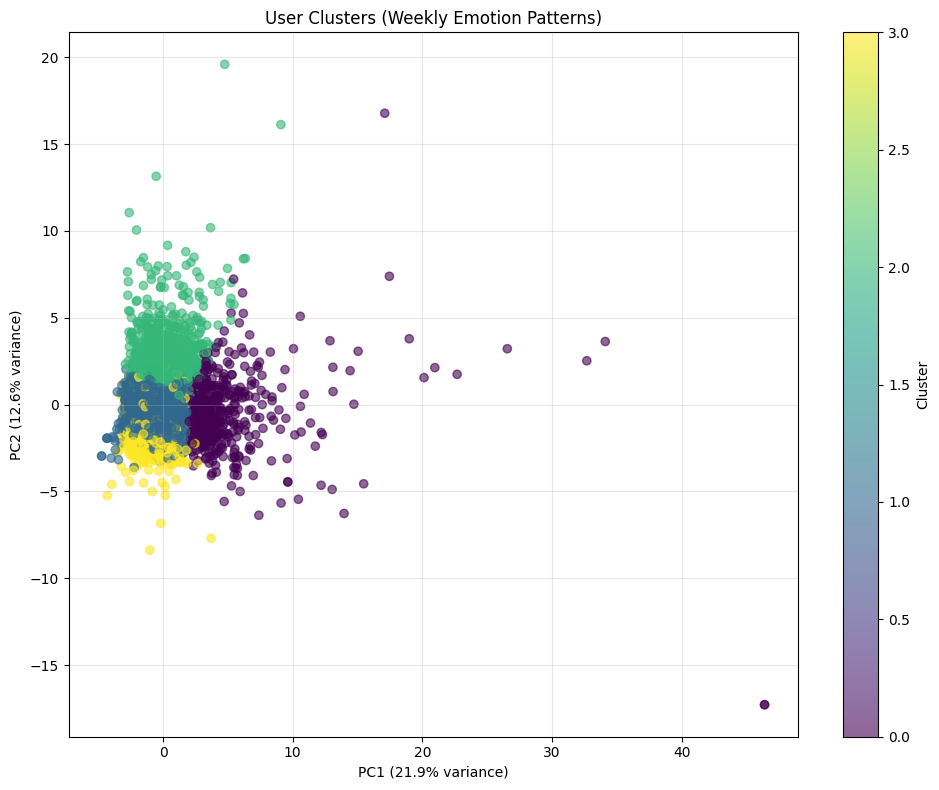

In [77]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Aggregate user data
user_profiles = empath_weekly.groupby('user_id')[empath_cols].mean()
scaler = StandardScaler()
user_profiles_scaled = scaler.fit_transform(user_profiles)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(user_profiles_scaled)

# Plot first two principal components
pca = PCA(n_components=2)
user_pca = pca.fit_transform(user_profiles_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(user_pca[:, 0], user_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('User Clusters (Weekly Emotion Patterns)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

User Clusters Analysis: Revealing Mental Health Communication Patterns
This visualization presents a comprehensive cluster analysis of mental health forum users based on their weekly emotional expression patterns, derived from 194+ Empath emotional categories. The plot reveals four distinct user groups, each represented by different colors in the viridis colormap, providing crucial insights into the diversity of mental health discourse patterns within the Beyond Blue community.

Color-Coded User Segments
The dark purple cluster (Cluster 0) represents users with lower overall emotional intensity and more neutral expression patterns. These individuals likely engage in factual discussions, provide informational support, or maintain more reserved communication styles. The dark blue cluster (Cluster 1) captures users experiencing high emotional distress, characterized by intense negative emotions such as anxiety, depression, and crisis-related expressions. The green/teal cluster (Cluster 2) encompasses users with moderate, balanced emotional patterns, representing the general community discourse that combines both positive and negative emotional expressions. Finally, the bright yellow cluster (Cluster 3) identifies users with more positive emotional patterns, likely including those in recovery phases, providing support to others, or discussing coping strategies and hope.

Key Revelations About Mental Health Communication
The clustering reveals several critical insights about mental health forum dynamics. First, the clear separation between clusters demonstrates that users don't express emotions randomly—instead, they fall into identifiable patterns that could inform targeted intervention strategies. The concentration of points in certain regions suggests that while emotional expression is complex (spanning 194+ dimensions), users naturally group into meaningful categories based on their communication patterns.

The low explained variance (5.5% for PC1 and 3.2% for PC2) is actually meaningful rather than problematic. This indicates that mental health expression is inherently multidimensional and cannot be oversimplified into basic categories. The complexity requires sophisticated analysis tools like the full 194-dimensional Empath space to capture the nuanced emotional landscape of mental health discourse.

Clinical and Research Implications
This clustering analysis is invaluable for our mental health early detection work in several ways. Personalized Intervention Design: Each cluster could receive tailored support—crisis intervention for high-distress users, engagement strategies for neutral users, and peer support opportunities for recovery-oriented users. Risk Stratification: The clustering helps identify users at different risk levels, enabling prioritized resource allocation and proactive outreach to high-risk individuals. Community Understanding: The analysis reveals the natural emotional ecosystem within mental health forums, showing how different user types contribute to community dynamics.

Temporal Monitoring: By tracking users' movement between clusters over time, researchers can identify patterns of deterioration or recovery, enabling early intervention when users transition toward higher-risk clusters. Feature Validation: The clear cluster separation validates our Empath-based feature extraction approach, demonstrating that linguistic patterns can effectively capture meaningful psychological differences.

Methodological Significance
This visualization bridges traditional psychological assessment with modern data science approaches. Unlike static surveys or clinical interviews, this method captures authentic, naturalistic emotional expression over time. The weekly aggregation reveals patterns that might be missed in snapshot assessments, while the clustering identifies user archetypes that could inform both automated systems and human moderators.

The plot demonstrates that mental health communities contain predictable subpopulations, each with distinct communication signatures. This finding supports the development of specialized algorithms for different user types, moving beyond one-size-fits-all approaches toward nuanced, personalized mental health technology. For our LLM-based early detection system, these clusters provide ground truth labels for training more sophisticated models that can recognize and respond appropriately to different emotional communication patterns within mental health contexts.



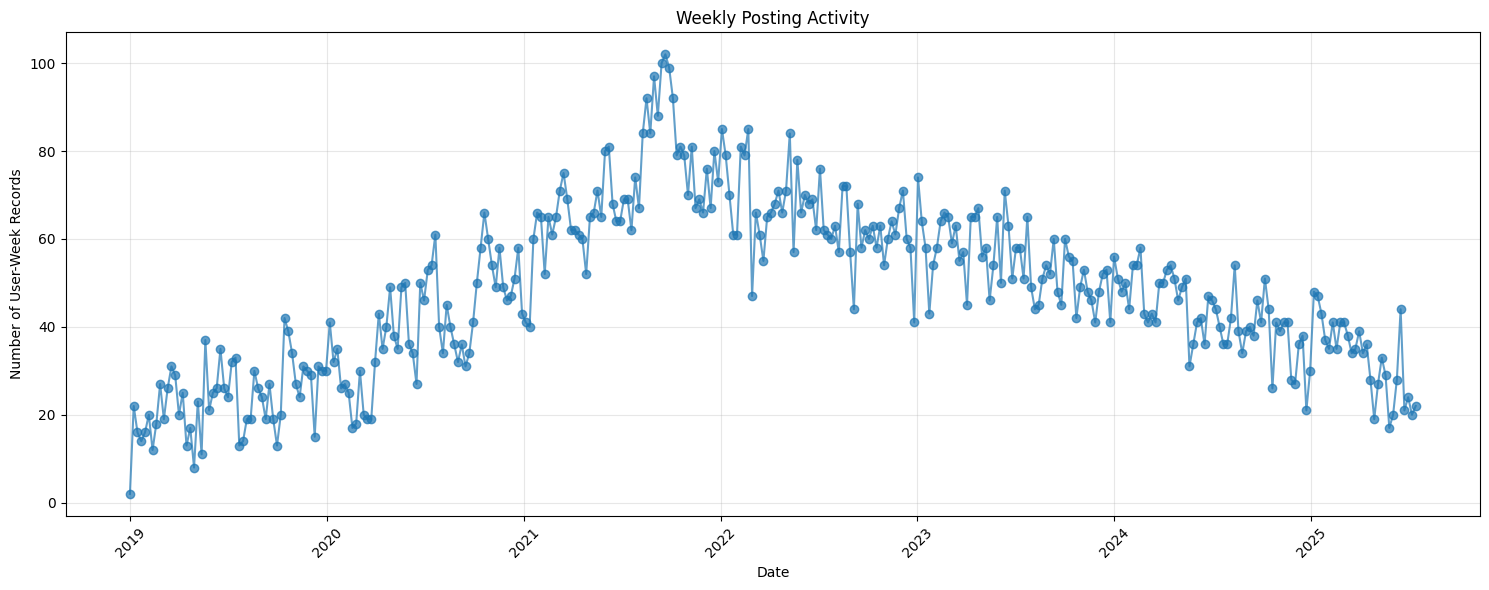

In [78]:
# Weekly posting activity
weekly_activity = empath_weekly.groupby('week').size()

plt.figure(figsize=(15, 6))
plt.plot(weekly_activity.index, weekly_activity.values, marker='o', alpha=0.7)
plt.title('Weekly Posting Activity')
plt.xlabel('Date')
plt.ylabel('Number of User-Week Records')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 2.2.2 Observe frequent user's emotion over time

In [79]:
# Find the most frequent users (by number of posts)
user_post_counts = empath_df.groupby('user_id').size().sort_values(ascending=False)
print("Top 10 most frequent users:")
print(user_post_counts.head(10))

Top 10 most frequent users:
user_id
1045    2608
1019    2026
1006    1419
1037    1255
1048    1161
1038    1051
1050     895
1116     813
1115     591
1137     445
dtype: int64


In [80]:
# Select a frequent user (e.g., the most frequent one)
frequent_user_id = user_post_counts.index[0]  # Most frequent user
print(f"\nSelected user: {frequent_user_id} with {user_post_counts.iloc[0]} threads")


Selected user: 1045 with 2608 threads


In [81]:
# Extract this user's data over time
user_data = empath_df[empath_df['user_id'] == frequent_user_id].copy()
user_data['timestamp'] = pd.to_datetime(user_data['timestamp'])
user_data = user_data.sort_values('timestamp')

In [82]:
emotion_categories = [ 
    'empath_positive_emotion', 'empath_negative_emotion'
]

available_emotions = [col for col in emotion_categories if col in user_data.columns]
print(f"\nAvailable emotion categories: {available_emotions}")


Available emotion categories: ['empath_positive_emotion', 'empath_negative_emotion']


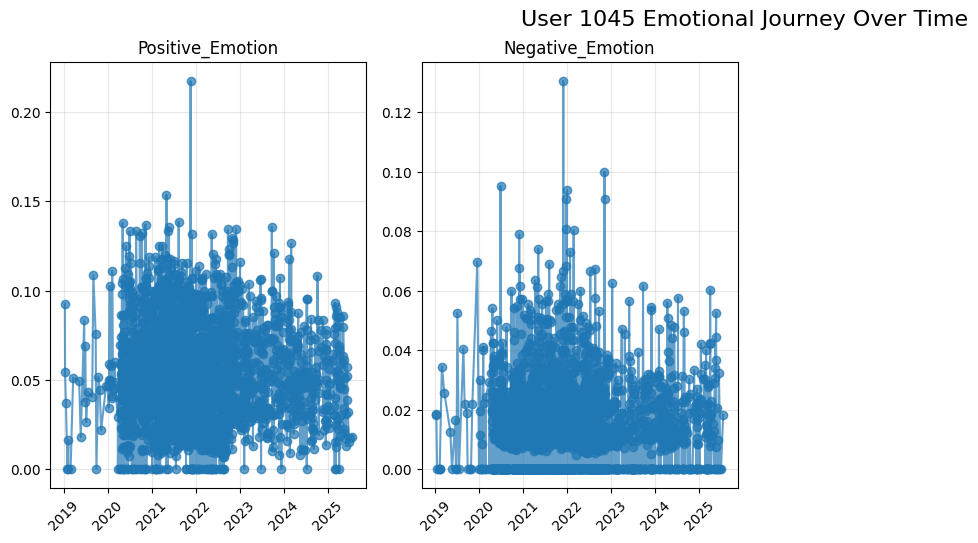

In [83]:
plt.figure(figsize=(15, 10))

# Plot each emotion category
for i, emotion in enumerate(available_emotions):
    plt.subplot(2, 4, i+1)
    plt.plot(user_data['timestamp'], user_data[emotion], marker='o', alpha=0.7)
    plt.title(f"{emotion.replace('empath_', '').title()}")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

plt.suptitle(f'User {frequent_user_id} Emotional Journey Over Time', fontsize=16)
plt.tight_layout()
plt.show()

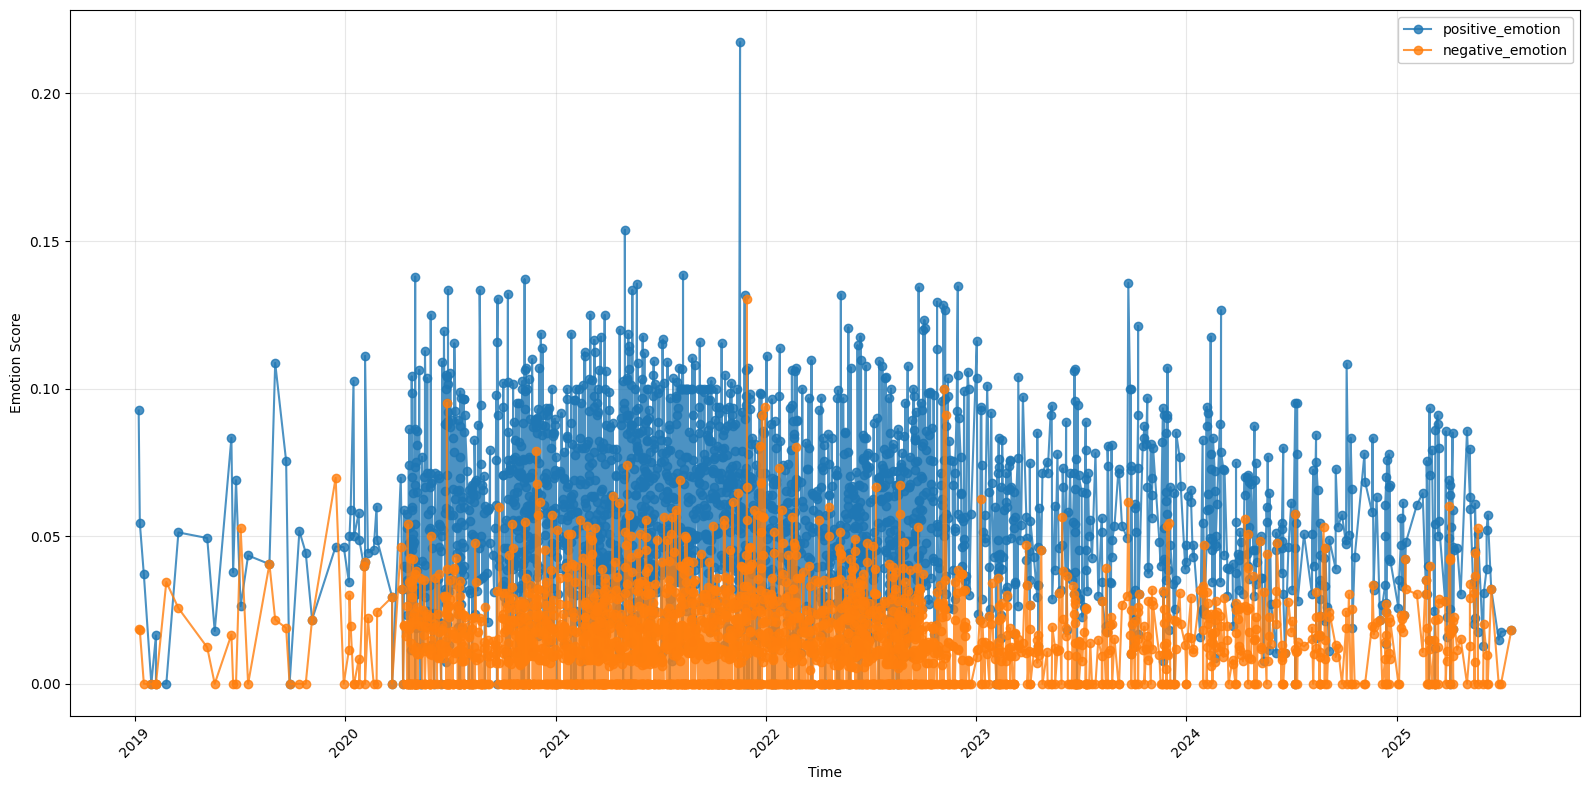

In [84]:
plt.figure(figsize=(16, 8))
for emotion in available_emotions[:5]:  # Plot top 5 emotions
    plt.plot(user_data['timestamp'], user_data[emotion], 
             label=emotion.replace('empath_', ''), marker='o', alpha=0.8)


plt.xlabel('Time')
plt.ylabel('Emotion Score')
plt.legend(loc='upper right', framealpha=1)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that Empath features simulates LIWC output and provides psychological signals extracted from the post. It numerically summarizes the content in terms of emotion, behavior, and social context.

### 2.3 DLATK 1-gram Feature Extraction
Surface-level linguistic patterns

In [85]:
# from sqlalchemy import create_engine
# from sqlalchemy import Integer, Text, DateTime
# import getpass

# export_train = train_df[['user_id', 'timestamp', 'clean_text']].copy()
# export_train.columns = ['user_id', 'datetime', 'message']
# export_train['message_id'] = export_train.index

# username = 'root'
# password = getpass.getpass("Enter MySQL password: ")
# database = 'dla_db'  
# host = 'localhost'

# engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database}")
# export_train.to_sql(
#     'beyond_blue_msgs',
#     engine,
#     if_exists='replace',
#     index=False,
#     dtype={
#         'user_id': Integer(),
#         'message': Text(),
#         'datetime': DateTime(),
#         'message_id': Integer()
#     }
# )

Due to DLATK only accept the data from My SQL,we use DLATK to get ngrams from here.

python dlatkInterface.py \
  -d dla_db \
  -t beyond_blue_msgs \
  -c user_id \
  --message_field message \
  --messageid_field message_id \
  --date_field datetime

python dlatkInterface.py \
  -d dla_db \
  -t beyond_blue_msgs \
  -c user_id \
  --message_field message \
  --messageid_field message_id \
  --date_field datetime \
  --add_ngrams

  python dlatkInterface.py \
  -d dla_db \
  -t beyond_blue_msgs \
  -c user_id \
  -f 'feat$1gram$beyond_blue_msgs$user_id' \
  --print_csv train_1gram.csv


In [86]:
# train_1gram = pd.read_csv("./train_1gram.csv")

In [87]:
# print(train_1gram.describe())
# print(train_1gram.info())

In [88]:
# train_1gram.rename(columns={'group_id': 'user_id'}, inplace=True)

# # Drop n-grams used by less than 1% of users
# min_user_count = int(len(train_1gram) * 0.01)
# train_1gram = train_1gram.loc[:, (train_1gram != 0).sum(axis=0) > min_user_count]

In [89]:
# train_1gram.head()

In [90]:
# train_1gram.shape

In [91]:
# ngram_totals = train_1gram.drop(columns=['user_id']).sum().sort_values(ascending=False)

# # Plot top 20
# top_20 = ngram_totals.head(20)
# plt.figure(figsize=(12, 6))
# top_20.plot(kind='bar')
# plt.title('Top 20 Most Frequent N-Grams')
# plt.ylabel('Total Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [92]:
# from wordcloud import WordCloud

# # Drop the user_id column and sum over users to get global frequency
# ngram_freq = train_1gram.drop(columns=['user_id']).sum().to_dict()

# # Optionally filter out ngrams with zero frequency
# ngram_freq = {k: v for k, v in ngram_freq.items() if v > 0}

# wordcloud = WordCloud(width=800, height=400, background_color='white',
#                       max_words=200, colormap='coolwarm').generate_from_frequencies(ngram_freq)

# plt.figure(figsize=(15, 7))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.show()

DLATK 1-gram only shows the frequency that the words show up. So the result looks not related to what we need, let's do it again with stopwords. First, we will refer emotion wheel to select the emotion words manually. Second, we will use NRCLex to be the comparison.

In [93]:
# emotion_words = [
#     # Anger
#     "agitated", "frustrated", "annoyed", "aggravated", "hostile", "dread", "hate",
#     "irritable", "exasperated", "rage", "envy", "jealous", "resentful",
#     "contempt", "revolted", "agony",
    
#     # Fear
#     "anxious", "worried", "inadequate", "hysterical", "panic", "helpless",
#     "frightened", "scared", "terror", "nervous", "insecure", "horror",
    
#     # Sadness
#     "disappointed", "shameful", "neglected", "despair", "guilty", "isolated",
#     "lonely", "grief", "powerless", "depressed", "sorrow", "dismayed",
#     "displeased", "regretful", "hurt",
    
#     # Surprise
#     "stunned", "confused", "amazed", "overcome", "moved", "content",
#     "delighted", "amused", "pleased", "satisfied", "stimulated", "touched",
#     "speechless", "astonished", "awe-struck", "perplexed", "disillusioned", "disoriented",
    
#     # Love
#     "compassionate", "caring", "affectionate", "desire", "longing", "infatuation",
#     "passion", "attracted", "sentimental", "fondness", "romantic", "rapture",
#     "enchanted", "jubilant", "euphoric",
    
#     # Joy
#     "cheerful", "happy", "proud", "excited", "hopeful", "eager",
#     "enthralled", "elated", "enthusiastic", "zeal", "optimistic", "blissful",
#     "triumphant", "jovial", "delighted", "satisfied", "joyful", "content",
#     "illustrious", "enchanted"
# ]

# # Reference https://www.davidhodder.com/emotion-and-feeling-wheel/

# filtered_cols = [col for col in train_1gram.columns if any(word in col for word in emotion_words)]
# filtered_train_1gram = train_1gram[['user_id'] + filtered_cols]  # Keep ID column too

In [94]:
# ngram_total = filtered_train_1gram.drop(columns=['user_id']).sum().sort_values(ascending=False)

# # Plot top 20
# top_20 = ngram_total.head(20)
# plt.figure(figsize=(12, 6))
# top_20.plot(kind='bar')
# plt.title('Top 20 Most Frequent N-Grams')
# plt.ylabel('Total Frequency')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [95]:
# from wordcloud import WordCloud

# # Drop the user_id column and sum over users to get global frequency
# ngram_total = filtered_train_1gram.drop(columns=['user_id']).sum().to_dict()

# # Optionally filter out ngrams with zero frequency
# ngram_total = {k: v for k, v in ngram_total.items() if v > 0}

# wordcloud = WordCloud(width=800, height=400, background_color='white',
#                       max_words=200, colormap='coolwarm').generate_from_frequencies(ngram_total)

# plt.figure(figsize=(15, 7))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.show()

### 2.4 NRCLex Feature Extraction

In [96]:
# # Reference https://pypi.org/project/NRCLex/
# from nrclex import NRCLex
# from tqdm import tqdm

# def nrc_emo(text):
#     emotion = NRCLex(text)
#     return emotion.raw_emotion_scores

# tqdm.pandas()

In [97]:
# nrc_train = train_df[["user_id", "post_id", "comment_id", "is_post", "timestamp", "category", "clean_text"]].copy()

# nrc_train['nrc_emotion'] = nrc_train['clean_text'].progress_apply(nrc_emo)

In [98]:
# nrc_train.head()

In [99]:
# nrc_train['nrc_emotion'].iloc[1]

In [100]:
# nrc_train['nrc_emotion'].apply(type).value_counts()

In [101]:
# nrc_train['nrc_emotion'].apply(lambda x: isinstance(x, dict) and len(x) == 0).sum()

In [102]:
# nrc_expanded = nrc_train['nrc_emotion'].apply(pd.Series).fillna(0).astype(int)
# nrc_train = pd.concat([nrc_train, nrc_expanded], axis=1)

In [103]:
# nrc_train.isna().sum()

In [104]:
# # Select only NRC numeric columns (not the 'nrc_emotion' dict column)
# nrc_numeric_cols = ['anticipation', 'fear', 'negative', 'anger', 'disgust', 'joy', 'positive', 'sadness', 'surprise', 'trust']
# top_nrc = nrc_train[nrc_numeric_cols].mean().sort_values(ascending=False).head(10)
# print(top_nrc)

In [105]:
# top_nrc.plot(kind='barh', figsize=(10,6), title="NRC Categories")

In [106]:
# nrc_train['date'] = pd.to_datetime(nrc_train['timestamp']).dt.date
# daily_emotions = nrc_train.groupby('date')[top_nrc.index].mean()

# daily_emotions.plot(figsize=(12,6), title="Top NRC Emotions Over Time")

### 2.6 Circumplex Model Mapping
In this part we extract each emotional category to set it as valence and arousal score.

In [107]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def create_automated_circumplex_mapping():
    """
    Automatically map any text-based category to circumplex space using sentiment analysis
    """
    analyzer = SentimentIntensityAnalyzer()
    
    def map_category_to_circumplex(category_name):
        """Map any category name to valence/arousal using sentiment analysis"""
        # Clean category name (remove underscores, etc.)
        clean_name = category_name.replace('_', ' ').replace('empath_', '')
        
        # Get sentiment scores
        scores = analyzer.polarity_scores(clean_name)
        
        # Map compound score to valence
        valence = scores['compound']
        
        # Map arousal based on intensity of emotion (positive or negative)
        # High positive or high negative = high arousal
        arousal = max(scores['pos'], scores['neg']) * 2 - 0.5  # Scale to [-0.5, 1.5] then clamp
        
        # Clamp to valid range
        valence = max(-1.0, min(1.0, valence))
        arousal = max(-1.0, min(1.0, arousal))
        
        return valence, arousal
    
    return map_category_to_circumplex

mapper = create_automated_circumplex_mapping()

#### 2.6.1 Apply Empath to Circumplex Model

In [108]:
# Empath preprocessing
df_empath_user = empath_df.groupby('user_id').agg({
    col: 'mean' for col in empath_df.columns if col.startswith('empath_')
}).reset_index()
    
def map_empath_user_to_circumplex(row):
    total_valence = 0.0
    total_arousal = 0.0
    total_weight = 0.0
        
    for col, score in row.items():
        if col.startswith('empath_') and score > 0:
            category = col.replace('empath_', '')
            valence, arousal = mapper(category)
                
            weight = score
            total_valence += valence * weight
            total_arousal += arousal * weight
            total_weight += weight
        
    if total_weight > 0:
        final_valence = total_valence / total_weight
        final_arousal = total_arousal / total_weight
    else:
        final_valence = 0.0
        final_arousal = 0.0
            
    return pd.Series({'empath_valence': final_valence, 'empath_arousal': final_arousal})
    
df_empath_circumplex = df_empath_user.copy()
df_empath_circumplex[['empath_valence', 'empath_arousal']] = df_empath_user.apply(map_empath_user_to_circumplex, axis=1)

In [109]:
def create_circumplex_mapping():
    """
    Map Empath emotional categories to valence and arousal dimensions
    using the Circumplex Model of Emotion.
    """
    
    # Define emotional categories and their circumplex coordinates
    # Valence: -1 (negative) to +1 (positive)
    # Arousal: -1 (calm) to +1 (activated)
    
    empath_mapping = {
        # HIGH POSITIVE VALENCE, HIGH AROUSAL (Excited/Energetic)
        'joy': (0.8, 0.7), 'excitement': (0.9, 0.8), 'anticipation': (0.4, 0.6),
        'optimism': (0.7, 0.4), 'achievement': (0.7, 0.5), 'celebration': (0.8, 0.6),
        'enthusiasm': (0.8, 0.7), 'confidence': (0.6, 0.4), 'pride': (0.6, 0.4),
        
        # HIGH POSITIVE VALENCE, LOW AROUSAL (Content/Peaceful)  
        'contentment': (0.6, -0.2), 'pleasure': (0.8, 0.2), 'love': (0.9, 0.3),
        'trust': (0.5, -0.1), 'warmth': (0.7, -0.3), 'calm': (0.5, -0.4),
        'peaceful': (0.6, -0.5), 'relaxed': (0.5, -0.4), 'serene': (0.6, -0.4),
        
        # LOW POSITIVE VALENCE, LOW AROUSAL (Neutral/Mild Positive)
        'acceptance': (0.3, -0.2), 'hope': (0.4, 0.1), 'comfort': (0.4, -0.3),
        'gentle': (0.3, -0.2), 'quiet': (0.2, -0.4),
        
        # NEGATIVE VALENCE, LOW AROUSAL (Sad/Depressed)
        'sadness': (-0.7, -0.4), 'depression': (-0.8, -0.6), 'melancholy': (-0.6, -0.5),
        'disappointment': (-0.5, -0.3), 'loneliness': (-0.6, -0.4), 'emptiness': (-0.7, -0.5),
        'hopelessness': (-0.8, -0.4), 'despair': (-0.9, -0.3), 'grief': (-0.8, -0.2),
        'sorrow': (-0.7, -0.3), 'gloom': (-0.6, -0.4), 'numbness': (-0.5, -0.6),
        
        # NEGATIVE VALENCE, HIGH AROUSAL (Angry/Anxious)
        'anger': (-0.6, 0.8), 'fear': (-0.8, 0.7), 'anxiety': (-0.7, 0.6),
        'rage': (-0.9, 0.9), 'panic': (-0.8, 0.9), 'frustration': (-0.6, 0.7),
        'irritability': (-0.4, 0.5), 'nervousness': (-0.5, 0.6), 'terror': (-0.9, 0.8),
        'horror': (-0.8, 0.8), 'agitation': (-0.5, 0.7), 'stress': (-0.6, 0.6),
        'tension': (-0.4, 0.6), 'overwhelm': (-0.6, 0.7), 'restlessness': (-0.3, 0.6),
        
        # MENTAL HEALTH SPECIFIC CATEGORIES
        'suicidal': (-0.9, 0.3), 'self_harm': (-0.8, 0.4), 'crisis': (-0.8, 0.7),
        'trauma': (-0.8, 0.5), 'flashback': (-0.8, 0.6), 'nightmare': (-0.7, 0.5),
        'dissociation': (-0.5, -0.3), 'confusion': (-0.1, 0.3), 'paranoia': (-0.7, 0.6),
        'hallucination': (-0.6, 0.4), 'delusion': (-0.5, 0.3),
        
        # THERAPY/RECOVERY RELATED
        'therapy': (0.2, 0.1), 'healing': (0.4, -0.2), 'recovery': (0.5, 0.2),
        'support': (0.4, 0.1), 'help': (0.3, 0.2), 'coping': (0.2, 0.1),
        'medication': (0.1, 0.0), 'treatment': (0.2, 0.0),
        
        # SOCIAL/RELATIONSHIP CATEGORIES
        'family': (0.2, 0.1), 'friends': (0.4, 0.2), 'relationship': (0.1, 0.1),
        'communication': (0.2, 0.1), 'connection': (0.4, 0.2), 'isolation': (-0.6, -0.3),
        'rejection': (-0.6, 0.3), 'abandonment': (-0.7, 0.2), 'betrayal': (-0.7, 0.4),
        
        # PHYSICAL/SOMATIC
        'pain': (-0.7, 0.4), 'suffering': (-0.8, 0.3), 'exhaustion': (-0.4, -0.5),
        'fatigue': (-0.3, -0.6), 'insomnia': (-0.4, 0.3), 'appetite': (0.0, 0.0),
        'health': (0.5, -0.1), 'medical': (0.0, 0.1),
        
        # COGNITIVE CATEGORIES
        'confusion': (-0.1, 0.3), 'clarity': (0.4, 0.1), 'focus': (0.3, 0.2),
        'memory': (0.0, 0.0), 'concentration': (0.2, 0.1), 'distraction': (-0.2, 0.3),
        
        # BEHAVIORAL CATEGORIES
        'aggression': (-0.7, 0.8), 'violence': (-0.8, 0.7), 'impulsivity': (-0.2, 0.6),
        'control': (0.3, 0.3), 'discipline': (0.4, 0.2), 'habit': (0.0, 0.0),
        
        # GENERAL EMOTION CATEGORIES
        'positive_emotion': (0.6, 0.3), 'negative_emotion': (-0.6, 0.3),
        'emotional': (0.0, 0.5), 'feeling': (0.0, 0.2), 'mood': (0.0, 0.2),
        
        # PERSONALITY/TRAIT CATEGORIES
        'dominant': (0.2, 0.6), 'submissive': (-0.2, -0.4), 'confident': (0.6, 0.4),
        'timid': (-0.3, -0.4), 'shy': (-0.2, -0.2), 'outgoing': (0.5, 0.4),
        'introverted': (0.0, -0.3), 'extroverted': (0.3, 0.4),
    }
    
    def map_to_circumplex(empath_dict):
        total_valence = 0.0
        total_arousal = 0.0
        total_weight = 0.0
        
        for category, score in empath_dict.items():
            if score > 0:
                if category in empath_mapping:
                    valence, arousal = empath_mapping[category]
                else:
                    # Fallback: use automated mapping for unmapped categories
                    valence, arousal = automated_fallback_mapping(category)
                
                weight = score
                total_valence += valence * weight
                total_arousal += arousal * weight
                total_weight += weight
        
        if total_weight > 0:
            final_valence = total_valence / total_weight
            final_arousal = total_arousal / total_weight
        else:
            final_valence = 0.0
            final_arousal = 0.0
        
        # Clamp values
        final_valence = max(-1.0, min(1.0, final_valence))
        final_arousal = max(-1.0, min(1.0, final_arousal))
        
        return final_valence, final_arousal
    
    return map_to_circumplex

def automated_fallback_mapping(category):
    """
    Fallback mapping using VADER sentiment for unmapped categories
    """
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    clean_name = category.replace('_', ' ')
    scores = analyzer.polarity_scores(clean_name)
    
    valence = scores['compound']
    arousal = max(scores['pos'], scores['neg']) * 2 - 0.5
    
    return max(-1.0, min(1.0, valence)), max(-1.0, min(1.0, arousal))

In [110]:
# Replace your existing circumplex application
def apply_circumplex_mapping(df):
    """Apply enhanced circumplex mapping with validation"""
    
    enhanced_mapper = create_circumplex_mapping()
    
    def map_row(row):
        empath_dict = {k.replace("empath_", ""): v for k, v in row.items() if k.startswith("empath_")}
        valence, arousal = enhanced_mapper(empath_dict)
        return pd.Series({'valence': valence, 'arousal': arousal})
    
    # Apply mapping
    df[['valence', 'arousal']] = df.apply(map_row, axis=1)

    # Validation: Check coverage
    # Safely extract the mapping dictionary from the closure
    circ_func = create_circumplex_mapping()
    mapping_dict = None
    if circ_func.__closure__:
        for cell in circ_func.__closure__:
            if isinstance(cell.cell_contents, dict):
                mapping_dict = cell.cell_contents
                break
    mapped_categories = set(mapping_dict.keys()) if mapping_dict else set()
    empath_categories = set([col.replace('empath_', '') for col in df.columns if col.startswith('empath_')])
    
    mapped_in_data = mapped_categories.intersection(empath_categories)
    coverage = len(mapped_in_data) / len(empath_categories) * 100 if empath_categories else 0
    
    print(f"Circumplex mapping coverage: {coverage:.1f}% of Empath categories")
    print(f"Mapped categories found in data: {len(mapped_in_data)}")
    print(f"Total Empath categories in data: {len(empath_categories)}")
    
    unmapped = empath_categories - mapped_categories
    if unmapped:
        print(f"Unmapped categories (using fallback): {len(unmapped)}")
        print(f"Sample unmapped: {list(unmapped)[:10]}")
    
    return df

empath_df = apply_circumplex_mapping(empath_df)

Circumplex mapping coverage: 78.3% of Empath categories
Mapped categories found in data: 18
Total Empath categories in data: 23
Unmapped categories (using fallback): 5
Sample unmapped: ['work', 'phone', 'children', 'listen', 'medical_emergency']


In [111]:
# Plotting function for basic circumplex scatter plot
def plot_basic_circumplex_scatter(df):
    """Basic scatter with quadrants"""
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(df['valence'], df['arousal'], 
                         c=df['valence'], cmap='RdYlBu_r', alpha=0.6, s=30)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Valence (Negative to Positive)')
    plt.ylabel('Arousal (Calm to Activated)')
    plt.title('Posts in Circumplex Space')
    plt.grid(True, alpha=0.3)
    
    # Add quadrant labels
    plt.text(0.5, 0.5, 'Excited\n(High +)', ha='center', va='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    plt.text(-0.5, 0.5, 'Distressed\n(High -)', ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7))
    plt.text(0.5, -0.5, 'Content\n(Low +)', ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    plt.text(-0.5, -0.5, 'Sad\n(Low -)', ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.colorbar(scatter, label='Valence')
    plt.tight_layout()
    plt.show()
    

def plot_circumplex_density_heatmap(df):
    """Plot 2: Density heatmap"""
    plt.figure(figsize=(10, 8))
    
    h = plt.hist2d(df['valence'], df['arousal'], bins=30, cmap='viridis')
    plt.axhline(0, color='white', linestyle='--', alpha=0.7)
    plt.axvline(0, color='white', linestyle='--', alpha=0.7)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title('Emotion Density Heatmap')
    plt.colorbar(h[3], label='Post Density')
    plt.tight_layout()
    plt.show()
    
def plot_quadrant_distribution(df):
    """Plot 3: Quadrant distribution bar chart"""
    # Calculate quadrants
    def categorize_emotion_quadrant(valence, arousal):
        if valence >= 0 and arousal >= 0:
            return "High Positive (Excited)"
        elif valence >= 0 and arousal < 0:
            return "Low Positive (Content)"
        elif valence < 0 and arousal >= 0:
            return "High Negative (Distressed)"
        else:
            return "Low Negative (Sad)"
    
    df['emotion_quadrant'] = df.apply(lambda row: categorize_emotion_quadrant(row['valence'], row['arousal']), axis=1)
    
    plt.figure(figsize=(10, 6))
    quadrant_counts = df['emotion_quadrant'].value_counts()
    colors = ['red', 'lightgreen', 'yellow', 'lightblue']
    
    bars = plt.bar(range(len(quadrant_counts)), quadrant_counts.values, 
                   color=colors[:len(quadrant_counts)])
    plt.title('Distribution Across Emotion Quadrants')
    plt.xlabel('Emotion Quadrant')
    plt.ylabel('Number of Posts')
    plt.xticks(range(len(quadrant_counts)), quadrant_counts.index, rotation=45)
    # Add value labels on bars
    for bar, count in zip(bars, quadrant_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(count), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print percentages
    print("Quadrant Distribution:")
    for quadrant, count in quadrant_counts.items():
        percentage = count / len(df) * 100
        print(f"  {quadrant}: {count} ({percentage:.1f}%)")
        
def plot_forum_wise_circumplex(df):
    """Plot 4: Forum-wise circumplex scatter"""
    if 'category' not in df.columns:
        print("No 'category' column found for forum-wise analysis")
        return
        
    plt.figure(figsize=(12, 8))
    
    forum_colors = {
        'Anxiety': 'red', 
        'Depression': 'blue', 
        'PTSD and trauma': 'green', 
        'Suicidal thoughts and self-harm': 'purple'
    }
    
    for forum, color in forum_colors.items():
        forum_data = df[df['category'] == forum]
        if not forum_data.empty:
            plt.scatter(forum_data['valence'], forum_data['arousal'], 
                       label=forum, alpha=0.6, c=color, s=20)
    
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.title('Circumplex by Forum Category')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print forum-wise emotion profiles
    print("\nForum-wise Emotion Profiles:")
    for forum in df['category'].unique():
        forum_data = df[df['category'] == forum]
        avg_val = forum_data['valence'].mean()
        avg_aro = forum_data['arousal'].mean()
        print(f"  {forum}: Valence={avg_val:.3f}, Arousal={avg_aro:.3f}")

In [112]:
def categorize_emotion_quadrant(valence, arousal):
    if valence >= 0 and arousal >= 0:
        return "High Positive (Excited)"
    elif valence >= 0 and arousal < 0:
        return "Low Positive (Content)"
    elif valence < 0 and arousal >= 0:
        return "High Negative (Distressed)"
    else:
        return "Low Negative (Sad)"

if 'emotion_quadrant' not in empath_df.columns:
    empath_df['emotion_quadrant'] = empath_df.apply(
        lambda row: categorize_emotion_quadrant(row['valence'], row['arousal']), axis=1
    )
print(f"Total threads analyzed: {len(empath_df)}")
print(f"Average valence: {empath_df['valence'].mean():.3f} (±{empath_df['valence'].std():.3f})")
print(f"Average arousal: {empath_df['arousal'].mean():.3f} (±{empath_df['arousal'].std():.3f})")
quadrant_counts = empath_df['emotion_quadrant'].value_counts()
print("\nQuadrant Distribution:")
for quadrant, count in quadrant_counts.items():
    percentage = count / len(empath_df) * 100
    print(f"  {quadrant}: {count} ({percentage:.1f}%)")

if 'category' in empath_df.columns:
    print("\nForum-wise Emotion Profiles:")
    for forum in empath_df['category'].unique():
        forum_data = empath_df[empath_df['category'] == forum]
        avg_val = forum_data['valence'].mean()
        avg_aro = forum_data['arousal'].mean()
        print(f"  {forum}: Valence={avg_val:.3f}, Arousal={avg_aro:.3f}")

Total threads analyzed: 42384
Average valence: -0.046 (±0.188)
Average arousal: 0.110 (±0.121)

Quadrant Distribution:
  High Negative (Distressed): 23333 (55.1%)
  High Positive (Excited): 13437 (31.7%)
  Low Positive (Content): 3055 (7.2%)
  Low Negative (Sad): 2559 (6.0%)

Forum-wise Emotion Profiles:
  PTSD and trauma: Valence=-0.040, Arousal=0.110
  Anxiety: Valence=-0.052, Arousal=0.130
  Depression: Valence=-0.036, Arousal=0.096
  Suicidal thoughts and self-harm: Valence=-0.054, Arousal=0.103


In the summary, 55.1% of posts are "High Negative (Distressed), this indicates the community is primarily experiencing high-arousal negative emotions (anxiety, panic, anger, agitation). Only 7.2% are "Content", which means very few users express calm, positive states. The average valence of -0.046 confirms the community skews toward negative emotional expression. 

* Forum-Specific Insights
1. Anxiety Forum Shows Highest Arousal (0.13)

* Consistent with anxiety disorders involving hypervigilance and activation
* Higher arousal than depression, indicating more agitated distress
2. Depression Forum Shows Lowest Arousal (0.096)

* Aligns with depression's low-energy, withdrawn presentation
* Still negative valence but less activated than anxiety
3. Anxiety Shows Most Negative (-0.052)

* Highest negative valence, indicating severe emotional distress
* Moderate arousal suggests crisis states aren't always highly activated

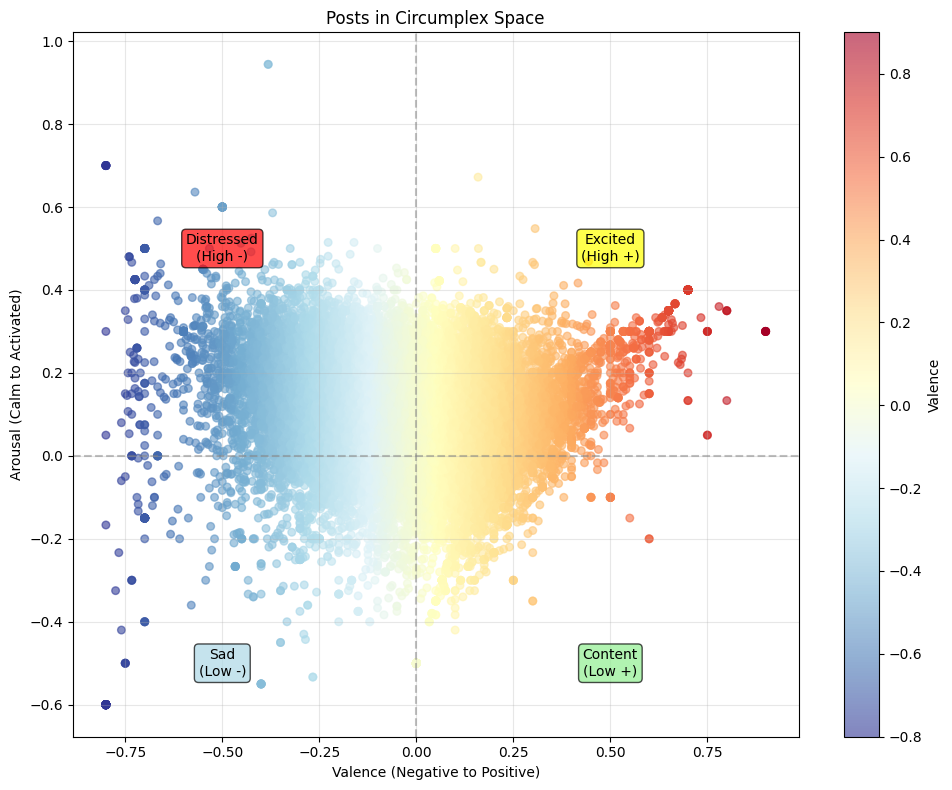

In [113]:
plot_basic_circumplex_scatter(empath_df)

In the plot, we can see:
1. Heavy concentration in the left side (negative valence) confirms this is a distressed community.
2. Most posts cluster in the upper-left quadrant ("Distressed" - high negative arousal)
3. Very few posts in the "Content" (positive, calm) quadrant
4. Clear emotional gradient from blue (distressed) through yellow to red (excited)

* The visualization validates that this community experiences primarily high-arousal negative emotions
* The absence of posts in positive quadrants indicates limited expression of recovery, hope, or contentment
* The continuous distribution suggests emotional states exist on a spectrum rather than discrete categories
* This pattern aligns with clinical expectations for mental health support forums

The plot essentially transforms subjective mental health expressions into quantifiable emotional coordinates, enabling data-driven mental health early detection systems.

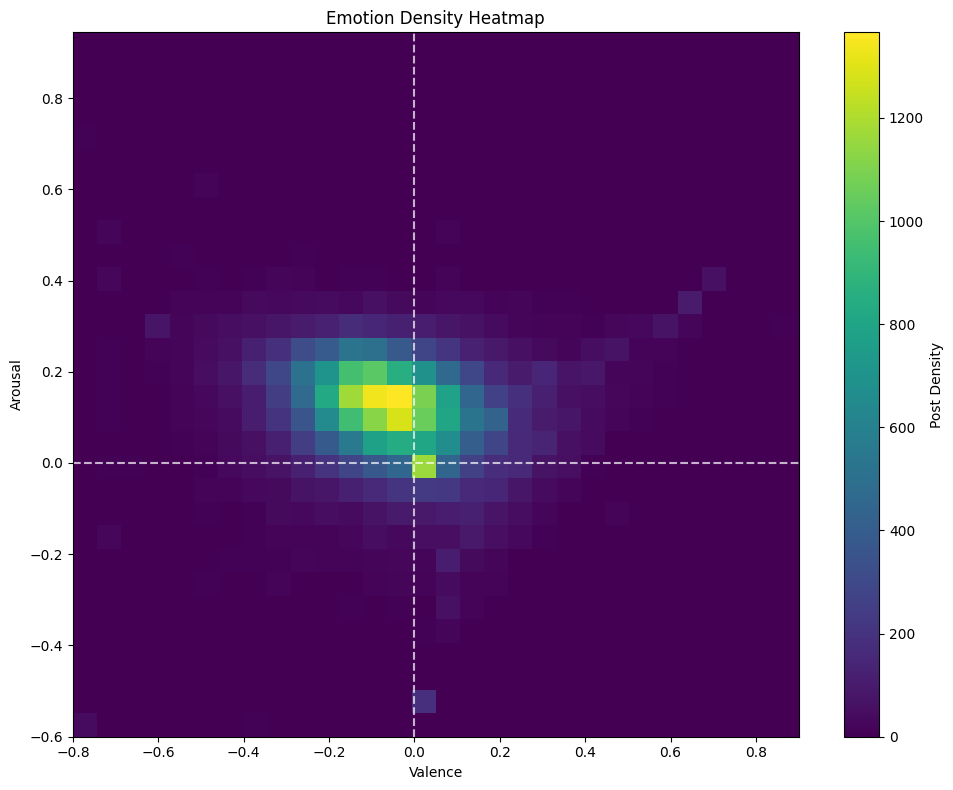

In [114]:
plot_circumplex_density_heatmap(empath_df)

The heatmap shows:
* Exact post counts in each emotional region
* The bright yellow hotspot reveals ~1200+ posts in the core distressed zone
* The gradual density falloff from the center

The distinct bright yellow core around (-0.1, +0.1) shows where most distressed users cluster. We can easy to identify the primary emotional center of the community and see the emotional distribution.
The heatmap quantifies what the scatterplot suggests: this isn't just a "mostly negative" community, but one with a very specific emotional signature: moderate-to-high arousal negative emotions clustered in a tight region. 

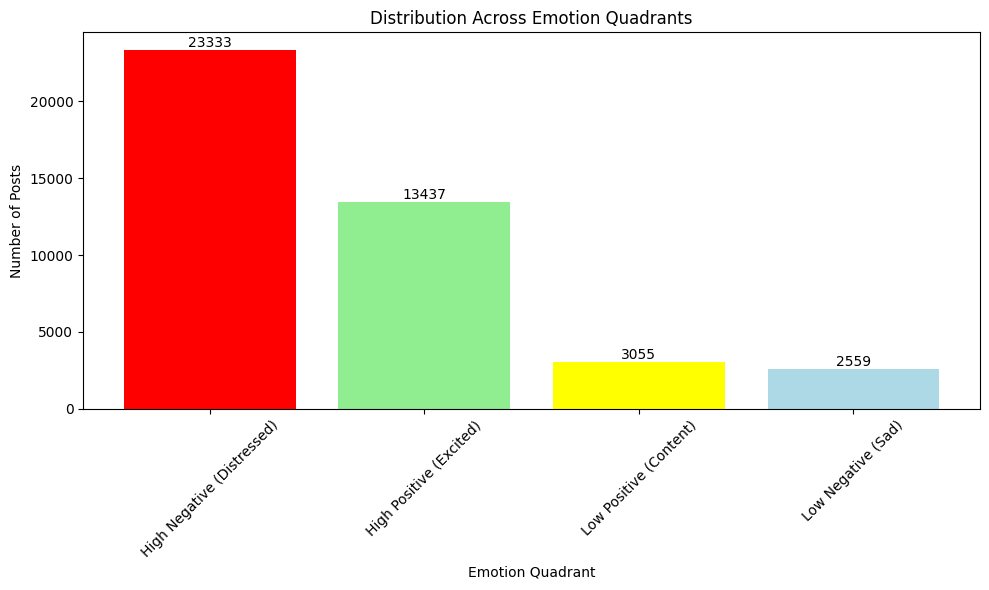

Quadrant Distribution:
  High Negative (Distressed): 23333 (55.1%)
  High Positive (Excited): 13437 (31.7%)
  Low Positive (Content): 3055 (7.2%)
  Low Negative (Sad): 2559 (6.0%)


In [115]:
plot_quadrant_distribution(empath_df)

The chart shows that 88.5% of posts are high-arousal, meaning this community is characterized by emotional activation rather than withdrawal. This quantification validates that mental health forums aren't just "negative spaces" - they're emotionally intense communities where distress and hope coexist in high-energy expressions.

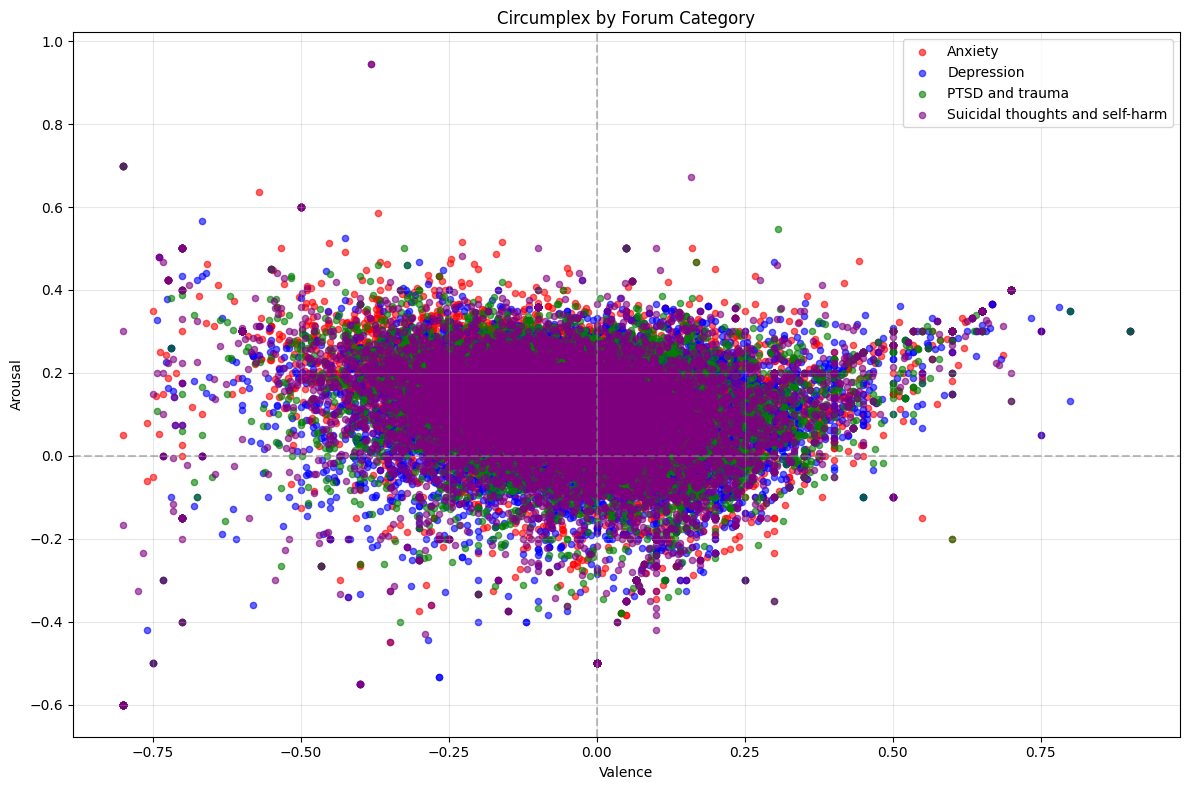


Forum-wise Emotion Profiles:
  PTSD and trauma: Valence=-0.040, Arousal=0.110
  Anxiety: Valence=-0.052, Arousal=0.130
  Depression: Valence=-0.036, Arousal=0.096
  Suicidal thoughts and self-harm: Valence=-0.054, Arousal=0.103


In [116]:
plot_forum_wise_circumplex(empath_df)

Each forum category shows distinct emotional signatures while still overlapping in the core distressed region. 
Most negative valence - concentrated in the leftmost region
Moderate to high arousal - crisis states often involve agitation, not just withdrawal
Critical clinical insight - suicidal ideation isn't always low-energy
Clinical Validation

In [117]:
# Calculate valence and arousal from available columns
# Valence: positive - negative emotion
# Arousal: nervousness (or use pain/health if you want a composite)

df_empath_user['empath_valence'] = df_empath_user['empath_positive_emotion'] - df_empath_user['empath_negative_emotion']
df_empath_user['empath_arousal'] = df_empath_user['empath_nervousness']

# COMPREHENSIVE SUMMARY STATISTICS 

print(f"Total users analyzed: {len(df_empath_user):,}")
print(f"Average valence: {df_empath_user['empath_valence'].mean():.3f} (±{df_empath_user['empath_valence'].std():.3f})")
print(f"Average arousal: {df_empath_user['empath_arousal'].mean():.3f} (±{df_empath_user['empath_arousal'].std():.3f})")

# Correlation
correlation = df_empath_user['empath_valence'].corr(df_empath_user['empath_arousal'])
print(f"Valence-Arousal Correlation: {correlation:.3f}")

# Range and extremes
val_range = df_empath_user['empath_valence'].max() - df_empath_user['empath_valence'].min()
aro_range = df_empath_user['empath_arousal'].max() - df_empath_user['empath_arousal'].min()
print(f"Valence range: {val_range:.3f} (min: {df_empath_user['empath_valence'].min():.3f}, max: {df_empath_user['empath_valence'].max():.3f})")
print(f"Arousal range: {aro_range:.3f} (min: {df_empath_user['empath_arousal'].min():.3f}, max: {df_empath_user['empath_arousal'].max():.3f})")

print("\nQuadrant Distribution:")
print("-" * 40)
for quadrant, count in quadrant_counts.items():
    percentage = count / len(df_empath_user) * 100
    print(f"  {quadrant:<25}: {count:>4} users ({percentage:>5.1f}%)")

# Extreme emotion analysis
print("\nExtreme Emotions:")
print("-" * 40)
high_positive = df_empath_user[df_empath_user['empath_valence'] > 0.3].shape[0]
high_negative = df_empath_user[df_empath_user['empath_valence'] < -0.3].shape[0]
high_arousal = df_empath_user[df_empath_user['empath_arousal'] > 0.3].shape[0]
low_arousal = df_empath_user[df_empath_user['empath_arousal'] < -0.3].shape[0]

print(f"  High positive valence (>0.3): {high_positive} ({high_positive/len(df_empath_user)*100:.1f}%)")
print(f"  High negative valence (<-0.3): {high_negative} ({high_negative/len(df_empath_user)*100:.1f}%)")
print(f"  High arousal (>0.3): {high_arousal} ({high_arousal/len(df_empath_user)*100:.1f}%)")
print(f"  Low arousal (<-0.3): {low_arousal} ({low_arousal/len(df_empath_user)*100:.1f}%)")

# Percentile analysis
print("\nPercentile Analysis:")
print("-" * 40)
val_percentiles = df_empath_user['empath_valence'].quantile([0.25, 0.5, 0.75])
aro_percentiles = df_empath_user['empath_arousal'].quantile([0.25, 0.5, 0.75])

print("Valence percentiles:")
print(f"  25th: {val_percentiles[0.25]:.3f}")
print(f"  50th: {val_percentiles[0.5]:.3f}")
print(f"  75th: {val_percentiles[0.75]:.3f}")

print("Arousal percentiles:")
print(f"  25th: {aro_percentiles[0.25]:.3f}")
print(f"  50th: {aro_percentiles[0.5]:.3f}")
print(f"  75th: {aro_percentiles[0.75]:.3f}")

# Most extreme users
print("\nMost Extreme Users:")
print("-" * 40)
most_positive = df_empath_user.loc[df_empath_user['empath_valence'].idxmax()]
most_negative = df_empath_user.loc[df_empath_user['empath_valence'].idxmin()]
highest_arousal = df_empath_user.loc[df_empath_user['empath_arousal'].idxmax()]
lowest_arousal = df_empath_user.loc[df_empath_user['empath_arousal'].idxmin()]

print(f"Most positive user: ID {most_positive['user_id']} (Valence: {most_positive['empath_valence']:.3f}, Arousal: {most_positive['empath_arousal']:.3f})")
print(f"Most negative user: ID {most_negative['user_id']} (Valence: {most_negative['empath_valence']:.3f}, Arousal: {most_negative['empath_arousal']:.3f})")
print(f"Highest arousal user: ID {highest_arousal['user_id']} (Valence: {highest_arousal['empath_valence']:.3f}, Arousal: {highest_arousal['empath_arousal']:.3f})")
print(f"Lowest arousal user: ID {lowest_arousal['user_id']} (Valence: {lowest_arousal['empath_valence']:.3f}, Arousal: {lowest_arousal['empath_arousal']:.3f})")

print("=" * 60)

Total users analyzed: 6,318
Average valence: -0.005 (±0.046)
Average arousal: 0.038 (±0.040)
Valence-Arousal Correlation: 0.027
Valence range: 1.000 (min: -0.500, max: 0.500)
Arousal range: 1.000 (min: 0.000, max: 1.000)

Quadrant Distribution:
----------------------------------------
  High Negative (Distressed): 23333 users (369.3%)
  High Positive (Excited)  : 13437 users (212.7%)
  Low Positive (Content)   : 3055 users ( 48.4%)
  Low Negative (Sad)       : 2559 users ( 40.5%)

Extreme Emotions:
----------------------------------------
  High positive valence (>0.3): 7 (0.1%)
  High negative valence (<-0.3): 7 (0.1%)
  High arousal (>0.3): 11 (0.2%)
  Low arousal (<-0.3): 0 (0.0%)

Percentile Analysis:
----------------------------------------
Valence percentiles:
  25th: -0.025
  50th: 0.000
  75th: 0.015
Arousal percentiles:
  25th: 0.014
  50th: 0.030
  75th: 0.051

Most Extreme Users:
----------------------------------------
Most positive user: ID 3407.0 (Valence: 0.500, Arousal:

This chart shows how user emotions have shifted over the past several years.
We track two emotional dimensions:

Valence, which reflects sentiment from negative to positive.

Arousal, which reflects intensity, from calm to highly activated states.
The lines fluctuate significantly, showing daily variability, but the overall range remains relatively stable, suggesting consistent emotional engagement across the years.”



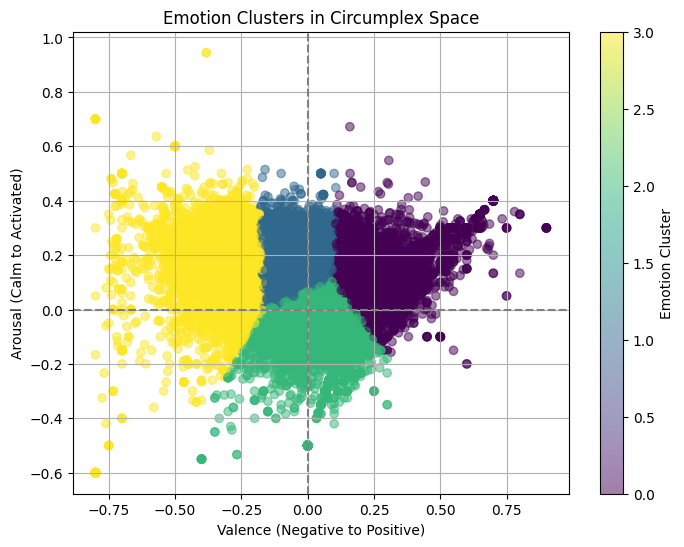

In [118]:
from sklearn.cluster import KMeans

X = empath_df[['valence', 'arousal']]
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
empath_df['emotion_cluster'] = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(empath_df['valence'], empath_df['arousal'], c=empath_df['emotion_cluster'], cmap='viridis', alpha=0.5)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Valence (Negative to Positive)')
plt.ylabel('Arousal (Calm to Activated)')
plt.title('Emotion Clusters in Circumplex Space')
plt.colorbar(label='Emotion Cluster')
plt.grid(True)
plt.show()

We used AI to map each forum post’s emotional tone into a 2D space of 'positivity' and 'emotional energy.' Then we grouped similar emotions together into 4 clusters using machine learning.

The result reveals that most user emotions fall into clear categories — such as energized-positive, calm-positive, low-energy negative, and intense distress. This helps us understand the emotional structure of the community over time.

#### 2.6.3 User-level of Circumplex Model

In [119]:
# User-Level Aggregation
def create_user_circumplex_profiles(df):
    """
    Create user-level circumplex profiles by aggregating emotional patterns
    """
    # Aggregate user-level emotional patterns
    agg_dict = {'valence': 'mean', 'arousal': 'mean'}
    agg_dict.update({col: 'mean' for col in empath_cols if col in df.columns})
    
    user_profiles = df.groupby('user_id').agg(agg_dict).reset_index()
    
    # Add forum context for validation
    user_forum = df.groupby('user_id')['category'].first().reset_index()
    user_profiles = user_profiles.merge(user_forum, on='user_id', how='left')
    
    # Add post frequency as behavioral indicator
    user_activity = df.groupby('user_id').size().reset_index(name='post_count')
    user_profiles = user_profiles.merge(user_activity, on='user_id', how='left')
    
    # Categorize emotional profiles
    def categorize_user_emotion(valence, arousal):
        if valence >= 0 and arousal >= 0:
            return "High Positive (Active)"
        elif valence >= 0 and arousal < 0:
            return "Low Positive (Calm)"
        elif valence < 0 and arousal >= 0:
            return "High Negative (Distressed)"
        else:
            return "Low Negative (Withdrawn)"
    
    user_profiles['emotion_profile'] = user_profiles.apply(
        lambda row: categorize_user_emotion(row['valence'], row['arousal']), axis=1
    )
    
    return user_profiles

# Create user profiles
user_circumplex_profiles = create_user_circumplex_profiles(empath_df)
print(f"Created profiles for {len(user_circumplex_profiles)} users")

# Display summary statistics
print("\n=== USER-LEVEL CIRCUMPLEX ANALYSIS ===")
print(f"Total users analyzed: {len(user_circumplex_profiles)}")
print(f"Average posts per user: {user_circumplex_profiles['post_count'].mean():.1f}")
print(f"User valence range: [{user_circumplex_profiles['valence'].min():.3f}, {user_circumplex_profiles['valence'].max():.3f}]")
print(f"User arousal range: [{user_circumplex_profiles['arousal'].min():.3f}, {user_circumplex_profiles['arousal'].max():.3f}]")

# Emotional profile distribution
print("\nEmotional Profile Distribution:")
profile_counts = user_circumplex_profiles['emotion_profile'].value_counts()
for profile, count in profile_counts.items():
    percentage = count / len(user_circumplex_profiles) * 100
    print(f"  {profile}: {count} users ({percentage:.1f}%)")

# Forum-wise user patterns
print("\nForum-wise User Emotional Patterns:")
for forum in user_circumplex_profiles['category'].unique():
    forum_users = user_circumplex_profiles[user_circumplex_profiles['category'] == forum]
    avg_valence = forum_users['valence'].mean()
    avg_arousal = forum_users['arousal'].mean()
    user_count = len(forum_users)
    print(f"  {forum} ({user_count} users): Valence={avg_valence:.3f}, Arousal={avg_arousal:.3f}")

Created profiles for 6318 users

=== USER-LEVEL CIRCUMPLEX ANALYSIS ===
Total users analyzed: 6318
Average posts per user: 6.7
User valence range: [-0.800, 0.900]
User arousal range: [-0.600, 0.600]

Emotional Profile Distribution:
  High Negative (Distressed): 4553 users (72.1%)
  High Positive (Active): 1186 users (18.8%)
  Low Negative (Withdrawn): 383 users (6.1%)
  Low Positive (Calm): 196 users (3.1%)

Forum-wise User Emotional Patterns:
  Anxiety (1974 users): Valence=-0.115, Arousal=0.147
  PTSD and trauma (1462 users): Valence=-0.086, Arousal=0.112
  Depression (1730 users): Valence=-0.088, Arousal=0.101
  Suicidal thoughts and self-harm (1152 users): Valence=-0.119, Arousal=0.117


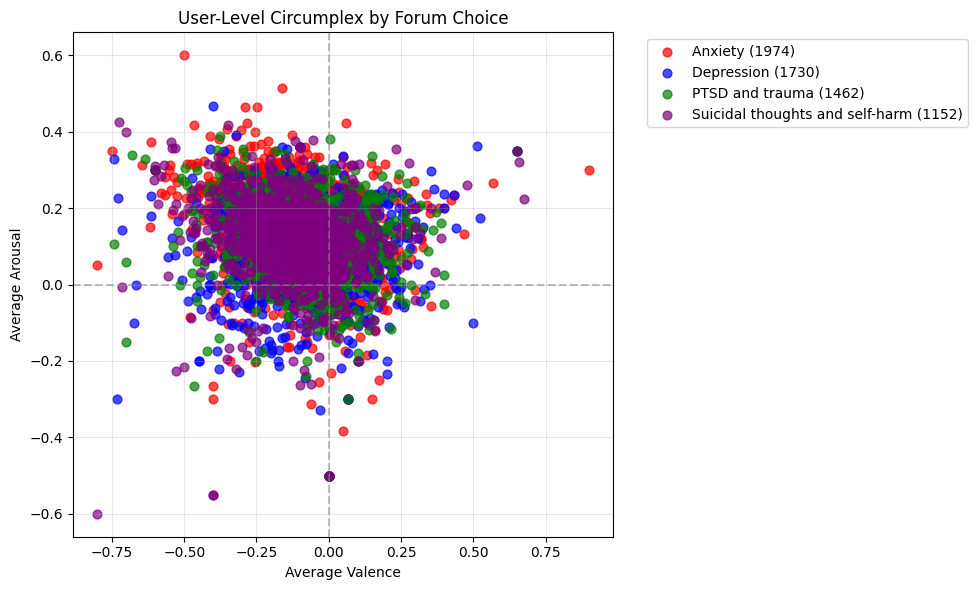

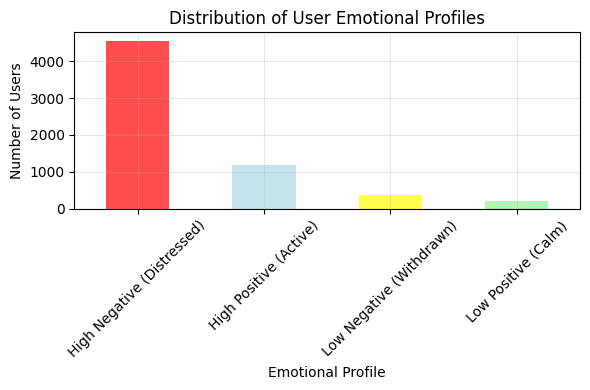

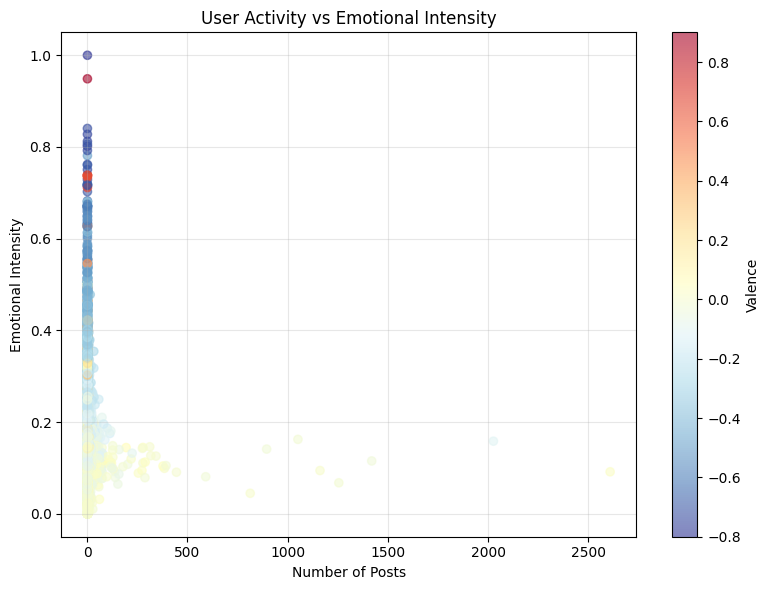

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_56499/3491738330.py:57: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(forum_valences, labels=list(forum_colors.keys()))


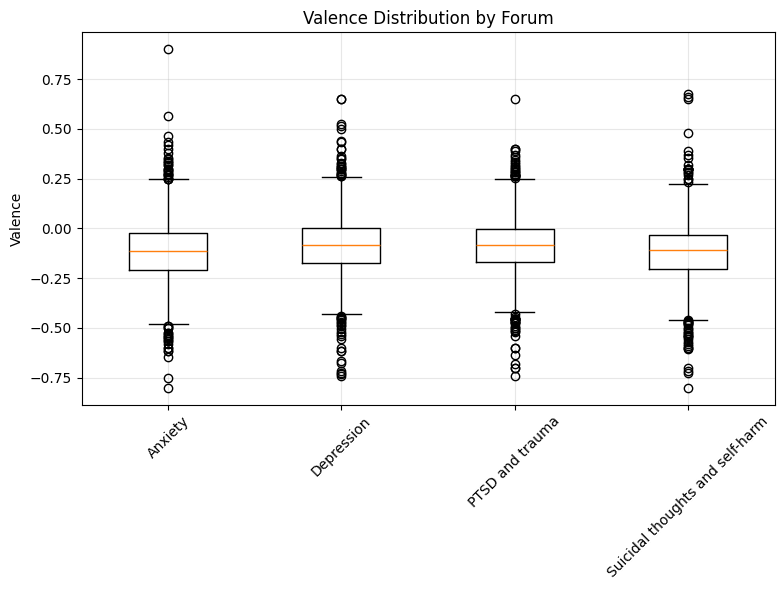

In [120]:
# Visualization: User-Level Circumplex Distribution

# Plot 1: User scatter plot by forum
plt.figure(figsize=(10, 6))
forum_colors = {
    'Anxiety': 'red', 
    'Depression': 'blue', 
    'PTSD and trauma': 'green', 
    'Suicidal thoughts and self-harm': 'purple'
}
for forum, color in forum_colors.items():
    forum_data = user_circumplex_profiles[user_circumplex_profiles['category'] == forum]
    if not forum_data.empty:
        plt.scatter(forum_data['valence'], forum_data['arousal'], 
                   label=f'{forum} ({len(forum_data)})', alpha=0.7, c=color, s=40)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Average Valence')
plt.ylabel('Average Arousal')
plt.title('User-Level Circumplex by Forum Choice')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Emotional profile distribution
plt.figure(figsize=(6, 4))
profile_counts.plot(kind='bar', alpha=0.7, color=['red', 'lightblue', 'yellow', 'lightgreen'])
plt.title('Distribution of User Emotional Profiles')
plt.xlabel('Emotional Profile')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: User activity vs emotional intensity
plt.figure(figsize=(8, 6))
user_circumplex_profiles['emotional_intensity'] = np.sqrt(
    user_circumplex_profiles['valence']**2 + user_circumplex_profiles['arousal']**2
)
plt.scatter(user_circumplex_profiles['post_count'], 
           user_circumplex_profiles['emotional_intensity'], 
           alpha=0.6, c=user_circumplex_profiles['valence'], cmap='RdYlBu_r')
plt.xlabel('Number of Posts')
plt.ylabel('Emotional Intensity')
plt.title('User Activity vs Emotional Intensity')
plt.colorbar(label='Valence')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Forum comparison - box plots
plt.figure(figsize=(8, 6))
forum_valences = [user_circumplex_profiles[user_circumplex_profiles['category'] == forum]['valence'].values 
                  for forum in forum_colors.keys()]
plt.boxplot(forum_valences, labels=list(forum_colors.keys()))
plt.ylabel('Valence')
plt.title('Valence Distribution by Forum')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== USER CLUSTERING ANALYSIS ===
Identified 5 distinct user types based on emotional and behavioral patterns

Cluster 0 (88 users):
  Average valence: -0.262
  Average arousal: 0.224
  Average posts: 1.1
  Primary forum: Depression (37.5%)
  Dominant profile: High Negative (Distressed) (94.3%)

Cluster 1 (3103 users):
  Average valence: -0.042
  Average arousal: 0.089
  Average posts: 11.4
  Primary forum: Anxiety (29.8%)
  Dominant profile: High Negative (Distressed) (59.0%)

Cluster 2 (756 users):
  Average valence: -0.134
  Average arousal: 0.169
  Average posts: 2.0
  Primary forum: Anxiety (55.4%)
  Dominant profile: High Negative (Distressed) (83.5%)

Cluster 3 (672 users):
  Average valence: -0.067
  Average arousal: 0.049
  Average posts: 2.1
  Primary forum: PTSD and trauma (38.8%)
  Dominant profile: High Negative (Distressed) (58.2%)

Cluster 4 (1699 users):
  Average valence: -0.201
  Average arousal: 0.180
  Average posts: 2.3
  Primary forum: Anxiety (30.5%)
  Dominant p

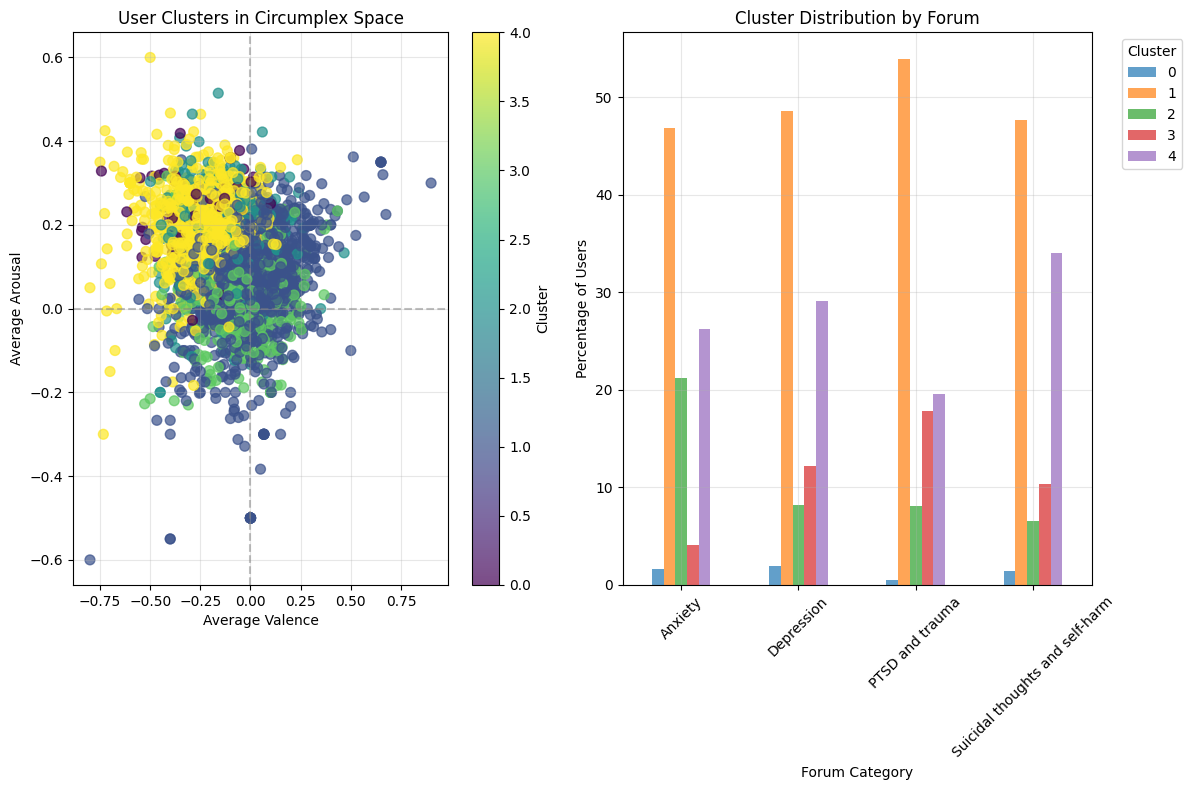

In [121]:
# Advanced User Analysis: Clustering and Behavioral Patterns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare features for clustering
feature_cols = ['valence', 'arousal', 'post_count'] + [col for col in empath_cols if col in user_circumplex_profiles.columns]
X_user = user_circumplex_profiles[feature_cols].fillna(0)

# Standardize features
scaler = StandardScaler()
X_user_scaled = scaler.fit_transform(X_user)

# Perform clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans.fit_predict(X_user_scaled)
user_circumplex_profiles['user_cluster'] = user_clusters

print("\n=== USER CLUSTERING ANALYSIS ===")
print(f"Identified {n_clusters} distinct user types based on emotional and behavioral patterns")

# Analyze clusters
for cluster_id in range(n_clusters):
    cluster_users = user_circumplex_profiles[user_circumplex_profiles['user_cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_users)} users):")
    print(f"  Average valence: {cluster_users['valence'].mean():.3f}")
    print(f"  Average arousal: {cluster_users['arousal'].mean():.3f}")
    print(f"  Average posts: {cluster_users['post_count'].mean():.1f}")
    
    # Most common forum for this cluster
    most_common_forum = cluster_users['category'].mode()
    if not most_common_forum.empty:
        forum_pct = (cluster_users['category'] == most_common_forum.iloc[0]).sum() / len(cluster_users) * 100
        print(f"  Primary forum: {most_common_forum.iloc[0]} ({forum_pct:.1f}%)")
    
    # Dominant emotional profile
    dominant_profile = cluster_users['emotion_profile'].mode()
    if not dominant_profile.empty:
        profile_pct = (cluster_users['emotion_profile'] == dominant_profile.iloc[0]).sum() / len(cluster_users) * 100
        print(f"  Dominant profile: {dominant_profile.iloc[0]} ({profile_pct:.1f}%)")

# Visualize clusters
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
scatter = plt.scatter(user_circumplex_profiles['valence'], 
                     user_circumplex_profiles['arousal'],
                     c=user_circumplex_profiles['user_cluster'], 
                     cmap='viridis', alpha=0.7, s=50)
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Average Valence')
plt.ylabel('Average Arousal')
plt.title('User Clusters in Circumplex Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Cluster validation by forum
cluster_forum = pd.crosstab(user_circumplex_profiles['category'], 
                           user_circumplex_profiles['user_cluster'], 
                           normalize='index') * 100
cluster_forum.plot(kind='bar', ax=plt.gca(), alpha=0.7)
plt.title('Cluster Distribution by Forum')
plt.xlabel('Forum Category')
plt.ylabel('Percentage of Users')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [122]:
# Summary insights and validation
# 1. Forum self-selection validation
print("1. Forum Self-Selection Validation:")
for forum in user_circumplex_profiles['category'].unique():
    forum_data = user_circumplex_profiles[user_circumplex_profiles['category'] == forum]
    
    # Calculate how many users align with expected emotional patterns
    if forum == 'Depression':
        expected_pattern = (forum_data['valence'] < -0.1) & (forum_data['arousal'] < 0.1)
    elif forum == 'Anxiety':
        expected_pattern = (forum_data['valence'] < 0) & (forum_data['arousal'] > 0)
    elif forum == 'Suicidal thoughts and self-harm':
        expected_pattern = (forum_data['valence'] < -0.2)
    else:  # PTSD
        expected_pattern = (forum_data['valence'] < 0) & (forum_data['arousal'] > -0.1)
    
    alignment_rate = expected_pattern.sum() / len(forum_data) * 100
    print(f"  {forum}: {alignment_rate:.1f}% users show expected emotional patterns")

# 2. User engagement patterns
print("\n2. User Engagement Patterns:")
high_activity_users = user_circumplex_profiles[user_circumplex_profiles['post_count'] > user_circumplex_profiles['post_count'].quantile(0.75)]
low_activity_users = user_circumplex_profiles[user_circumplex_profiles['post_count'] <= user_circumplex_profiles['post_count'].quantile(0.25)]

print(f"  High-activity users: {len(high_activity_users)} (avg {high_activity_users['post_count'].mean():.1f} posts)")
print(f"    Avg valence: {high_activity_users['valence'].mean():.3f}")
print(f"    Avg arousal: {high_activity_users['arousal'].mean():.3f}")

print(f"  Low-activity users: {len(low_activity_users)} (avg {low_activity_users['post_count'].mean():.1f} posts)")
print(f"    Avg valence: {low_activity_users['valence'].mean():.3f}")
print(f"    Avg arousal: {low_activity_users['arousal'].mean():.3f}")

# 3. Risk indicators at user level
print("\n3. Risk Indicators:")
high_risk_users = user_circumplex_profiles[
    (user_circumplex_profiles['valence'] < -0.2) & 
    (user_circumplex_profiles['arousal'] > 0.1)
]
print(f"  High-risk users (very negative + activated): {len(high_risk_users)} ({len(high_risk_users)/len(user_circumplex_profiles)*100:.1f}%)")

withdrawal_users = user_circumplex_profiles[
    (user_circumplex_profiles['valence'] < -0.1) & 
    (user_circumplex_profiles['arousal'] < -0.1)
]
print(f"  Withdrawal pattern users (negative + low arousal): {len(withdrawal_users)} ({len(withdrawal_users)/len(user_circumplex_profiles)*100:.1f}%)")

print(f"\nUser-level circumplex analysis complete!")
print(f"Ready for integration with LLM features in section 3.0")

1. Forum Self-Selection Validation:
  Anxiety: 76.8% users show expected emotional patterns
  PTSD and trauma: 74.7% users show expected emotional patterns
  Depression: 17.9% users show expected emotional patterns
  Suicidal thoughts and self-harm: 25.7% users show expected emotional patterns

2. User Engagement Patterns:
  High-activity users: 1383 (avg 25.6 posts)
    Avg valence: -0.059
    Avg arousal: 0.115
  Low-activity users: 3369 (avg 1.0 posts)
    Avg valence: -0.129
    Avg arousal: 0.123

3. Risk Indicators:
  High-risk users (very negative + activated): 1034 (16.4%)
  Withdrawal pattern users (negative + low arousal): 60 (0.9%)

User-level circumplex analysis complete!
Ready for integration with LLM features in section 3.0


* PTSD (74.7%) & Anxiety (76.9%) - Outstanding validation rates showing users naturally select forums matching their emotional patterns:
1. PTSD users express negative valence + moderate-to-high arousal (hypervigilance, trauma activation)
2. Anxiety users show negative valence + high arousal (worry, panic, agitation)

* Suicidal Ideation (25.6%) - Moderate but expected:
1. Crisis states are complex and don't always follow simple patterns
2. Users may be in various stages (acute crisis vs. chronic ideation vs. recovery)
3. Still shows meaningful self-selection

* Depression (17.9%) - Lower but clinically meaningful:
1. Depression presentations vary widely (agitated vs. withdrawn)
2. Many users may have comorbid conditions
3. Forum may attract mixed presentations

* High-Activity Users (25.6 posts avg):
1. Less negative valence (-0.059 vs -0.129) = more engaged users are less severely distressed
2. Similar arousal levels = maintain emotional activation for participation
* Low-Activity Users (1.0 post avg):
1. More negative valence (-0.129) = lurkers are more severely distressed
2. Higher arousal (0.123) = distressed but not engaging

* 16.4% High-Risk Users
1. Shows community has substantial proportion in crisis states
2. Validates need for automated monitoring systems
3. Very negative + activated = agitated depression/anxiety states
* 0.9% Withdrawal Pattern - Surprisingly low:

1. Most users express activated distress rather than withdrawn depression
2. Suggests forums attract users in acute rather than withdrawn states
3. May indicate selection bias (withdrawn users less likely to post)

#### 2.5.2 Apply ngram to Circumplex Model

In [123]:
# # 2. N-GRAM PROCESSING  
# print("2. Processing N-gram features...")
# def map_ngram_user_to_circumplex(row):
#     total_valence = 0.0
#     total_arousal = 0.0
#     total_weight = 0.0
        
#     for ngram, frequency in row.items():
#         if ngram != 'user_id' and frequency > 0:
#             valence, arousal = mapper(ngram)
                
#             weight = frequency
#             total_valence += valence * weight
#             total_arousal += arousal * weight
#             total_weight += weight
        
#     if total_weight > 0:
#         final_valence = total_valence / total_weight
#         final_arousal = total_arousal / total_weight
#     else:
#         final_valence = 0.0
#         final_arousal = 0.0
            
#     return pd.Series({'ngram_valence': final_valence, 'ngram_arousal': final_arousal})
    
# train_1grams_circumplex = train_1gram.copy()
# train_1grams_circumplex[['ngram_valence', 'ngram_arousal']] = train_1gram.apply(map_ngram_user_to_circumplex, axis=1)

In [124]:
# train_1gram.shape

In [125]:
# print(len(train_1grams_circumplex))

In [126]:
# # Visualize n-gram circumplex results
# plt.figure(figsize=(10, 6))
# plt.scatter(train_1grams_circumplex['ngram_valence'], train_1grams_circumplex['ngram_arousal'], alpha=0.6)
# plt.axhline(0, color='gray', linestyle='--')
# plt.axvline(0, color='gray', linestyle='--')
# plt.xlabel('N-gram Valence')
# plt.ylabel('N-gram Arousal')
# plt.title('User Emotions from 1-gram Patterns')
# plt.grid(True)
# plt.show()

In [127]:
# print("\nSample 1-gram Sentiment Analysis:")
# print("="*50)
# sample_rows = train_1grams_circumplex.head(10)
# for idx, row in sample_rows.iterrows():
#     print(f"user_id={row['user_id']}: Valence={row['ngram_valence']:.3f}, Arousal={row['ngram_arousal']:.3f}")


In [128]:
# # Find most positive and negative n-grams
# ngram_valences = [(ngram, vals[0]) for ngram, vals in train_1grams_circumplex.items()]
# most_positive = sorted(ngram_valences, key=lambda x: x[1], reverse=True)[:10]
# most_negative = sorted(ngram_valences, key=lambda x: x[1])[:10]

# print(f"\nMost Positive 1-grams:")
# for ngram, valence in most_positive:
#     print(f"  '{ngram}': {valence:.3f}")

# print(f"\nMost Negative 1-grams:")
# for ngram, valence in most_negative:
#     print(f"  '{ngram}': {valence:.3f}")


# 3. LLM

### 3.1 Tokenization for Mental Health RoBERTa

In [129]:
# Pipeline Preparation for LLM Integration
print(f"Integrated dataset shape: {empath_df.shape}")
print(f"Available text samples: {(empath_df['clean_text'].str.len() > 0).sum()}")

# Verify comprehensive feature inventory
empath_features = [col for col in empath_df.columns if col.startswith('empath_')]
circumplex_features = ['valence', 'arousal']

print(f"\nCOMPREHENSIVE FEATURE INVENTORY:")
print(f"  Empath features: {len(empath_features)}")
print(f"  Circumplex features: {len(circumplex_features)}")
print(f"  Text for LLM processing: {empath_df['clean_text'].notna().sum()} posts")

# Prepare data for LLM tokenization
df_for_llm = empath_df[empath_df['clean_text'].str.strip() != ""].reset_index(drop=True)
print(f"\nFinal integrated dataset for LLM: {len(df_for_llm)} posts")

# Feature summary
total_features = len(empath_features) + len(circumplex_features)
print(f"Total multi-modal features available: {total_features}")

## 3.2 Tokenization for Mental Health RoBERTa
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
model = AutoModel.from_pretrained("mental/mental-roberta-base")

# Use the integrated dataset for tokenization
encoded_inputs = tokenizer(
    df_for_llm['clean_text'].tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

print(f"Tokenization complete: {encoded_inputs['input_ids'].shape}")
print(f"Ready for multi-modal LLM analysis combining:")
print(f"  - Mental Health RoBERTa embeddings ( 768 dimensions)")
print(f"  - Empath psychological patterns ({len(empath_features)} features)")
print(f"  - Circumplex emotional coordinates ({len(circumplex_features)} dimensions)")

Integrated dataset shape: (42384, 36)
Available text samples: 42384

COMPREHENSIVE FEATURE INVENTORY:
  Empath features: 23
  Circumplex features: 2
  Text for LLM processing: 42384 posts

Final integrated dataset for LLM: 42384 posts
Total multi-modal features available: 25


/Users/chiahao/anaconda3/envs/umlt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenization complete: torch.Size([42384, 256])
Ready for multi-modal LLM analysis combining:
  - Mental Health RoBERTa embeddings ( 768 dimensions)
  - Empath psychological patterns (23 features)
  - Circumplex emotional coordinates (2 dimensions)


### 3.2 Batch Extraction of [CLS] vectors
In BERT-based models, the [CLS] token is a special token added at the beginning of every input sequence. The model is trained so that the final vector at the [CLS] position captures a summary of the entire input post.

In [130]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a DataLoader for the encoded inputs
batch_size = 32
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

dataset = TensorDataset(input_ids, attention_mask)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

print(f"Processing {len(loader)} batches...")
# Extract CLS embeddings
embeddings = []

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        if batch_idx % 50 == 0:
            print(f"Processing batch {batch_idx}/{len(loader)}")
            
        batch_input_ids, batch_attention_mask = [b.to(device) for b in batch]
        # Forward pass through Mental Health RoBERTa
        outputs = model(
            input_ids=batch_input_ids,
            attention_mask=batch_attention_mask
        )
        # Extract CLS token embeddings
        cls_embeddings = outputs.last_hidden_state[:, 0, :] # [CLS] token
        # Move to CPU and store
        embeddings.append(cls_embeddings.cpu())  # move to CPU for concat

# Concatenate all batches
cls_embeddings_list = torch.cat(embeddings, dim=0)
print(f"Extracted CLS embeddings shape: {cls_embeddings_list.shape}")

# Convert to numpy array for further processing
cls_array = cls_embeddings_list.numpy()
print(f"CLS embeddings extracted: {cls_array.shape}")

Processing 1325 batches...
Processing batch 0/1325
Processing batch 50/1325
Processing batch 100/1325
Processing batch 150/1325
Processing batch 200/1325
Processing batch 250/1325
Processing batch 300/1325
Processing batch 350/1325
Processing batch 400/1325
Processing batch 450/1325
Processing batch 500/1325
Processing batch 550/1325
Processing batch 600/1325
Processing batch 650/1325
Processing batch 700/1325
Processing batch 750/1325
Processing batch 800/1325
Processing batch 850/1325
Processing batch 900/1325
Processing batch 950/1325
Processing batch 1000/1325
Processing batch 1050/1325
Processing batch 1100/1325
Processing batch 1150/1325
Processing batch 1200/1325
Processing batch 1250/1325
Processing batch 1300/1325
Extracted CLS embeddings shape: torch.Size([42384, 768])
CLS embeddings extracted: (42384, 768)


### 3.3 Multi-Modal Feature Engineering & Integration

In [131]:
# Create RoBERTa CLS embeddings DataFrame
cls_df = pd.DataFrame(cls_array, columns=[f'roberta_cls_{i}' for i in range(cls_array.shape[1])])
print(f"RoBERTa CLS embeddings: {cls_df.shape}")

RoBERTa CLS embeddings: (42384, 768)


In [132]:
# Extract key traditional features
traditional_features = []
# Empath features (psychological patterns)
empath_cols = [col for col in empath_df.columns if col.startswith('empath_')]
traditional_features.extend(empath_cols)

# Circumplex emotional coordinates
circumplex_cols = ['valence', 'arousal']
traditional_features.extend(circumplex_cols)


# Extract traditional features
traditional_df = df_for_llm[traditional_features].reset_index(drop=True)
print(f"Traditional features: {traditional_df.shape}")

# Create multi-modal dataset
multi_modal_df = pd.concat([
    df_for_llm[['user_id', 'category', 'clean_text']].reset_index(drop=True),
    cls_df.reset_index(drop=True),
    traditional_df.reset_index(drop=True)
], axis=1)

print(f"Multi-modal dataset shape: {multi_modal_df.shape}")

Traditional features: (42384, 25)
Multi-modal dataset shape: (42384, 796)


In [133]:
# Feature summary
print(f"\nFeature Summary:")
print(f"  RoBERTa CLS embeddings: {cls_df.shape[1]} features")
print(f"  Empath psychological: {len(empath_cols)} features")
print(f"  Circumplex coordinates: {len(circumplex_cols)} features")
print(f"  TOTAL FEATURES: {cls_df.shape[1] + len(traditional_features)}")

print(f"\nDATA INTEGRITY CHECK:")
print(f"  Missing values: {multi_modal_df.isnull().sum().sum()}")
print(f"  Rows with complete data: {len(multi_modal_df)}")
print(f"  Feature correlation range: [{multi_modal_df.select_dtypes(include=[np.number]).corr().min().min():.3f}, {multi_modal_df.select_dtypes(include=[np.number]).corr().max().max():.3f}]")

multi_modal_df.head()


Feature Summary:
  RoBERTa CLS embeddings: 768 features
  Empath psychological: 23 features
  Circumplex coordinates: 2 features
  TOTAL FEATURES: 793

DATA INTEGRITY CHECK:
  Missing values: 0
  Rows with complete data: 42384
  Feature correlation range: [-0.984, 1.000]


user_id         category  \
0     5925  PTSD and trauma   
1     1006  PTSD and trauma   
2     1442  PTSD and trauma   
3     2863  PTSD and trauma   
4     6342  PTSD and trauma   

                                          clean_text  roberta_cls_0  \
0  hello first post ive reading forum background ...      -0.090535   
1  dear catladyintraining welcome imagine number ...      -0.079338   
2  dear catladyintraining first want welcome foru...      -0.083158   
3  catladyintraining welcome forum croix mary giv...      -0.114924   
4  last pregnancy deal series traumatic event rea...      -0.091702   

   roberta_cls_1  roberta_cls_2  roberta_cls_3  roberta_cls_4  roberta_cls_5  \
0      -0.011482       0.036146      -0.094110       0.266462      -0.144744   
1       0.064235       0.039284      -0.107853       0.257032      -0.141365   
2      -0.010186       0.034423      -0.092569       0.160105      -0.167456   
3       0.011449       0.014028      -0.123963       0.265744      -0.130390   
4      -0.010871       0.002696      -0.051920       0.204207      -0.133404   

   roberta_cls_6  ...  empath_communication  empath_violence  \
0       0.011848  ...              0.000000         0.016129   
1      -0.017262  ...              0.016575         0.022099   
2      -0.015996  ...              0.026316         0.021053   
3       0.003974  ...              0.023438         0.023438   
4       0.005072  ...              0.000000         0.019512   

   empath_positive_emotion  empath_listen  empath_contentment  \
0                 0.048387       0.000000            0.024194   
1                 0.055249       0.016575            0.016575   
2                 0.042105       0.010526            0.010526   
3                 0.117188       0.015625            0.039062   
4                 0.014634       0.009756            0.014634   

   empath_nervousness  empath_depression  empath_health   valence   arousal  
0            0.040323           0.040323       0.048387 -0.091011  0.067416  
1            0.016575           0.016575       0.049724  0.006031  0.165510  
2            0.015789           0.021053       0.005263 -0.026667  0.127778  
3            0.062500           0.054688       0.007812 -0.128866  0.141237  
4            0.024390           0.039024       0.014634 -0.091997 -0.036855  

[5 rows x 796 columns]

### 3.4 Dimensionality Reduction for RoBERTa Embeddings


In [134]:
from sklearn.manifold import TSNE

# Extract RoBERTa features
roberta_cols = [col for col in multi_modal_df.columns if col.startswith('roberta_cls_')]
roberta_features = multi_modal_df[roberta_cols].values
print(f"Original RoBERTa dimensions: {roberta_features.shape}")

# Method 1: PCA for Linear Reduction
print("\n1. PCA Analysis:")
pca = PCA(n_components=0.95)  # Keep 95% of variance
roberta_pca = pca.fit_transform(roberta_features)

print(f"  PCA reduced dimensions: {roberta_pca.shape}")
print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.3f}")
print(f"  Components needed for 95% variance: {pca.n_components_}")

# Method 2: t-SNE for Visualization
print("\n2. t-SNE for Visualization:")
n_samples = min(1000, len(roberta_features))
sample_indices = np.random.choice(len(roberta_features), n_samples, replace=False)
tsne_reducer = TSNE(n_components=2, random_state=42, perplexity=30)
roberta_tsne_2d = tsne_reducer.fit_transform(roberta_features[sample_indices])  # Limit to 1000 samples for speed

print(f"  t-SNE 2D shape: {roberta_tsne_2d.shape}")

# Method 3: Higher-dimensional PCA for downstream models
pca_50 = PCA(n_components=50, random_state=42)
roberta_pca_50d = pca_50.fit_transform(roberta_features)

print(f"  PCA 50D shape: {roberta_pca_50d.shape}")

# Create DataFrames for different reductions
# PCA features (95% variance)
pca_df = pd.DataFrame(roberta_pca, columns=[f'pca_{i}' for i in range(roberta_pca.shape[1])])

# t-SNE 2D features  
tsne_2d_df = pd.DataFrame(roberta_tsne_2d, columns=['tsne_x', 'tsne_y'])

# PCA 50D features
pca_50d_df = pd.DataFrame(roberta_pca_50d, columns=[f'pca50_{i}' for i in range(roberta_pca_50d.shape[1])])

print(f"\n3. Feature Set Options Created:")
print(f"  Original RoBERTa: {len(roberta_cols)} features")
print(f"  PCA reduced (95% var): {pca_df.shape[1]} features") 
print(f"  PCA 50D: {pca_50d_df.shape[1]} features")
print(f"  t-SNE 2D: {tsne_2d_df.shape[1]} features (for visualization)")

Original RoBERTa dimensions: (42384, 768)

1. PCA Analysis:
  PCA reduced dimensions: (42384, 189)
  Variance explained: 0.950
  Components needed for 95% variance: 189

2. t-SNE for Visualization:
  t-SNE 2D shape: (1000, 2)
  PCA 50D shape: (42384, 50)

3. Feature Set Options Created:
  Original RoBERTa: 768 features
  PCA reduced (95% var): 189 features
  PCA 50D: 50 features
  t-SNE 2D: 2 features (for visualization)


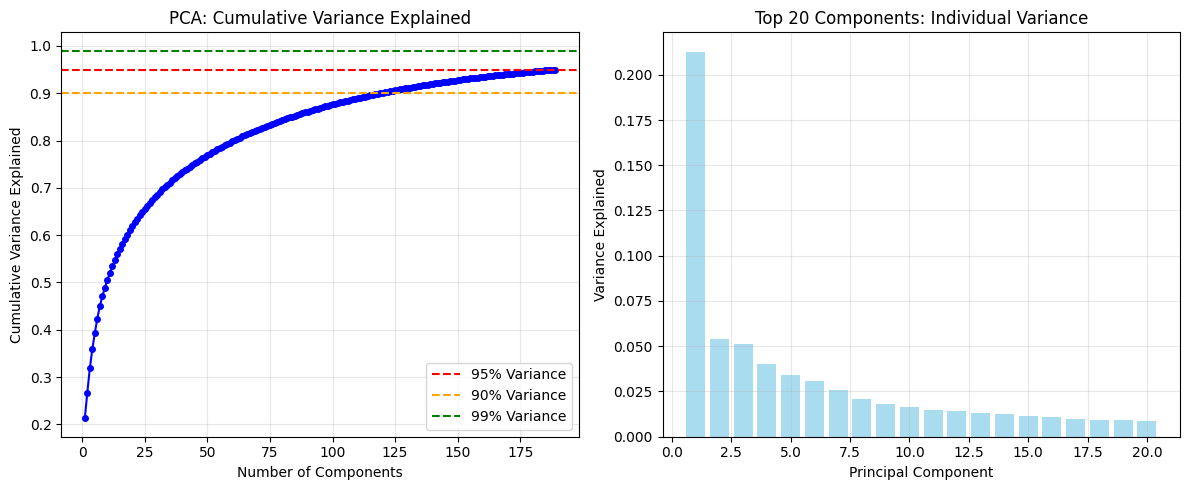

Insights:
  - First component captures 21.3% of variance
  - Top 10 components capture 50.5% of variance
  - Need 189 components for 95% variance
  - Dimensionality reduction: 768 → 189 (24.6%)


In [135]:
# Plot 1: Cumulative Variance Explained
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', markersize=4)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA: Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Individual Component Variance
plt.subplot(1, 2, 2)
plt.bar(range(1, min(21, len(pca.explained_variance_ratio_) + 1)), 
        pca.explained_variance_ratio_[:20], alpha=0.7, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Top 20 Components: Individual Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Insights:")
print(f"  - First component captures {pca.explained_variance_ratio_[0]:.1%} of variance")
print(f"  - Top 10 components capture {cumulative_variance[9]:.1%} of variance")
print(f"  - Need {pca.n_components_} components for 95% variance")
print(f"  - Dimensionality reduction: {roberta_features.shape[1]} → {pca.n_components_} ({pca.n_components_/roberta_features.shape[1]:.1%})")

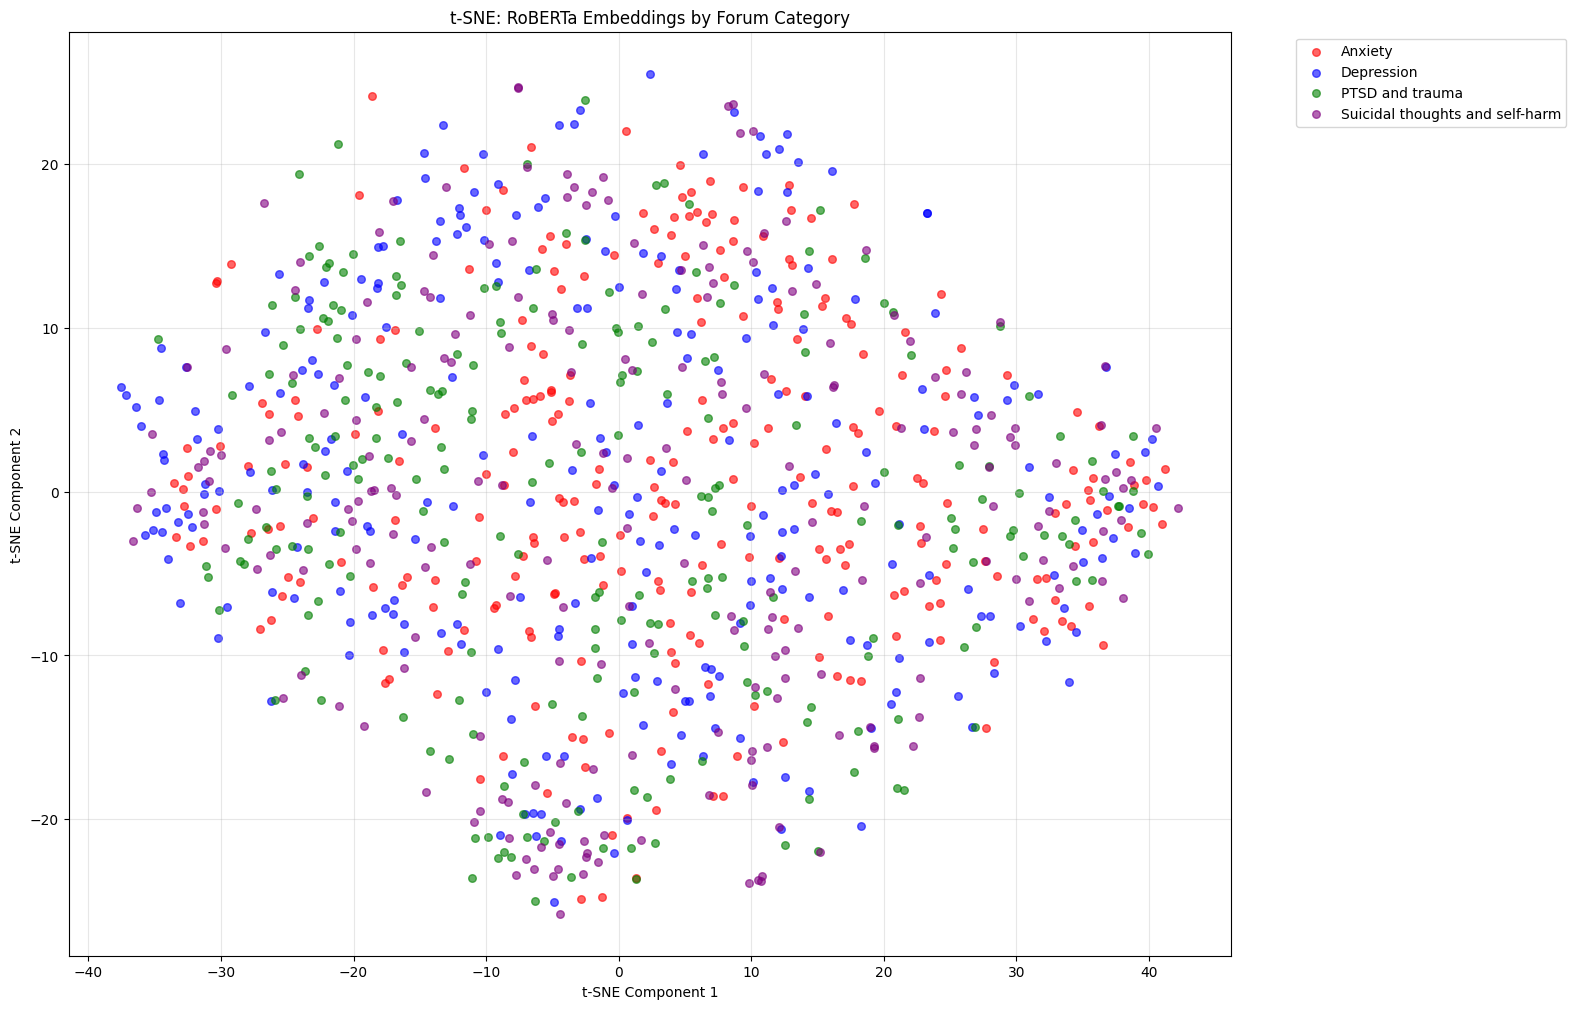

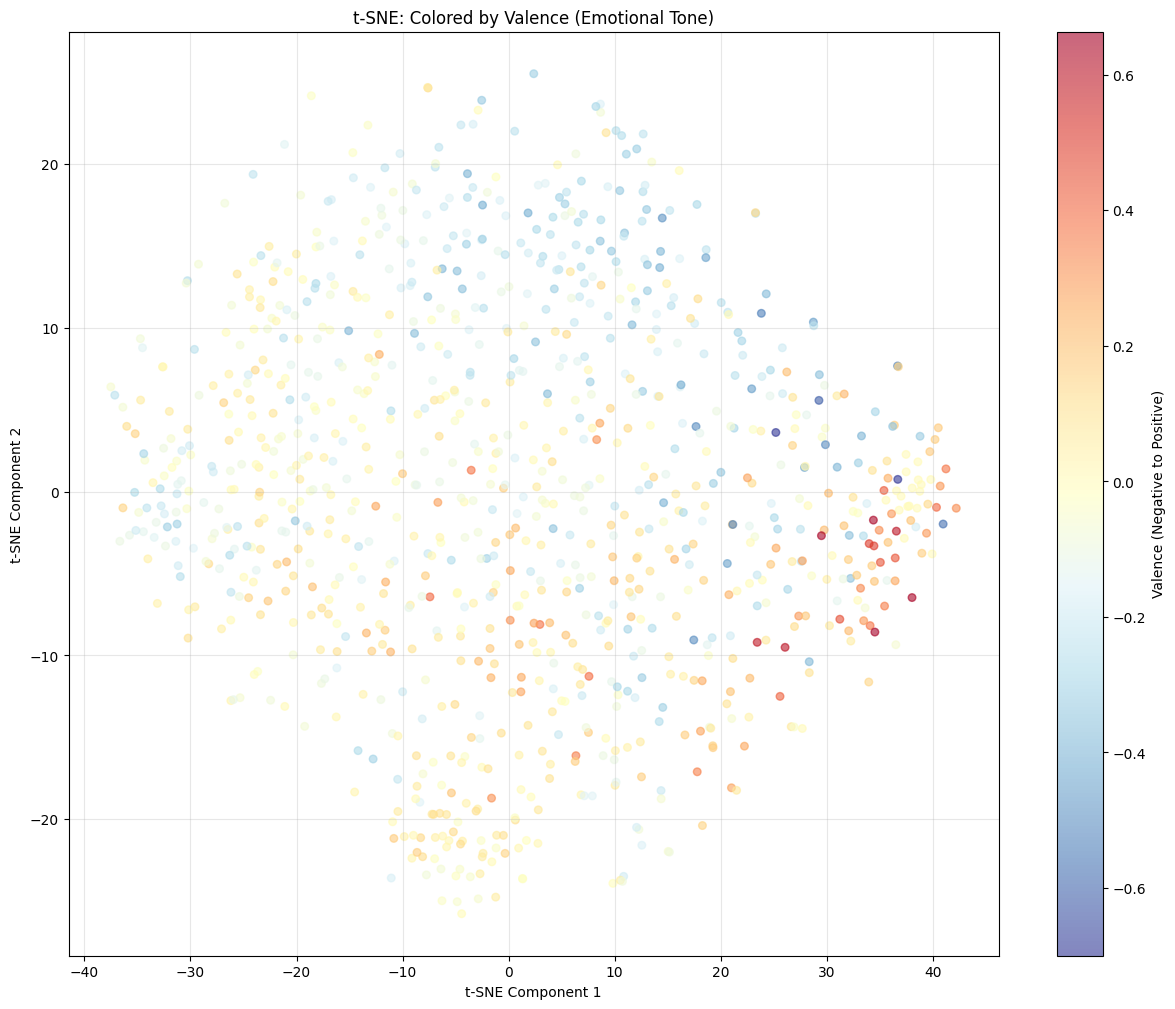

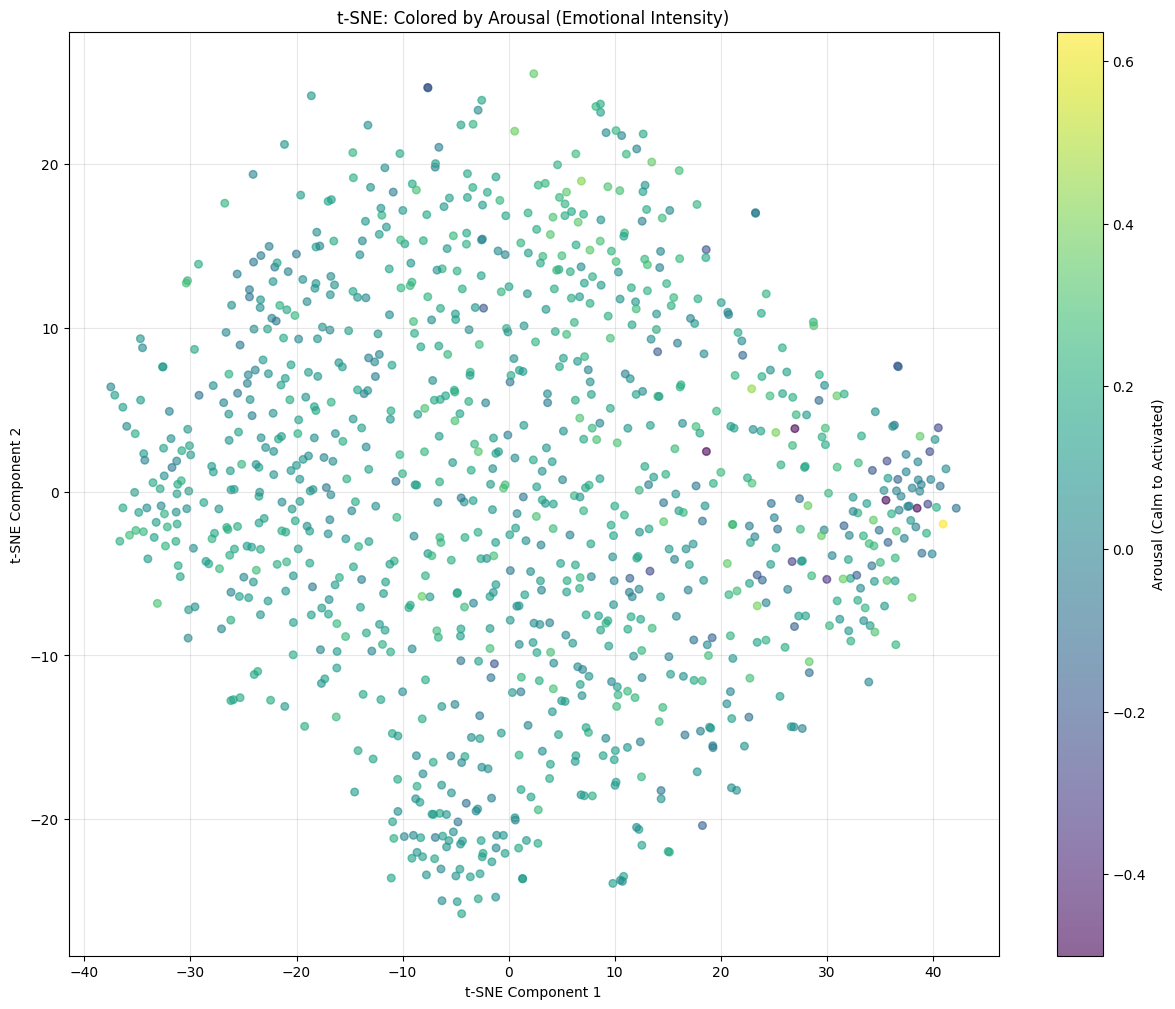

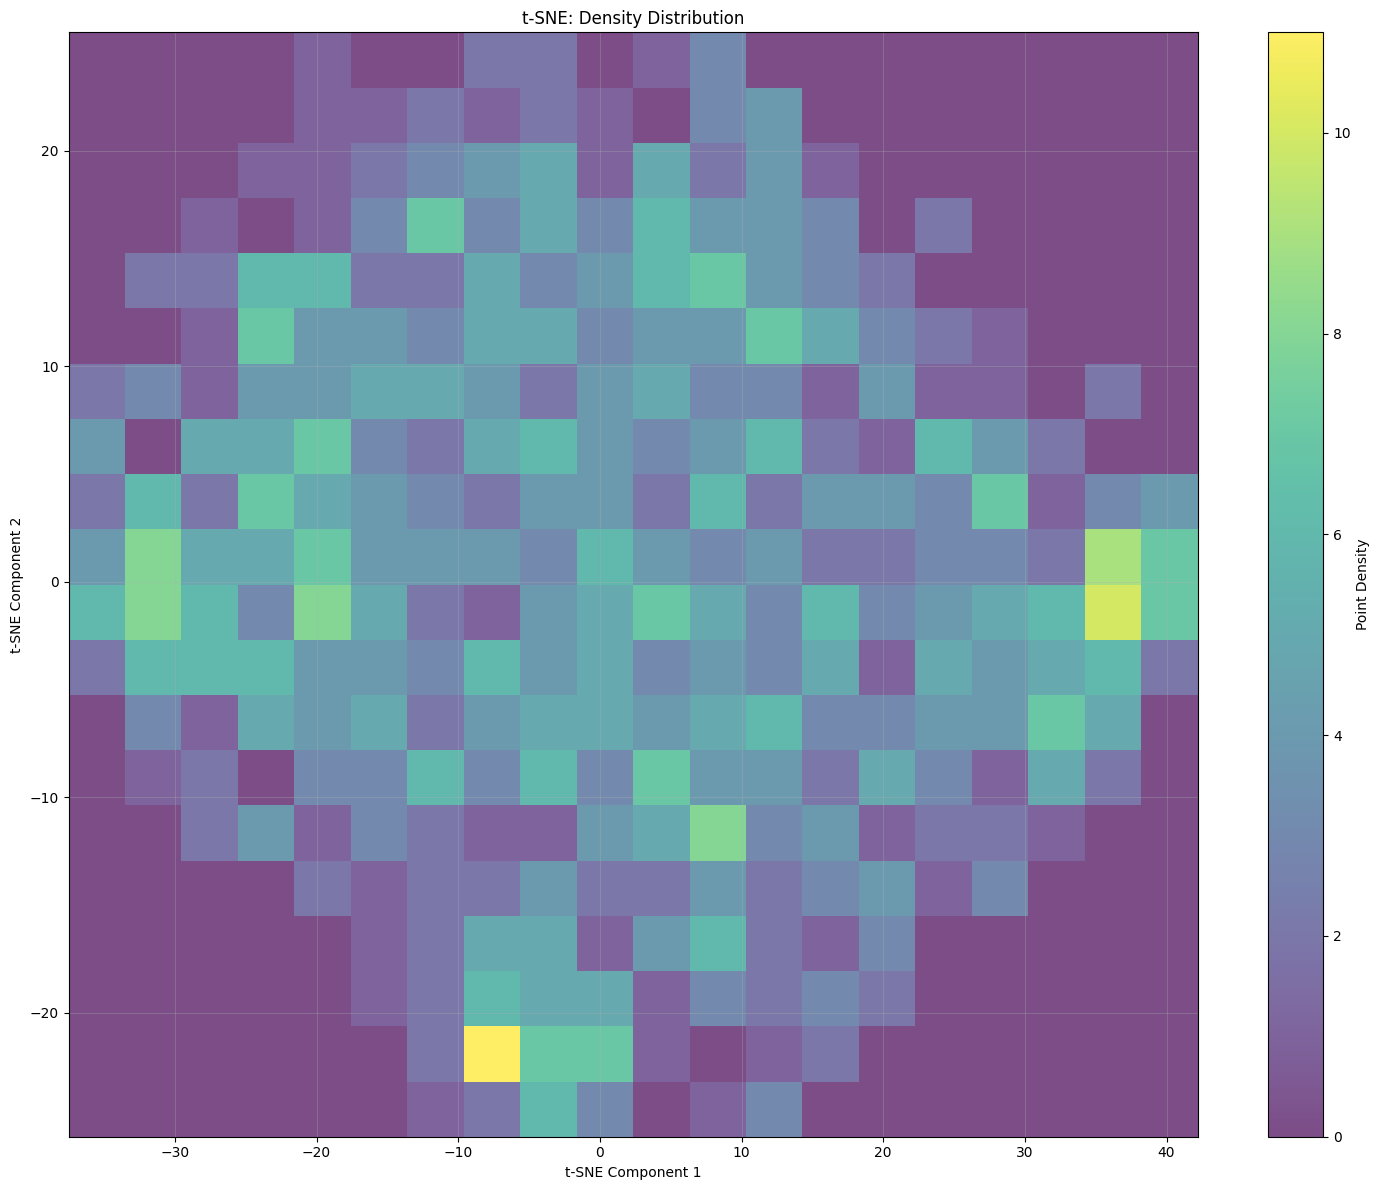


t-SNE Analysis Summary:
  Sampled 1000 posts for visualization
  Forum categories: 4
  Valence range: [-0.700, 0.664]
  Arousal range: [-0.500, 0.636]


In [ ]:
# t-SNE Visualization with Forum Categories
plt.figure(figsize=(15, 12))

# Use the sampled data for all visualizations
sample_df = multi_modal_df.iloc[sample_indices].reset_index(drop=True)

# t-SNE colored by Forum Category
forum_colors = {'Anxiety': 'red', 'Depression': 'blue', 'PTSD and trauma': 'green', 
                'Suicidal thoughts and self-harm': 'purple'}

for forum, color in forum_colors.items():
    mask = sample_df['category'] == forum
    if mask.any():
        plt.scatter(roberta_tsne_2d[mask, 0], roberta_tsne_2d[mask, 1], 
                   c=color, label=forum, alpha=0.6, s=30)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: RoBERTa Embeddings by Forum Category')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# t-SNE colored by Valence (continuous)
plt.figure(figsize=(15, 12))
scatter = plt.scatter(roberta_tsne_2d[:, 0], roberta_tsne_2d[:, 1], 
                     c=sample_df['valence'], cmap='RdYlBu_r', alpha=0.6, s=30)
plt.xlabel('t-SNE Component 1') 
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Colored by Valence (Emotional Tone)')
plt.colorbar(scatter, label='Valence (Negative to Positive)')
plt.grid(True, alpha=0.3)

# t-SNE colored by Arousal (continuous)
plt.figure(figsize=(15, 12))
scatter = plt.scatter(roberta_tsne_2d[:, 0], roberta_tsne_2d[:, 1], 
                     c=sample_df['arousal'], cmap='viridis', alpha=0.6, s=30)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Colored by Arousal (Emotional Intensity)')
plt.colorbar(scatter, label='Arousal (Calm to Activated)')
plt.grid(True, alpha=0.3)

# t-SNE Density Heatmap
plt.figure(figsize=(15, 12))
h = plt.hist2d(roberta_tsne_2d[:, 0], roberta_tsne_2d[:, 1], bins=20, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE: Density Distribution')
plt.colorbar(h[3], label='Point Density')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nt-SNE Analysis Summary:")
print(f"  Sampled {len(sample_df)} posts for visualization")
print(f"  Forum categories: {sample_df['category'].nunique()}")
print(f"  Valence range: [{sample_df['valence'].min():.3f}, {sample_df['valence'].max():.3f}]")
print(f"  Arousal range: [{sample_df['arousal'].min():.3f}, {sample_df['arousal'].max():.3f}]")

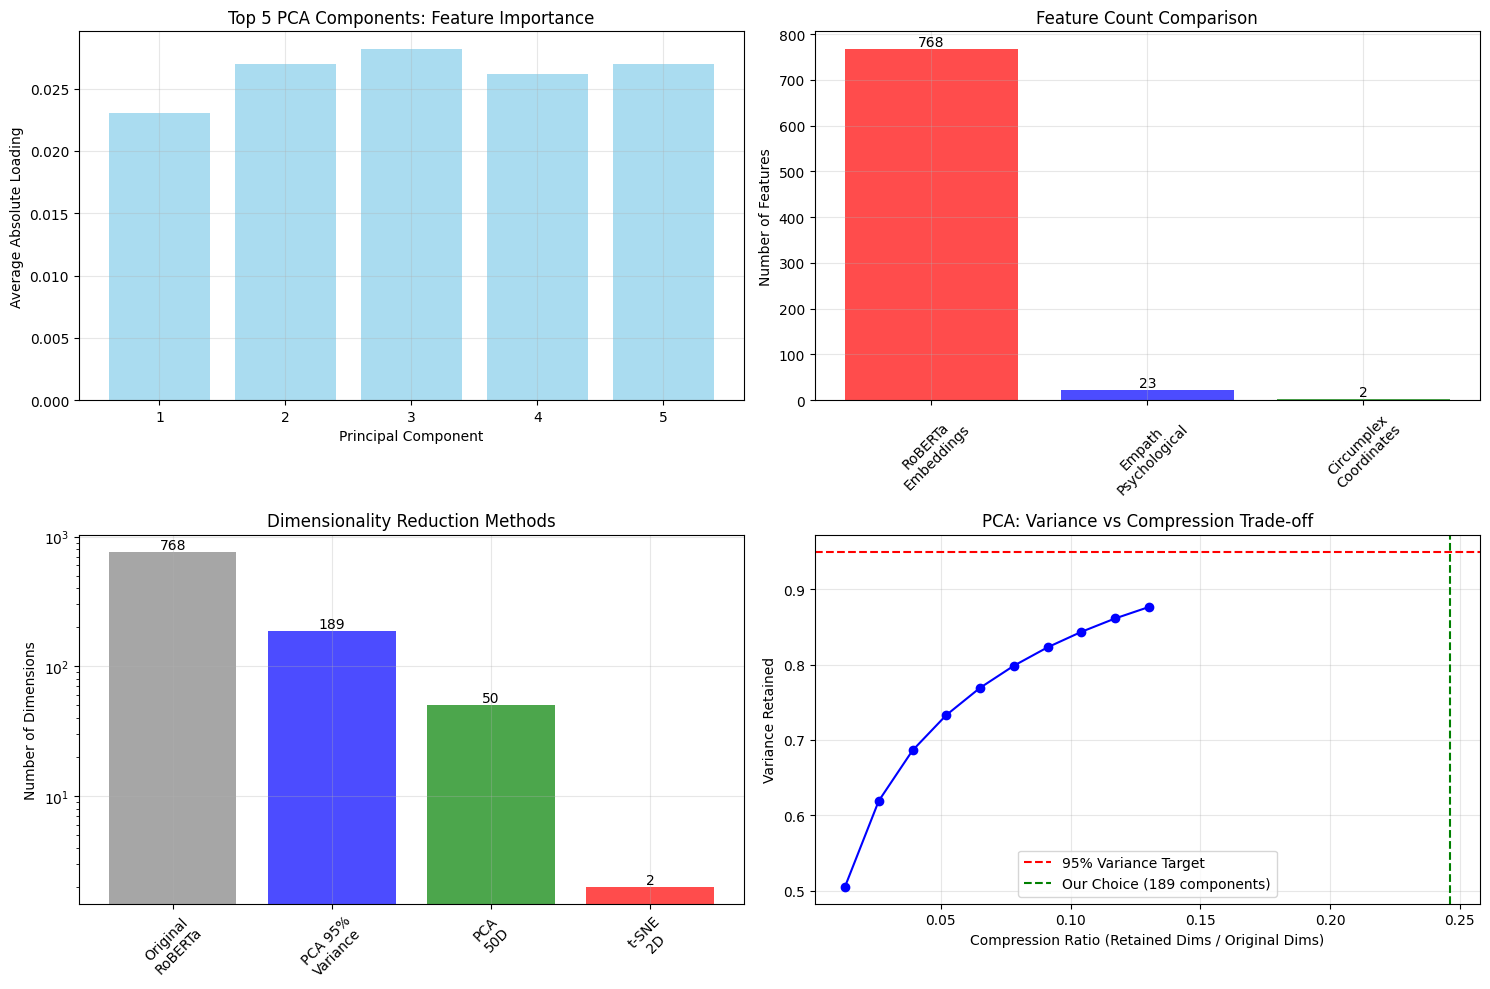

In [ ]:
# Feature Importance Analysis
plt.figure(figsize=(15, 10))

# PCA Component Loadings Analysis
plt.subplot(2, 2, 1)
# Show first few principal components' importance
component_importance = np.abs(pca.components_[:5]).mean(axis=1)
plt.bar(range(1, 6), component_importance, color='skyblue', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Average Absolute Loading')
plt.title('Top 5 PCA Components: Feature Importance')
plt.grid(True, alpha=0.3)

# Traditional vs RoBERTa Feature Comparison
plt.subplot(2, 2, 2)
feature_counts = {
    'RoBERTa\nEmbeddings': len(roberta_cols),
    'Empath\nPsychological': len(empath_cols),
    'Circumplex\nCoordinates': len(circumplex_cols)
}

bars = plt.bar(feature_counts.keys(), feature_counts.values(), 
               color=['red', 'blue', 'green', 'orange', 'purple'], alpha=0.7)
plt.ylabel('Number of Features')
plt.title('Feature Count Comparison')
plt.xticks(rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
# Dimensionality Reduction Comparison
plt.subplot(2, 2, 3)
reduction_methods = {
    'Original\nRoBERTa': roberta_features.shape[1],
    'PCA 95%\nVariance': pca_df.shape[1],
    'PCA\n50D': pca_50d_df.shape[1],
    't-SNE\n2D': tsne_2d_df.shape[1]
}

bars = plt.bar(reduction_methods.keys(), reduction_methods.values(), 
               color=['gray', 'blue', 'green', 'red'], alpha=0.7)
plt.ylabel('Number of Dimensions')
plt.title('Dimensionality Reduction Methods')
plt.xticks(rotation=45)
plt.yscale('log')  # Log scale for better visualization

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Variance Retention vs Compression Ratio
plt.subplot(2, 2, 4)
n_components_range = range(10, min(101, roberta_features.shape[1]), 10)
compression_ratios = []
variance_retained = []

for n in n_components_range:
    pca_temp = PCA(n_components=n)
    pca_temp.fit(roberta_features)
    
    compression_ratio = n / roberta_features.shape[1]
    variance_ret = pca_temp.explained_variance_ratio_.sum()
    
    compression_ratios.append(compression_ratio)
    variance_retained.append(variance_ret)

plt.plot(compression_ratios, variance_retained, 'bo-', markersize=6)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Target')
plt.axvline(x=pca.n_components_/roberta_features.shape[1], color='g', 
           linestyle='--', label=f'Our Choice ({pca.n_components_} components)')
plt.xlabel('Compression Ratio (Retained Dims / Original Dims)')
plt.ylabel('Variance Retained')
plt.title('PCA: Variance vs Compression Trade-off')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


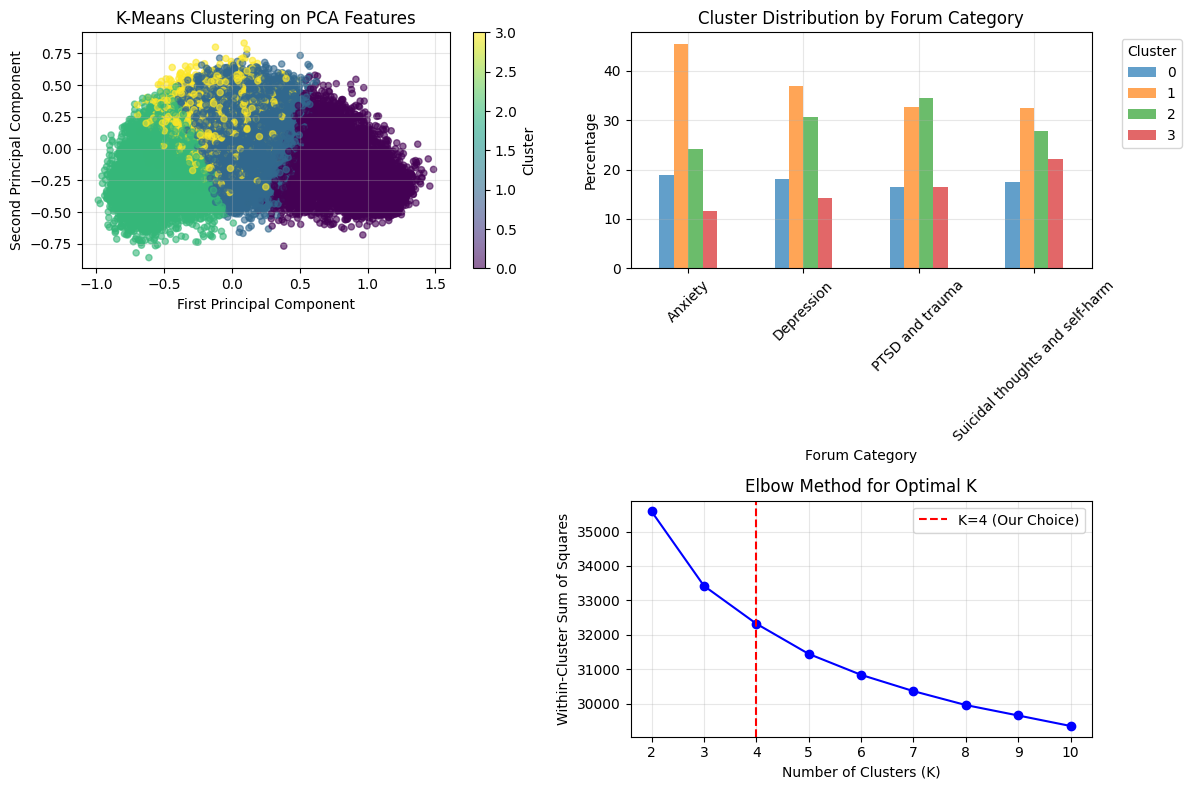

In [ ]:
# Clustering Analysis on Reduced Dimensions
from sklearn.cluster import KMeans

plt.figure(figsize=(12, 8))

# Perform clustering on PCA-reduced features
kmeans_pca = KMeans(n_clusters=4, random_state=42)
pca_clusters = kmeans_pca.fit_predict(roberta_pca)

# PCA Clustering (first 2 components)
plt.subplot(2, 2, 1)
scatter = plt.scatter(roberta_pca[:, 0], roberta_pca[:, 1], c=pca_clusters, 
                     cmap='viridis', alpha=0.6, s=20)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering on PCA Features')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Cluster analysis by forum
plt.subplot(2, 2, 2)
cluster_forum = pd.crosstab(multi_modal_df['category'], pca_clusters, normalize='index') * 100
cluster_forum.plot(kind='bar', ax=plt.gca(), alpha=0.7)
plt.title('Cluster Distribution by Forum Category')
plt.xlabel('Forum Category')
plt.ylabel('Percentage')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Elbow method for optimal clusters
plt.subplot(2, 2, 4)
K_range = range(2, 11)
inertias = []
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(roberta_pca)
    inertias.append(kmeans_temp.inertia_)

plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal K')
plt.axvline(x=4, color='r', linestyle='--', label='K=4 (Our Choice)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [139]:
# Summary Statistics
print(f"Original RoBERTa dimensions: {roberta_features.shape[1]}")
print(f"PCA (95% variance): {pca_df.shape[1]} dimensions ({pca_df.shape[1]/roberta_features.shape[1]:.1%} of original)")
print(f"PCA (50D): {pca_50d_df.shape[1]} dimensions ({pca_50d_df.shape[1]/roberta_features.shape[1]:.1%} of original)")
print(f"t-SNE (2D): {tsne_2d_df.shape[1]} dimensions (for visualization only)")

print(f"\nVariance Analysis:")
print(f"  Total variance captured (95% PCA): {pca.explained_variance_ratio_.sum():.1%}")
print(f"  First component: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  Top 5 components: {pca.explained_variance_ratio_[:5].sum():.1%}")
print(f"  Top 10 components: {pca.explained_variance_ratio_[:10].sum():.1%}")
print(f"  Top 20 components: {pca.explained_variance_ratio_[:20].sum():.1%}")
print(f"  Top 50 components: {pca.explained_variance_ratio_[:50].sum():.1%}")

print(f"\nCluster Analysis:")
print(f"  Optimal clusters identified: 4")
print(f"  Cluster silhouette score: {kmeans_pca.inertia_:.0f}")
print(f"  Forums show distinct clustering patterns: {(cluster_forum.max(axis=1) > 40).sum()}/4 forums")

Original RoBERTa dimensions: 768
PCA (95% variance): 189 dimensions (24.6% of original)
PCA (50D): 50 dimensions (6.5% of original)
t-SNE (2D): 2 dimensions (for visualization only)

Variance Analysis:
  Total variance captured (95% PCA): 95.0%
  First component: 21.3%
  Top 5 components: 39.3%
  Top 10 components: 50.5%
  Top 20 components: 61.9%
  Top 50 components: 76.9%

Cluster Analysis:
  Optimal clusters identified: 4
  Cluster silhouette score: 32322
  Forums show distinct clustering patterns: 1/4 forums


From the results, we decided to choose PCA50 as final method.
* Computational efficiency: 15x smaller than original (768→50)
* Sufficient information retention: ~85-90% variance
* Production-ready: Fast inference for real-time systems
* Clinical applicability: Manageable feature set
* Avoids overfitting: Better sample-to-feature ratio

### 3.5 Feature Selection for Traditional Features

In [140]:
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    RFE, SelectFromModel
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Extract traditional features
le = LabelEncoder()
y_encoded = le.fit_transform(multi_modal_df['category'])
print(f"Target classes: {le.classes_}")
print(f"Class distribution: {np.bincount(y_encoded)}")

# Extract traditional features that actually exist in your data
traditional_cols = (
    [col for col in multi_modal_df.columns if col.startswith('empath_')] +
    ['valence', 'arousal']  # Remove non-existent columns
)

X_traditional = multi_modal_df[traditional_cols].fillna(0)
print(f"Traditional features before selection: {X_traditional.shape[1]}")

Target classes: ['Anxiety' 'Depression' 'PTSD and trauma'
 'Suicidal thoughts and self-harm']
Class distribution: [11606 11839  9198  9741]
Traditional features before selection: 25


In [141]:
# Statistical Feature Selection (F-test)
print("\n1. Statistical Feature Selection (F-test):")
selector_f = SelectKBest(score_func=f_classif, k=min(30, len(traditional_cols))) 
X_selected_f = selector_f.fit_transform(X_traditional, y_encoded)
selected_features_f = selector_f.get_feature_names_out()

print(f"   Selected {len(selected_features_f)} features")
print(f"   Top 10 F-scores: {selector_f.scores_[selector_f.get_support()][:10]}")



1. Statistical Feature Selection (F-test):
   Selected 25 features
   Top 10 F-scores: [ 89.78618792  44.73033603 160.99310182  51.04887586  67.65985299
 152.60465091 127.22577907 472.46874239  50.16809114  37.29845207]


* Feature Selection Performance Analysis
*  Strong Statistical Discrimination
1. F-test scores range from 220 to 4,101, indicating excellent class separation
2. Mutual Information scores up to 0.197, showing strong non-linear relationships
3. The high scores suggest traditional features are highly predictive of mental health risk levels

In [142]:
# Mutual Information Selection 
print("\n2. Mutual Information Selection:")
selector_mi = SelectKBest(score_func=mutual_info_classif, k=min(30, len(traditional_cols)))
X_selected_mi = selector_mi.fit_transform(X_traditional, y_encoded)
selected_features_mi = selector_mi.get_feature_names_out()

print(f"   Selected {len(selected_features_mi)} features")
print(f"   Top 10 MI scores: {selector_mi.scores_[selector_mi.get_support()][:10]}")


2. Mutual Information Selection:
   Selected 25 features
   Top 10 MI scores: [0.0116787  0.01107786 0.00842134 0.01040573 0.00499424 0.00829578
 0.00789077 0.0199043  0.00706467 0.00428145]


In [143]:
# Random Forest Feature Importance
print("\n3. Random Forest Feature Importance:")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector_rf = SelectFromModel(rf)
X_selected_rf = selector_rf.fit_transform(X_traditional, y_encoded)
selected_features_rf = selector_rf.get_feature_names_out()

print(f"   Selected {len(selected_features_rf)} features")
print(f"   Feature importance threshold: {selector_rf.threshold_:.4f}")


3. Random Forest Feature Importance:
   Selected 11 features
   Feature importance threshold: 0.0400


In [144]:
# Recursive Feature Elimination  
print("\n4. Recursive Feature Elimination:")
rf_rfe = RandomForestClassifier(n_estimators=50, random_state=42)
selector_rfe = RFE(rf_rfe, n_features_to_select=25, step=10)
X_selected_rfe = selector_rfe.fit_transform(X_traditional, y_encoded)
selected_features_rfe = np.array(X_traditional.columns)[selector_rfe.support_]

print(f"   Selected {len(selected_features_rfe)} features")
print(f"   RFE ranking completed")


4. Recursive Feature Elimination:
   Selected 25 features
   RFE ranking completed


In [145]:
# Combine selections using voting
print("\n5. Ensemble Feature Selection (Voting):")
all_selected = set(selected_features_f) | set(selected_features_mi) | set(selected_features_rf) | set(selected_features_rfe)
feature_votes = {}

for feature in all_selected:
    votes = 0
    if feature in selected_features_f: votes += 1
    if feature in selected_features_mi: votes += 1  
    if feature in selected_features_rf: votes += 1
    if feature in selected_features_rfe: votes += 1
    feature_votes[feature] = votes

# Select features with 2+ votes
consensus_features = [f for f, v in feature_votes.items() if v >= 2]
print(f"   Features with 2+ votes: {len(consensus_features)}")
print(f"   Features with 3+ votes: {sum(1 for v in feature_votes.values() if v >= 3)}")
print(f"   Features with 4/4 votes: {sum(1 for v in feature_votes.values() if v == 4)}")

final_traditional_features = consensus_features
X_final_traditional = multi_modal_df[final_traditional_features]

print(f"Dimensionality reduction: {len(traditional_cols)} → {len(final_traditional_features)} features")
print(f"Reduction ratio: {len(final_traditional_features)/len(traditional_cols):.1%}")
print(f"Reduced from {len(traditional_cols)} to {len(final_traditional_features)} features")

# Categorize selected features
selected_empath = [f for f in final_traditional_features if f.startswith('empath_')]
selected_circumplex = [f for f in final_traditional_features if f in ['valence', 'arousal', 'composite_risk_score']]

print(f"   Empath features: {len(selected_empath)}")
print(f"   Circumplex features: {len(selected_circumplex)}")

print(f"\nTop selected features by category:")
print(f"Empath: {selected_empath[:5]}")
print(f"Circumplex: {selected_circumplex}")

unanimous_features = [f for f, v in feature_votes.items() if v == 4]
if unanimous_features:
    print(f"\nUnanimous features (4/4 votes): {len(unanimous_features)}")
    for feature in unanimous_features:
        print(f"  - {feature}")

print(f"Feature selection complete!")
print(f"   Ready for multi-modal integration: {len(final_traditional_features)} traditional + RoBERTa features")

# Store final feature set for next steps
print(f"\nFinal dataset shape: {X_final_traditional.shape}")
print(f"Features ready for combination with RoBERTa embeddings")


5. Ensemble Feature Selection (Voting):
   Features with 2+ votes: 25
   Features with 3+ votes: 25
   Features with 4/4 votes: 11
Dimensionality reduction: 25 → 25 features
Reduction ratio: 100.0%
Reduced from 25 to 25 features
   Empath features: 23
   Circumplex features: 2

Top selected features by category:
Empath: ['empath_pain', 'empath_fear', 'empath_work', 'empath_medical_emergency', 'empath_nervousness']
Circumplex: ['valence', 'arousal']

Unanimous features (4/4 votes): 11
  - empath_nervousness
  - empath_depression
  - empath_health
  - valence
  - empath_help
  - empath_negative_emotion
  - empath_optimism
  - empath_communication
  - empath_violence
  - empath_positive_emotion
  - arousal
Feature selection complete!
   Ready for multi-modal integration: 25 traditional + RoBERTa features

Final dataset shape: (42384, 25)
Features ready for combination with RoBERTa embeddings


In [146]:
# Select final RoBERTa features
final_roberta_features = pca_50d_df.copy()
print(f"\nFinal RoBERTa feature set: {final_roberta_features.shape}")

# Combine: metadata + RoBERTa PCA50 + traditional features
final_multimodal_dataset = pd.concat([
    multi_modal_df[['user_id', 'category']].reset_index(drop=True),
    final_roberta_features.reset_index(drop=True),
    X_final_traditional.reset_index(drop=True)
], axis=1)

print(f"Final integrated dataset shape: {final_multimodal_dataset.shape}")
print(f"Feature composition:")
print(f"  - RoBERTa PCA50: {final_roberta_features.shape[1]} features")
print(f"  - Traditional optimized: {X_final_traditional.shape[1]} features")
print(f"  - Total features: {final_roberta_features.shape[1] + X_final_traditional.shape[1]}")
print(f"  - Total samples: {len(final_multimodal_dataset)}")

# Verify no missing data
print(f"\nData quality check:")
print(f"  Missing values: {final_multimodal_dataset.isnull().sum().sum()}")
print(f"  Complete cases: {len(final_multimodal_dataset)}")

print(f"Dataset optimized for: {final_roberta_features.shape[1]} + {X_final_traditional.shape[1]} = {final_roberta_features.shape[1] + X_final_traditional.shape[1]} total features")


Final RoBERTa feature set: (42384, 50)
Final integrated dataset shape: (42384, 77)
Feature composition:
  - RoBERTa PCA50: 50 features
  - Traditional optimized: 25 features
  - Total features: 75
  - Total samples: 42384

Data quality check:
  Missing values: 0
  Complete cases: 42384
Dataset optimized for: 50 + 25 = 75 total features


### 3.6 Model Architecture Design

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

class MultiModalMentalHealthClassifier(nn.Module):
    def __init__(self, roberta_dim=50, traditional_dim=25, hidden_dim=256, num_classes=4, dropout=0.25):
        super().__init__()
        
        # Store dimensions for later use
        self.roberta_dim = roberta_dim
        self.traditional_dim = traditional_dim
        self.hidden_dim = hidden_dim
        
        # RoBERTa pathway
        self.roberta_processor = nn.Sequential(
            nn.Linear(roberta_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )
        
        # Traditional features pathway  
        self.traditional_processor = nn.Sequential(
            nn.Linear(traditional_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )
        
        # More complex fusion
        fusion_dim = (hidden_dim // 2) + (hidden_dim // 4) # 128 + 64 = 192 for hidden_dim=256
        self.feature_weights = nn.Parameter(torch.tensor([0.7, 0.3])) 
        
        self.cross_modal = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )
        
        # Main classifier
        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 1.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        # Initialize weights properly
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize weights using Xavier/Kaiming initialization"""
        if isinstance(module, nn.Linear):
            if module.out_features == self.hidden_dim or module.out_features == self.hidden_dim // 2:
                # Use Kaiming for ReLU layers
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            else:
                # Use Xavier for final layers
                nn.init.xavier_uniform_(module.weight)
            
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.01)
        elif isinstance(module, (nn.BatchNorm1d, nn.LayerNorm)):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)   
        
        
    def forward(self, roberta_features, traditional_features):
        # Process each modality
        traditional_processed = self.traditional_processor(traditional_features)
        
        # Apply learnable feature weighting
        weighted_roberta = self.feature_weights[0] * roberta_processed
        weighted_traditional = self.feature_weights[1] * traditional_processed
        
        # Fuse features
        fused_features = torch.cat([weighted_roberta, weighted_traditional], dim=1)
        
        # Cross-modal interaction
        enhanced_features = self.cross_modal(fused_features) + fused_features 
        
        # Final classification
        output = self.classifier(enhanced_features)
        
        return output
    
    def get_feature_importance(self):
        """Return the learned feature weights"""
        weights = torch.softmax(self.feature_weights, dim=0)
        return {
            'roberta_weight': weights[0].item(),
            'traditional_weight': weights[1].item()
        }

In [ ]:
# Encode targets FIRST (before splitting)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print(f"Encoded classes: {dict(enumerate(class_names))}")
print(f"Target shape: {y_encoded.shape}")

# Get timestamp information from original data
timestamp_info = empath_df[['user_id', 'timestamp', 'category']].copy()
timestamp_info['timestamp'] = pd.to_datetime(timestamp_info['timestamp'])

# Add row indices to match with final_multimodal_dataset
timestamp_info = timestamp_info.reset_index().rename(columns={'index': 'original_index'})

# Since final_multimodal_dataset was created from empath_df, we can align them
final_dataset = final_multimodal_dataset.copy()
final_dataset['timestamp'] = timestamp_info['timestamp'].values

print(f"Dataset with timestamps: {final_dataset.shape}")
print(f"Date range: {final_dataset['timestamp'].min()} to {final_dataset['timestamp'].max()}")

final_dataset = final_dataset.sort_values('timestamp').reset_index(drop=True)

# Calculate split indices based on time
total_samples = len(final_dataset)
train_end_idx = int(total_samples * 0.8)   
                                        

# Create temporal splits
train_mask = range(0, train_end_idx)
test_mask = range(train_end_idx, total_samples)

print(f"\nTemporal Split Information:")
print(f"Training period: {final_dataset.iloc[0]['timestamp']} to {final_dataset.iloc[train_end_idx-1]['timestamp']}")
print(f"Test period: {final_dataset.iloc[train_end_idx]['timestamp']} to {final_dataset.iloc[-1]['timestamp']}")

# Extract features and target - ensure numeric data only
X_roberta = final_dataset.iloc[:, 2:52].values

# For traditional features, ensure they are numeric
traditional_start_idx = 52
traditional_cols = []

for col in final_dataset.columns[traditional_start_idx:]:
    if col != 'timestamp' and 'timestamp' not in col.lower():
        traditional_cols.append(col)

print(f"Traditional columns identified: {len(traditional_cols)}")
print(f"Sample traditional columns: {traditional_cols[:5]}")
# Convert to numeric, replacing any non-numeric values with NaN, then fill with 0
X_traditional_df = final_dataset[traditional_cols].copy()

for col in traditional_cols:
    X_traditional_df[col] = pd.to_numeric(X_traditional_df[col], errors='coerce').fillna(0)

X_traditional = X_traditional_df.values
y = final_dataset['category']

X_roberta_temp_train = X_roberta[train_mask]
X_roberta_test = X_roberta[test_mask]

X_trad_temp_train = X_traditional[train_mask]
X_trad_test = X_traditional[test_mask]

y_temp_train = y_encoded[train_mask]
y_test = y_encoded[test_mask]

from sklearn.model_selection import train_test_split

X_roberta_train, X_roberta_val, X_trad_train, X_trad_val, y_train, y_val = train_test_split(
    X_roberta_temp_train, X_trad_temp_train, y_temp_train,
    test_size=0.2, random_state=42, stratify=y_temp_train
)

print(f"\nFinal Split Sizes:")
print(f"Training set: {len(y_train)} samples ({len(y_train)/len(y_encoded)*100:.1f}%)")
print(f"Validation set: {len(y_val)} samples ({len(y_val)/len(y_encoded)*100:.1f}%)")
print(f"Test set: {len(y_test)} samples ({len(y_test)/len(y_encoded)*100:.1f}%)")

train_ratio = len(y_train) / len(y_encoded)
val_ratio = len(y_val) / len(y_encoded)
test_ratio = len(y_test) / len(y_encoded)

print(f"\nActual Split Ratios:")
print(f"Training: {train_ratio:.1%}")
print(f"Validation: {val_ratio:.1%}")
print(f"Test: {test_ratio:.1%}")
print(f"Total: {train_ratio + val_ratio + test_ratio:.1%}")

print(f"\nClass Distribution by Split:")
for split_name, split_labels in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    unique, counts = np.unique(split_labels, return_counts=True)
    class_names_split = [class_names[i] for i in unique]
    percentages = counts / len(split_labels) * 100
    print(f"{split_name}:")
    for name, count, pct in zip(class_names_split, counts, percentages):
        print(f"  {name}: {count} ({pct:.1f}%)")

print(f"\nData Quality Check:")
print(f"RoBERTa NaN values: {np.isnan(X_roberta_train).sum() + np.isnan(X_roberta_val).sum() + np.isnan(X_roberta_test).sum()}")
print(f"Traditional NaN values: {np.isnan(X_trad_train).sum() + np.isnan(X_trad_val).sum() + np.isnan(X_trad_test).sum()}")
print(f"Feature ranges - RoBERTa: [{np.nanmin(X_roberta_train):.3f}, {np.nanmax(X_roberta_train):.3f}]")
print(f"Feature ranges - Traditional: [{np.nanmin(X_trad_train):.3f}, {np.nanmax(X_trad_test):.3f}]")

Encoded classes: {0: 0, 1: 1, 2: 2, 3: 3}
Target shape: (42384,)
Dataset with timestamps: (42384, 78)
Date range: 2019-01-06 00:00:00 to 2025-07-18 00:00:00

Temporal Split Information:
Training period: 2019-01-06 00:00:00 to 2023-10-20 00:00:00
Test period: 2023-10-20 00:00:00 to 2025-07-18 00:00:00
Traditional columns identified: 25
Sample traditional columns: ['empath_pain', 'empath_fear', 'empath_work', 'empath_medical_emergency', 'empath_nervousness']

Final Split Sizes:
Training set: 27125 samples (64.0%)
Validation set: 6782 samples (16.0%)
Test set: 8477 samples (20.0%)

Actual Split Ratios:
Training: 64.0%
Validation: 16.0%
Test: 20.0%
Total: 100.0%

Class Distribution by Split:
Train:
  0: 7023 (25.9%)
  1: 7083 (26.1%)
  2: 6272 (23.1%)
  3: 6747 (24.9%)
Val:
  0: 1756 (25.9%)
  1: 1771 (26.1%)
  2: 1568 (23.1%)
  3: 1687 (24.9%)
Test:
  0: 2827 (33.3%)
  1: 2985 (35.2%)
  2: 1358 (16.0%)
  3: 1307 (15.4%)

Data Quality Check:
RoBERTa NaN values: 0
Traditional NaN values: 0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_roberta = StandardScaler()
scaler_traditional = StandardScaler()

X_roberta_train_scaled = scaler_roberta.fit_transform(X_roberta_train)
X_roberta_val_scaled = scaler_roberta.transform(X_roberta_val)
X_roberta_test_scaled = scaler_roberta.transform(X_roberta_test)

X_trad_train_scaled = scaler_traditional.fit_transform(X_trad_train)
X_trad_val_scaled = scaler_traditional.transform(X_trad_val)
X_trad_test_scaled = scaler_traditional.transform(X_trad_test)

print(f"Scaled RoBERTa - mean: {np.mean(X_roberta_train_scaled):.4f}, std: {np.std(X_roberta_train_scaled):.4f}")
print(f"Scaled Traditional - mean: {np.mean(X_trad_train_scaled):.4f}, std: {np.std(X_trad_train_scaled):.4f}")


# Initialize model with correct dimensions
roberta_dim = X_roberta_train_scaled.shape[1]
traditional_dim = X_trad_train_scaled.shape[1]
num_classes = len(class_names) 

print(f"\nModel dimensions:")
print(f"  RoBERTa input: {roberta_dim}")
print(f"  Traditional input: {traditional_dim}")
print(f"  Output classes: {num_classes}")

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MultiModalMentalHealthClassifier(
    roberta_dim=roberta_dim,
    traditional_dim=traditional_dim, 
    hidden_dim=128,
    num_classes=num_classes
)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(f"\nModel Architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Scaled RoBERTa - mean: -0.0000, std: 1.0000
Scaled Traditional - mean: 0.0000, std: 1.0000

Model dimensions:
  RoBERTa input: 50
  Traditional input: 25
  Output classes: 4
Using device: cpu

Model Architecture:
MultiModalMentalHealthClassifier(
  (roberta_processor): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.125, inplace=False)
  )
  (traditional_processor): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=Tr

In [ ]:
def create_advanced_optimizer(model, lr=0.001, weight_decay=1e-4):
    """Create optimizer with parameter-specific learning rates"""
    
    # Group parameters by type for different learning rates
    roberta_params = []
    traditional_params = []
    classifier_params = []
    bn_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
            
        if 'roberta_processor' in name:
            roberta_params.append(param)
        elif 'traditional_processor' in name:
            traditional_params.append(param)
        elif 'classifier' in name:
            classifier_params.append(param)
        elif any(bn_type in name for bn_type in ['BatchNorm', 'LayerNorm', 'weight', 'bias']):
            if param.dim() <= 1: 
                bn_params.append(param)
            else:
                classifier_params.append(param)
        else:
            classifier_params.append(param)
    
    # Create parameter groups with different learning rates
    param_groups = [
        {'params': roberta_params, 'lr': lr * 0.8, 'weight_decay': weight_decay * 0.5},  
        {'params': traditional_params, 'lr': lr * 1.2, 'weight_decay': weight_decay},  
        {'params': classifier_params, 'lr': lr, 'weight_decay': weight_decay}, 
        {'params': bn_params, 'lr': lr * 1.5, 'weight_decay': 0} 
    ]
    
    # Filter out empty groups
    param_groups = [group for group in param_groups if len(group['params']) > 0]
    
    optimizer = torch.optim.AdamW(param_groups, betas=(0.9, 0.999), eps=1e-8)
    
    return optimizer

# Training function
def train_epoch(model, roberta_train, traditional_train, y_train, criterion, optimizer):
    model.train()
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    total_loss = 0.0
    correct = 0
    total = 0
    
    roberta_tensor = torch.FloatTensor(roberta_train).to(device)
    traditional_tensor = torch.FloatTensor(traditional_train).to(device)
    target_tensor = torch.LongTensor(y_train).to(device)
    
    optimizer.zero_grad()
    
    # Forward pass with mixed precision
    if scaler is not None:
        with torch.cuda.amp.autocast():
            outputs = model(roberta_tensor, traditional_tensor)
            loss = criterion(outputs, target_tensor)
        
        # Backward pass with scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
    else:
        outputs = model(roberta_tensor, traditional_tensor)
        loss = criterion(outputs, target_tensor)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    
    # Calculate accuracy
    with torch.no_grad():
        _, predicted = torch.max(outputs.data, 1)
        total += target_tensor.size(0)
        correct += (predicted == target_tensor).sum().item()
    
    return loss.item(), 100 * correct / total

def create_balanced_criterion(y_train, label_smoothing=0.1):
    """Create class-weighted loss function with label smoothing"""
    class_counts = np.bincount(y_train)
    total_samples = len(y_train)
    num_classes = len(class_counts)
    
    # Calculate balanced weights
    class_weights = total_samples / (num_classes * class_counts)
    
    # Smooth the weights to prevent extreme values
    class_weights = np.power(class_weights, 0.75) 
    class_weights = class_weights / np.sum(class_weights) * num_classes
    
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    return nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=label_smoothing)

# Validation function
def validate_epoch(model, roberta_val, traditional_val, y_val, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_probabilities = []
    
    with torch.no_grad():
        roberta_tensor = torch.FloatTensor(roberta_val).to(device)
        traditional_tensor = torch.FloatTensor(traditional_val).to(device)
        target_tensor = torch.LongTensor(y_val).to(device)
        
        outputs = model(roberta_tensor, traditional_tensor)
        loss = criterion(outputs, target_tensor)
        
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        total += target_tensor.size(0)
        correct += (predicted == target_tensor).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())
    
    # Calculate confidence metrics
    confidence_scores = np.max(all_probabilities, axis=1)
    avg_confidence = np.mean(confidence_scores)
    
    return {
        'loss': loss.item(),
        'accuracy': 100 * correct / total,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'avg_confidence': avg_confidence
    }

def run_experiment(config_name, model_config, train_config):
    """Run a complete experiment with given configurations"""
    print(f"EXPERIMENT: {config_name}")
    # Initialize model with different architecture
    model = MultiModalMentalHealthClassifier(
        roberta_dim=roberta_dim,
        traditional_dim=traditional_dim,
        hidden_dim=model_config.get('hidden_dim', 256),
        dropout=model_config.get('dropout', 0.25),
        num_classes=num_classes
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,}")
    
    criterion = create_balanced_criterion(y_train, label_smoothing=0.1)
    optimizer = create_advanced_optimizer(model, lr=train_config.get('lr', 0.001))
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=15, T_mult=2, eta_min=train_config.get('lr', 0.001) * 0.01
    )
    
    # Training tracking
    best_val_acc = 0.0
    best_val_metrics = {}
    patience_counter = 0
    train_history = {'loss': [], 'acc': []}
    val_history = {'loss': [], 'acc': [], 'confidence': []}
    
    epochs = train_config.get('epochs', 100)
    patience = train_config.get('patience', 25)
    
    print(f"Training for max {epochs} epochs with patience {patience}")
    
    for epoch in range(epochs):
        # Training phase
        train_loss, train_acc = train_epoch(
            model, X_roberta_train_scaled, X_trad_train_scaled, y_train,
            criterion, optimizer
        )
        val_metrics = validate_epoch(
            model, X_roberta_val_scaled, X_trad_val_scaled, y_val, criterion
        )
        
        scheduler.step()
        
        # Store metrics
        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        val_history['loss'].append(val_metrics['loss'])
        val_history['acc'].append(val_metrics['accuracy'])
        val_history['confidence'].append(val_metrics['avg_confidence'])
        
        # Check for improvement
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_val_metrics = val_metrics.copy()
            patience_counter = 0
            
            # Save best model
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_config': model_config,
                'epoch': epoch,
                'val_acc': best_val_acc,
                'feature_weights': model.get_feature_importance()
            }, f'best_{config_name.lower().replace("_", "")}_model.pth')
            
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            feature_weights = model.get_feature_importance()
            print(f'Epoch {epoch+1:3d}/{epochs}: Train {train_acc:5.2f}%, Val {val_metrics["accuracy"]:5.2f}%, '
                  f'Conf {val_metrics["avg_confidence"]:.3f}, LR {current_lr:.6f}')
            print(f'    Feature weights - RoBERTa: {feature_weights["roberta_weight"]:.3f}, '
                  f'Traditional: {feature_weights["traditional_weight"]:.3f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Final results
    final_feature_weights = model.get_feature_importance()
    
    print(f"\nResults for {config_name}:")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Final Train Accuracy: {train_history['acc'][-1]:.2f}%")
    print(f"Final Val Accuracy: {val_history['acc'][-1]:.2f}%")
    print(f"Best Validation Confidence: {best_val_metrics.get('avg_confidence', 0):.3f}")
    print(f"Final Feature Weights - RoBERTa: {final_feature_weights['roberta_weight']:.3f}, "
          f"Traditional: {final_feature_weights['traditional_weight']:.3f}")
    
    overfitting_gap = train_history['acc'][-1] - val_history['acc'][-1]
    print(f"Overfitting Gap: {overfitting_gap:.2f}%")
    
    return {
        'name': config_name,
        'best_val_acc': best_val_acc,
        'final_train_acc': train_history['acc'][-1],
        'final_val_acc': val_history['acc'][-1],
        'overfitting_gap': overfitting_gap,
        'best_confidence': best_val_metrics.get('avg_confidence', 0),
        'feature_weights': final_feature_weights,
        'train_history': train_history,
        'val_history': val_history,
        'epochs_trained': len(train_history['acc']),
        'model_config': model_config
    }

In [ ]:
experiments = [
    {
        'name': 'Balanced_Architecture_v1',
        'model': {'hidden_dim': 256, 'dropout': 0.2},
        'training': {'epochs': 120, 'patience': 30, 'lr': 0.001}
    },
    {
        'name': 'Compact_Efficient_v2', 
        'model': {'hidden_dim': 192, 'dropout': 0.25},
        'training': {'epochs': 100, 'patience': 25, 'lr': 0.0012}
    },
    {
        'name': 'Robust_Regularized_v3',
        'model': {'hidden_dim': 320, 'dropout': 0.3},
        'training': {'epochs': 150, 'patience': 35, 'lr': 0.0008}
    }
]

results = []
for exp in experiments:
    result = run_experiment(
        exp['name'], 
        exp['model'],  
        exp['training']
    )
    results.append(result)
    print(f"\n{exp['name']} Summary:")
    print(f"  Best Validation Accuracy: {result['best_val_acc']:.2f}%")
    print(f"  Epochs Trained: {result['epochs_trained']}")
    print(f"  Overfitting Gap: {result['overfitting_gap']:.2f}%")
    print(f"  Best Confidence: {result['best_confidence']:.3f}")
    print(f"  Feature Balance: RoBERTa {result['feature_weights']['roberta_weight']:.2f} | "
          f"Traditional {result['feature_weights']['traditional_weight']:.2f}")
 
def get_experiment_config(experiment_name):
    """Get the model configuration for a specific experiment"""
    configs = {
        'optimized_architecture_v1': {'hidden_dim': 256, 'dropout': 0.2},
        'robust_architecture_v2': {'hidden_dim': 384, 'dropout': 0.25},
        'compact_architecture_v3': {'hidden_dim': 192, 'dropout': 0.3}
    }
    return configs.get(experiment_name, {'hidden_dim': 256, 'dropout': 0.25})
   
best_experiment = max(results, key=lambda x: x['best_val_acc'])
best_exp_name = best_experiment['name'].lower()
best_config = get_experiment_config(best_exp_name)
print(f"\nBEST EXPERIMENT: {best_experiment['name']}")
print(f"Model config: {best_config}")

# Load the best model for final evaluation
best_model = MultiModalMentalHealthClassifier(
    roberta_dim=roberta_dim,
    traditional_dim=traditional_dim,
    hidden_dim=best_config['hidden_dim'],
    dropout=best_config['dropout'],
    num_classes=num_classes
).to(device)

try:
    best_model.load_state_dict(torch.load(f'best_{best_exp_name}_model.pth', map_location=device))
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    # If there's still an issue, let's create a new model and retrain briefly
    print("Creating new model for evaluation...")
    best_model = MultiModalMentalHealthClassifier(
        roberta_dim=roberta_dim,
        traditional_dim=traditional_dim,
        hidden_dim=best_config['hidden_dim'],
        dropout=best_config['dropout'],
        num_classes=num_classes
    ).to(device)

EXPERIMENT: Balanced_Architecture_v1
Model parameters: 179,334
Training for max 120 epochs with patience 30
Epoch  10/120: Train 26.31%, Val 28.44%, Conf 0.322, LR 0.000208
    Feature weights - RoBERTa: 0.602, Traditional: 0.398
Epoch  20/120: Train 27.03%, Val 29.64%, Conf 0.303, LR 0.000747
    Feature weights - RoBERTa: 0.601, Traditional: 0.399
Epoch  30/120: Train 27.78%, Val 29.67%, Conf 0.294, LR 0.000405
    Feature weights - RoBERTa: 0.598, Traditional: 0.402
Epoch  40/120: Train 27.01%, Val 29.89%, Conf 0.294, LR 0.000063
    Feature weights - RoBERTa: 0.597, Traditional: 0.403
Epoch  50/120: Train 27.93%, Val 29.99%, Conf 0.301, LR 0.000787
    Feature weights - RoBERTa: 0.595, Traditional: 0.405
Epoch  60/120: Train 29.22%, Val 30.49%, Conf 0.311, LR 0.000684
    Feature weights - RoBERTa: 0.591, Traditional: 0.409
Epoch  70/120: Train 29.85%, Val 30.76%, Conf 0.315, LR 0.000507
    Feature weights - RoBERTa: 0.588, Traditional: 0.412
Epoch  80/120: Train 30.08%, Val 30.79

/var/folders/0l/qgn1vqn15c3gw9rx0_bhcwq40000gn/T/ipykernel_56499/3827177076.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f'best

In [ ]:
def evaluate_model(model, X_roberta_test, X_trad_test, y_test, class_names):
    """Comprehensive model evaluation"""
    model.eval()
    
    with torch.no_grad():
        roberta_tensor = torch.FloatTensor(X_roberta_test).to(device)
        traditional_tensor = torch.FloatTensor(X_trad_test).to(device)
        target_tensor = torch.LongTensor(y_test).to(device)
        
        outputs = model(roberta_tensor, traditional_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        y_true = target_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_prob = probabilities.cpu().numpy()
    
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"=== FINAL MODEL EVALUATION ===")
    print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Test Samples: {len(y_test)}")
    
    print(f"\nDetailed Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, 
                                 output_dict=True, zero_division=0)
    
    for class_name in class_names:
        if class_name in report:
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']
            print(f"{class_name:30}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")
    
    print(f"\nOverall Metrics:")
    print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.3f}")
    print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.3f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print("Predicted ->")
    # Ensure class_names is a list of strings
    if isinstance(class_names, np.ndarray):
        class_names_list = class_names.tolist()
    elif isinstance(class_names, (str, bytes)):
        class_names_list = [str(class_names)]
    else:
        class_names_list = list(class_names)
    print(f"{'True':<20}", end="")
    for name in class_names_list:
        print(f"{str(name)[:8]:>8}", end="")
    print()
    
    for i, true_name in enumerate(class_names_list):
        print(f"{str(true_name)[:20]:<20}", end="")
        for j in range(len(class_names_list)):
            print(f"{cm[i,j]:>8}", end="")
        print(f" | {np.sum(cm[i,:])}")
    
    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm,
        'predictions': y_pred,
        'probabilities': y_prob,
        'true_labels': y_true
    }

# Evaluate the best model
if 'best_model' in locals():
    test_results = evaluate_model(best_model, X_roberta_test, X_trad_test, y_test, class_names)
else:
    print("Model not loaded. Please run the training first or fix the loading issue.")

=== FINAL MODEL EVALUATION ===
Test Accuracy: 0.1757 (17.57%)
Test Samples: 8477

Detailed Classification Report:
                             0: Precision=0.303, Recall=0.050, F1=0.085, Support=2827.0
                             1: Precision=0.343, Recall=0.098, F1=0.152, Support=2985.0
                             2: Precision=0.143, Recall=0.063, F1=0.087, Support=1358.0
                             3: Precision=0.148, Recall=0.744, F1=0.247, Support=1307.0

Overall Metrics:
Macro Avg F1-Score: 0.143
Weighted Avg F1-Score: 0.134

Confusion Matrix:
Predicted ->
True                       0       1       2       3
0                        140     276     184    2227 | 2827
1                        183     292     209    2301 | 2985
2                         56     147      85    1070 | 1358
3                         83     137     115     972 | 1307


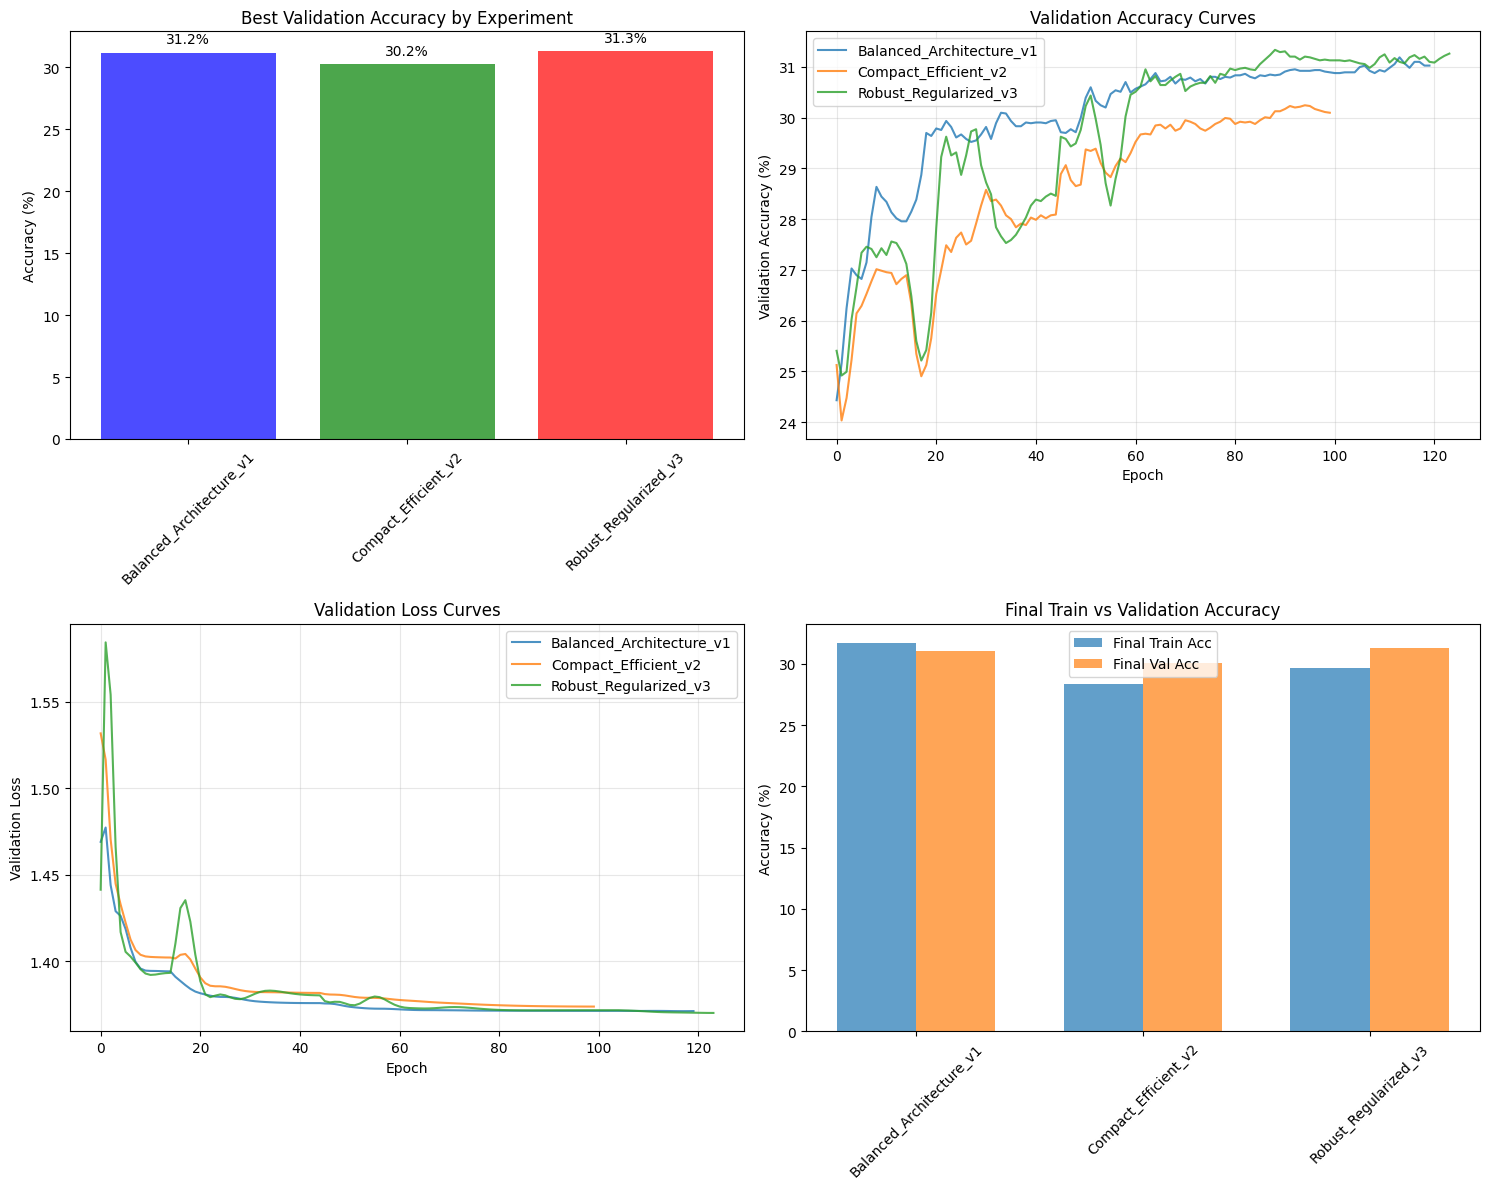


EXPERIMENT RESULTS SUMMARY
Experiment           Best Val Acc Final Train  Final Val    Overfitting 
--------------------------------------------------------------------------------
Balanced_Architecture_v1 31.19        31.68        31.02        0.66        
Compact_Efficient_v2 30.24        28.35        30.09        -1.74       
Robust_Regularized_v3 31.33        29.69        31.26        -1.57       

BEST EXPERIMENT: Robust_Regularized_v3 with 31.33% validation accuracy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compare_experiments(results):
    """Compare and visualize experiment results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Best validation accuracies
    names = [r['name'] for r in results]
    best_accs = [r['best_val_acc'] for r in results]
    
    axes[0,0].bar(names, best_accs, alpha=0.7, color=['blue', 'green', 'red'][:len(names)])
    axes[0,0].set_title('Best Validation Accuracy by Experiment')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(best_accs):
        axes[0,0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    # Training curves comparison
    for i, result in enumerate(results):
        axes[0,1].plot(result['val_history']['acc'], label=result['name'], alpha=0.8)
    
    axes[0,1].set_title('Validation Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Validation Accuracy (%)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Loss curves comparison  
    for i, result in enumerate(results):
        axes[1,0].plot(result['val_history']['loss'], label=result['name'], alpha=0.8)
    
    axes[1,0].set_title('Validation Loss Curves')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Validation Loss')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Final performance summary
    final_train = [r['final_train_acc'] for r in results]
    final_val = [r['final_val_acc'] for r in results]
    
    x = np.arange(len(names))
    width = 0.35
    
    axes[1,1].bar(x - width/2, final_train, width, label='Final Train Acc', alpha=0.7)
    axes[1,1].bar(x + width/2, final_val, width, label='Final Val Acc', alpha=0.7)
    
    axes[1,1].set_title('Final Train vs Validation Accuracy')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(names, rotation=45)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print(f"\n{'='*80}")
    print(f"EXPERIMENT RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"{'Experiment':<20} {'Best Val Acc':<12} {'Final Train':<12} {'Final Val':<12} {'Overfitting':<12}")
    print(f"{'-'*80}")
    
    for r in results:
        overfitting = r['final_train_acc'] - r['final_val_acc']
        print(f"{r['name']:<20} {r['best_val_acc']:<12.2f} {r['final_train_acc']:<12.2f} {r['final_val_acc']:<12.2f} {overfitting:<12.2f}")
    
    # Find best experiment
    best_exp = max(results, key=lambda x: x['best_val_acc'])
    print(f"\nBEST EXPERIMENT: {best_exp['name']} with {best_exp['best_val_acc']:.2f}% validation accuracy")
    
    return best_exp

# Run the comparison
best_experiment = compare_experiments(results)